## Plotbot Setup

In [1]:
pip install scipy==1.15.2

Note: you may need to restart the kernel to use updated packages.


### Imports

In [52]:
#The version checker! Run and scroll down! 🎉

# You aren't requried to use this, but if you encounter
# any issues running plotbot, it may be due to version incompatibilities.
# run this cell and check the output. If any of the versions do not match,
# you can update them using the pip install command printed below.
# Then restart the kernel to ensure the new versions are loaded.
# In the future we'll create an environment file to manage this.

import numpy as np
import matplotlib
import cdflib
import sys
import pandas as pd
import bs4
import requests
import dateutil
import scipy
from scipy import stats 
import matplotlib.dates as mdates  
from datetime import datetime, timezone, timedelta 
from dateutil.parser import parse 

# known working versions
REQUIRED_VERSIONS = {
    'Python': '3.12.4',
    'NumPy': '1.26.4',
    'Pandas': '2.2.2',
    'Matplotlib': '3.9.2',
    'cdflib': '1.3.1',
    'BeautifulSoup': '4.12.3',
    'requests': '2.32.3',
    'python-dateutil': '2.9.0.post0',
    'SciPy': '1.15.2',  # Added to match environment.yml
}

def check_versions():
    """Check installed versions against known working versions."""
    current_versions = {
        'Python': sys.version.split()[0],
        'NumPy': np.__version__,
        'Pandas': pd.__version__,
        'Matplotlib': matplotlib.__version__,
        'cdflib': cdflib.__version__,
        'BeautifulSoup': bs4.__version__,
        'requests': requests.__version__,
        'python-dateutil': dateutil.__version__,
        'SciPy': scipy.__version__,  # Now included in the check
    }
    
    print("\n=== Version Check Results ===")
    print("Recommended versions for Plotbot v1.5\n")
    
    all_match = True
    for pkg, req_version in REQUIRED_VERSIONS.items():
        curr_version = current_versions[pkg]
        match = curr_version == req_version
        all_match &= match
        
        status = "✓" if match else "✗"
        print(f"{status} {pkg:15} Current: {curr_version:8}  Recommended: {req_version:8}")
        
        if not match:
            if pkg == 'Python':
                print(f"   To switch: Download Python {req_version} from python.org")
            else:
                pkg_name = pkg.lower()
                if pkg == 'BeautifulSoup':
                    pkg_name = 'beautifulsoup4'
                print(f"   To switch: !pip install {pkg_name}=={req_version}")
    
    if all_match:
        print("\n🎉 All versions match! You're good to go!")
        print("   Note: Version management will be handled with an environment in the future 🤗")
    else:
        print("\n⚠️  Some versions don't match. Use the commands above to install the required versions.")
        print("   Tip: You might want to use a virtual environment before making changes.")
        print("   Tip: Remember to refresh the kernel after installing new packages.")
        print("   Note: Version management will be handled with an environment in the future 🤗")

# Run the check
check_versions()


=== Version Check Results ===
Recommended versions for Plotbot v1.5

✓ Python          Current: 3.12.4    Recommended: 3.12.4  
✓ NumPy           Current: 1.26.4    Recommended: 1.26.4  
✓ Pandas          Current: 2.2.2     Recommended: 2.2.2   
✓ Matplotlib      Current: 3.9.2     Recommended: 3.9.2   
✓ cdflib          Current: 1.3.1     Recommended: 1.3.1   
✓ BeautifulSoup   Current: 4.12.3    Recommended: 4.12.3  
✓ requests        Current: 2.32.3    Recommended: 2.32.3  
✓ python-dateutil Current: 2.9.0.post0  Recommended: 2.9.0.post0
✓ SciPy           Current: 1.15.2    Recommended: 1.15.2  

🎉 All versions match! You're good to go!
   Note: Version management will be handled with an environment in the future 🤗


Once the versions are all set I recommend using "Run All" to 
initialize all the cells, then scroll down to the plotbot section
and start plotting to your heart's content! 🚀


In [3]:
# {
#     "python.languageServer": "Pylance",
#     "python.analysis.typeCheckingMode": "basic",
#     "editor.suggestSelection": "first",
#     "editor.inlineSuggestions.enabled": true
# }

In [4]:
# Standard Library Imports for Date, Time, and OS Operations
from datetime import datetime, timedelta, timezone, time
from dateutil.parser import parse
import os
import sys
import re
# import time
from getpass import getpass
from collections import defaultdict, namedtuple
from typing import Dict, List, Optional
import matplotlib.dates as mdates
import matplotlib.ticker as mticker  # Add this line

# Scientific and Numerical Computing Libraries
import numpy as np
import pandas as pd

# Web and Data Retrieval Libraries
import requests
from bs4 import BeautifulSoup

# CDF File Handling Libraries
import cdflib

# Conditional Imports for CDF Epoch Handling
try:
    from cdflib.epochs_astropy import CDFAstropy as cdfepoch
except ImportError:
    print("Using cdflib.cdfepoch")
    from cdflib import cdfepoch

# Initialize data variables
mag_rtn_vars = None
mag_rtn_4sa_vars = None
mag_sc_vars = None
mag_sc_4sa_vars = None
spe_sf0_pad = None
spe_af0_pad = None
spi_sf00_l3_mom = None
spi_af00_L3_mom = None

#plotting 
import matplotlib.pyplot as plt
import matplotlib.colors as colors
plt.rcParams['mathtext.fontset'] = 'stix' #resolves a warning for symbol interpretation


Using cdflib.cdfepoch


### Data Management

In [5]:
class PrintManager:
    def __init__(self):
        # Print settings
        self.show_debug = False
        self.show_status = True
        self.show_datacubby = False  # Add this line
       
    def debug(self, message):
        """For detailed debugging information"""
        # print("self.show_debug: ", self.show_debug)
        if self.show_debug:
            print(message)
            
    def status(self, message):
        """For important status updates"""
        # print("self.show_status: ", self.show_status)
        if self.show_status:
            print(message)
            
    def datacubby(self, message):
        """For data cubby specific messages"""
        # print("self.show_datacubby: ", self.show_datacubby)
        if self.show_datacubby:  # Simplified since we know attribute exists
            print(message)

# Create global instance
print_manager = PrintManager()


In [6]:
#====================================================================
# CONFIGURATION: Data Types, Defines all available PSP data products
#====================================================================
data_types = {
    'mag_RTN': {
        'url': 'https://sprg.ssl.berkeley.edu/data/psp/data/sci/fields/{data_level}/mag_RTN/',  # URL for data source
        'local_path': os.path.join('psp_data', 'fields', '{data_level}', 'mag_rtn'),  # Local path for storing data
        'password_type': 'mag',  # Type of password required
        'file_pattern': r'psp_fld_{data_level}_mag_RTN_{date_hour_str}_v(\d{{2}})\.cdf',  # Regex pattern for file names
        'file_pattern_import': r'psp_fld_{data_level}_mag_RTN_{date_hour_str}_v*.cdf',  # Regex pattern for importing files
        'data_level': 'l2',  # Data level
        'file_time_format': '6-hour',  # Time format of the files
        'data_vars': ['psp_fld_l2_mag_RTN'],  # Variables to import
    },
    'mag_RTN_4sa': {
        'url': 'https://sprg.ssl.berkeley.edu/data/psp/data/sci/fields/{data_level}/mag_RTN_4_Sa_per_Cyc/',
        'local_path': os.path.join('psp_data', 'fields', '{data_level}', 'mag_rtn_4_per_cycle'),
        'password_type': 'mag',
        'file_pattern': r'psp_fld_{data_level}_mag_RTN_4_Sa_per_Cyc_{date_str}_v(\d{{2}})\.cdf',      # Added this
        'file_pattern_import': r'psp_fld_{data_level}_mag_RTN_4_Sa_per_Cyc_{date_str}_v*.cdf',  # Fixed case to match actual files
        'data_level': 'l2',
        'file_time_format': 'daily',
        'data_vars': ['psp_fld_l2_mag_RTN_4_Sa_per_Cyc'],
    },
    'mag_SC': {
        'url': 'https://sprg.ssl.berkeley.edu/data/psp/data/sci/fields/{data_level}/mag_SC/',
        'local_path': os.path.join('psp_data', 'fields', '{data_level}', 'mag_sc'),
        'password_type': 'mag',
        'file_pattern': r'psp_fld_{data_level}_mag_SC_{date_hour_str}_v(\d{{2}})\.cdf',
        'file_pattern_import': r'psp_fld_{data_level}_mag_SC_{date_hour_str}_v*.cdf',
        'data_level': 'l2',
        'file_time_format': '6-hour',
        'data_vars': ['psp_fld_l2_mag_SC'],
    },
    'mag_SC_4sa': {
        'url': 'https://sprg.ssl.berkeley.edu/data/psp/data/sci/fields/{data_level}/mag_SC_4_Sa_per_Cyc/',
        'local_path': os.path.join('psp_data', 'fields', '{data_level}', 'mag_sc_4_per_cycle'),
        'password_type': 'mag',
        'file_pattern': r'psp_fld_{data_level}_mag_SC_4_Sa_per_Cyc_{date_str}_v(\d{{2}})\.cdf',
        'file_pattern_import': r'psp_fld_{data_level}_mag_SC_4_Sa_per_Cyc_{date_str}_v*.cdf',
        'data_level': 'l2',
        'file_time_format': 'daily',
        'data_vars': ['psp_fld_l2_mag_SC_4_Sa_per_Cyc'],
    },
    'spe_sf0_pad': {  # Electron data
        'url': 'https://sprg.ssl.berkeley.edu/data/psp/data/sci/sweap/spe/L3/spe_sf0_pad/',
        'local_path': os.path.join('psp_data', 'sweap', 'spe', 'l3', 'spe_sf0_pad'),
        'password_type': 'sweap',
        'file_pattern': r'psp_swp_spe_sf0_L3_pad_{date_str}_v(\d{{2}})\.cdf',
        'file_pattern_import': r'psp_swp_spe_sf0_L3_pad_{date_str}_v*.cdf',
        'data_level': 'l3',
        'file_time_format': 'daily',
        'data_vars': ['EFLUX_VS_PA_E', 'PITCHANGLE'],
    },
    'spe_af0_pad': {  # High-resolution electron data
        'url': 'https://sprg.ssl.berkeley.edu/data/psp/data/sci/sweap/spe/L3/spe_af0_pad/',
        'local_path': os.path.join('psp_data', 'sweap', 'spe', 'l3', 'spe_af0_pad'),
        'password_type': 'sweap',
        'file_pattern': r'psp_swp_spe_af0_L3_pad_{date_str}_v(\d{{2}})\.cdf',
        'file_pattern_import': r'psp_swp_spe_af0_L3_pad_{date_str}_v*.cdf',
        'data_level': 'l3',
        'file_time_format': 'daily',
        'data_vars': ['EFLUX_VS_PA_E', 'PITCHANGLE'],
    },
    'spi_sf00_l3_mom': {  # Proton data
        'url': 'https://sprg.ssl.berkeley.edu/data/psp/data/sci/sweap/spi/L3/spi_sf00/',
        'local_path': os.path.join('psp_data', 'sweap', 'spi', 'l3', 'spi_sf00_l3_mom'),
        'password_type': 'sweap',
        'file_pattern': r'psp_swp_spi_sf00_L3_mom_{date_str}_v(\d{{2}})\.cdf',
        'file_pattern_import': r'psp_swp_spi_sf00_L3_mom_{date_str}_v*.cdf',
        'data_level': 'l3',
        'file_time_format': 'daily',
        'data_vars': [
            'VEL_RTN_SUN', 'DENS', 'TEMP', 'MAGF_INST', 'T_TENSOR_INST',
            'EFLUX_VS_ENERGY', 'EFLUX_VS_THETA', 'EFLUX_VS_PHI',
            'ENERGY_VALS', 'THETA_VALS', 'PHI_VALS'
        ],
    },
    'spi_af00_L3_mom': {  # High-resolution proton data
        'url': 'https://sprg.ssl.berkeley.edu/data/psp/data/sci/sweap/spi/L3/spi_af00/',
        'local_path': os.path.join('psp_data', 'sweap', 'spi', 'l3', 'spi_af00_l3_mom'),
        'password_type': 'sweap',
        'file_pattern': r'psp_swp_spi_af00_L3_mom_{date_str}_v(\d{{2}})\.cdf',
        'file_pattern_import': r'psp_swp_spi_af00_L3_mom_{date_str}_v*.cdf',
        'data_level': 'l3',
        'file_time_format': 'daily',
        'data_vars': [
            'VEL_RTN_SUN', 'DENS', 'TEMP', 'MAGF_INST', 'T_TENSOR_INST',
            'EFLUX_VS_ENERGY', 'EFLUX_VS_THETA', 'EFLUX_VS_PHI',
            'ENERGY_VALS', 'THETA_VALS', 'PHI_VALS'
        ],
    },
}

#====================================================================
# CONFIGURATION: Data Server Access
#====================================================================
class ServerAccess:
    def __init__(self):
        self._username = None
        self._password = None
        self._session = None
        self._password_type = None
        self.password_prompts = {
            'mag': "🧲 Enter your PASSWORD for restricted PSP FIELDS data: ",
            'sweap': "⚛️⚡️ Enter your PASSWORD for restricted PSP SWEAP data: "
        }
        print_manager.debug("🔐 ServerAccess initialized")
    
    @property
    def password_type(self):
        return self._password_type
        
    @password_type.setter
    def password_type(self, value):
        if value != self._password_type:  # If password type changes
            self._password = None  # Clear the password
        self._password_type = value
    
    @property
    def username(self):
        print_manager.debug(f"🔑 Current username: {self._username}")
        if self._username is None:
            self._username = getpass("🔒 Non-Public Data Request. Enter your USER NAME for PSP Data Access")
        return self._username
    
    @username.setter
    def username(self, value):
        print_manager.debug(f"✍️ Setting username to: {value}")
        self._username = value
    
    @property
    def password(self):
        if self._password is None:
            prompt = self.password_prompts.get(self._password_type, "Enter your PSP data server password: ")
            self._password = getpass(prompt)
        return self._password
    
    @password.setter
    def password(self, value):
        self._password = value
    
    @property
    def session(self):
        if self._session is None:
            self._session = requests.Session()
        return self._session
    
    def clear(self):
        """Clear stored credentials on failed auth."""
        self._password = None
        self._username = None

# Initialize server access
server_access = ServerAccess()

# Keep imported_data dictionary for caching
imported_data = {}  # Store imported data in memory

In [7]:
#====================================================================
# CLASS: data_cubby, A simple registry to store and retrieve data
#====================================================================
#data_cubby_location
class data_cubby:
    cubby = {}
    class_registry = {}
    subclass_registry = {}

    @classmethod
    def stash(cls, obj, class_name=None, subclass_name=None):
        """Store object with class and subclass tracking."""
        print_manager.datacubby("\n=== Stashing Debug (INSIDE DATA CUBBY)===")
        identifier = f"{class_name}.{subclass_name}" if class_name and subclass_name else class_name
        print_manager.datacubby(f"Stashing with identifier: {identifier}")
        
        # Debug print object attributes before stashing
        print_manager.datacubby(f"Attributes before stash:")
        for attr in dir(obj):
            if not attr.startswith('__'):
                value = getattr(obj, attr, 'not set')
                # ALWAYS truncate arrays/lists to 10 items
                if isinstance(value, (list, np.ndarray)):
                    if isinstance(value, np.ndarray):
                        preview = str(value.flatten()[:10]) + "..."
                    else:
                        preview = str(value[:10]) + "..."
                    print_manager.datacubby(f"- {attr}: {preview}")
                else:
                    print_manager.datacubby(f"- {attr}: {value}")
            
        cls.cubby[identifier] = obj
        if class_name:
            cls.class_registry[class_name] = obj
            print_manager.datacubby(f"Stored in class_registry: {class_name}")
            
        if subclass_name:
            cls.subclass_registry[subclass_name] = obj
            print_manager.datacubby(f"Stored in subclass_registry: {subclass_name}")
            
        print_manager.datacubby("=== End Stashing Debug (LEAVING DATA CUBBY)===\n")
        return obj

    @classmethod
    def grab(cls, identifier):
        """Retrieve object by its identifier."""
        print_manager.datacubby("\n=== Retrieval Debug INSIDE DATA CUBBY===")
        print_manager.datacubby(f"Attempting to retrieve: {identifier}")
        
        result = (cls.cubby.get(identifier) or 
                 cls.class_registry.get(identifier) or 
                 cls.subclass_registry.get(identifier))
                 
        if result is not None:
            # Print plot options for any component that has them
            print_manager.datacubby(f"\nPlot Options for {identifier}:")
            for attr_name in dir(result):
                if not attr_name.startswith('__'):  # Skip private attributes
                    var = getattr(result, attr_name)
                    if hasattr(var, 'plot_options'):  # Only print if it has plot options
                        print_manager.datacubby(f"\n{attr_name} plot options:")
                        for opt_name, value in vars(var.plot_options).items():
                            if not opt_name.startswith('_'):
                                # ALWAYS truncate arrays/lists to 10 items
                                if isinstance(value, (list, np.ndarray)):
                                    if isinstance(value, np.ndarray):
                                        preview = str(value.flatten()[:10]) + "..."
                                    else:
                                        preview = str(value[:10]) + "..."
                                    print_manager.datacubby(f"  {opt_name}: {preview}")
                                else:
                                    print_manager.datacubby(f"  {opt_name}: {value}")
                        if hasattr(var, '_plot_state'):
                            print_manager.datacubby(f"  _plot_state: {var._plot_state}")
            
            print_manager.datacubby(f"Successfully retrieved object")
        else:
            print_manager.datacubby(f"No object found for identifier: {identifier}")
            
        print_manager.datacubby("=== End Retrieval Debug - LEAVING DATA CUBBY===\n")
        return result

In [8]:
#====================================================================
# CLASS: DataTracker, Manages data import and calculation tracking
#====================================================================
class DataTracker:
    """Tracks imported and calculated data ranges to prevent redundant operations."""
    
    def __init__(self):
        self.imported_ranges = {}      # Dictionary storing time ranges of imported data, keyed by data type (e.g., 'mag_RTN')
        self.calculated_ranges = {}     # Dictionary storing time ranges of calculated variables, keyed by data type
    
    #====================================================================
    # FUNCTION: is_import_needed, Checks if data needs to be imported
    #====================================================================
    def is_import_needed(self, trange, data_type):
        """Check if import is needed based on trange and cached data"""
        if data_type not in self.imported_ranges:
            return True

        # Convert request times to datetime
        # Validate time range and ensure UTC timezone
        start_time = datetime.strptime(trange[0], '%Y-%m-%d/%H:%M:%S.%f').replace(tzinfo=timezone.utc)
        end_time = datetime.strptime(trange[1], '%Y-%m-%d/%H:%M:%S.%f').replace(tzinfo=timezone.utc)
        
        # Check if any stored range covers our request
        for stored_start, stored_end in self.imported_ranges[data_type]:
            if start_time >= stored_start and end_time <= stored_end:
                return False  # Found a range that covers our request
                
        return True  # No stored range covers our request

    #====================================================================
    # FUNCTION: is_calculation_needed, Verifies if calculations are required
    #====================================================================
    def is_calculation_needed(self, trange, data_type):
        """Determine if calculations are needed for the specified time range."""
        if not self._is_action_needed(trange, data_type, self.calculated_ranges, "calculated"):  # Check if range is already covered
            print_manager.status(f"{data_type} variables already calculated for the time range: {trange[0]} to {trange[1]}")  # Inform user if already done
        return self._is_action_needed(trange, data_type, self.calculated_ranges, "calculated")   # Return True if calculations needed

    #====================================================================
    # FUNCTION: update_imported_range, Records newly imported data ranges
    #====================================================================
    def update_imported_range(self, trange, data_type):
        """Record a new imported time range for a specific data type."""
        
        # Validate time range and ensure UTC timezone
        start_time = datetime.strptime(trange[0], '%Y-%m-%d/%H:%M:%S.%f').replace(tzinfo=timezone.utc)
        end_time = datetime.strptime(trange[1], '%Y-%m-%d/%H:%M:%S.%f').replace(tzinfo=timezone.utc)
        
        if data_type not in self.imported_ranges:                       # Create new list for data type if not exists
            self.imported_ranges[data_type] = []                        # Initialize empty list to store time ranges
        
        self.imported_ranges[data_type].append((start_time, end_time))  # Add new time range tuple to tracking list

    #====================================================================
    # FUNCTION: update_calculated_range, Records newly calculated data ranges
    #====================================================================
    def update_calculated_range(self, trange, data_type):
        """Record a new calculated time range for a specific data type."""
        self._update_range(trange, data_type, self.calculated_ranges)   # Use internal method to update calculated ranges

    #====================================================================
    # FUNCTION: get_calculated_range, Retrieves full range of calculations
    #====================================================================
    def get_calculated_range(self, data_type):
        """Retrieve the full calculated time range for a data type."""
        if data_type not in self.calculated_ranges:                     # Check if we have any calculations for this type
            return None                                                 # Return None if no calculations exist
        ranges = self.calculated_ranges[data_type]                      # Get list of all calculated ranges
        if not ranges:                                                 # If list exists but is empty
            return None                                                # Return None for no calculations
        earliest_start = min(r[0] for r in ranges)                    # Find earliest start time across all ranges
        latest_end = max(r[1] for r in ranges)                        # Find latest end time across all ranges
        return (earliest_start, latest_end)                           # Return tuple of full time coverage

    #====================================================================
    # FUNCTION: _is_action_needed (Internal), Checks for existing coverage
    #====================================================================
    def _is_action_needed(self, trange, data_type, ranges_dict, action_type):
        """Determine if an action is needed by checking existing time ranges."""
        # Validate time range and ensure UTC timezone
        start_time = datetime.strptime(trange[0], '%Y-%m-%d/%H:%M:%S.%f').replace(tzinfo=timezone.utc)
        end_time = datetime.strptime(trange[1], '%Y-%m-%d/%H:%M:%S.%f').replace(tzinfo=timezone.utc)

        if data_type in ranges_dict:                                     # If we have existing ranges for this data
            for stored_start, stored_end in ranges_dict[data_type]:      # Check each stored time range
                if start_time >= stored_start and end_time <= stored_end: # If requested range is fully contained
                    return False                                          # No action needed - already covered

        return True                                                      # Action needed if no containing range found

    #====================================================================
    # FUNCTION: _update_range (Internal), Updates stored time ranges
    #====================================================================
    def _update_range(self, trange, data_type, ranges_dict):
        """Update the stored time ranges for a specific data type."""
        # Validate time range and ensure UTC timezone
        start_time = datetime.strptime(trange[0], '%Y-%m-%d/%H:%M:%S.%f').replace(tzinfo=timezone.utc)
        end_time = datetime.strptime(trange[1], '%Y-%m-%d/%H:%M:%S.%f').replace(tzinfo=timezone.utc)

        if data_type not in ranges_dict:                                # If first range for this data type
            ranges_dict[data_type] = []                                 # Initialize empty list for ranges

        ranges_dict[data_type].append((start_time, end_time))          # Store new time range as tuple

    #====================================================================
    # FUNCTION: print_imported_ranges, Displays all tracked import ranges
    #====================================================================
    def print_imported_ranges(self):
        """Display all imported time ranges by data type."""
        for data_type, ranges in self.imported_ranges.items():          # Iterate through all tracked data types
            print(f"{data_type}: {ranges}")                             # Print ranges for each type

#====================================================================
# Create global tracker instance for application-wide range tracking
#====================================================================
global_tracker = DataTracker()                                          # Single instance used throughout application

In [9]:
#====================================================================
# FUNCTION: daterange, Generates sequence of dates between two endpoints
#====================================================================
def daterange(start_date, end_date):
    """
    Yield dates between start_date and end_date, inclusive.
    If end_date has any hours/minutes/seconds, include that full day.
    If end_time is exactly at midnight, do not include that day.
    """
    print_manager.debug(f"daterange called with start_date={start_date}, end_date={end_date}")
    
    if isinstance(end_date, datetime):
        if (end_date.hour == 0 and end_date.minute == 0 and
            end_date.second == 0 and end_date.microsecond == 0):
            # Do not include the end date
            end_date = (end_date - timedelta(days=1)).date()
            print_manager.debug(f"End date is midnight, adjusting to previous day: {end_date}")
        else:
            # Include the end date
            end_date = end_date.date()
            print_manager.debug(f"End date has time component, using full day: {end_date}")
    
    if isinstance(start_date, datetime):
        start_date = start_date.date()
        print_manager.debug(f"Converted start_date to date: {start_date}")
    
    total_days = int((end_date - start_date).days + 1)
    print_manager.debug(f"Will generate {total_days} dates")
    
    for n in range(total_days):
        date = start_date + timedelta(n)
        print_manager.debug(f"Yielding date: {date}")
        yield date
        
def get_needed_6hour_blocks(start_time, end_time):
    """
    Generate a list of (date, block) tuples needed for 6-hour files.
    Each block is an integer from 0 to 3, representing hours 0-5, 6-11, 12-17, 18-23.
    """
    print_manager.debug(f"get_needed_6hour_blocks called with start_time={start_time}, end_time={end_time}")
    
    blocks = []
    # Round down start_time to nearest 6-hour block
    start_block_hour = (start_time.hour // 6) * 6
    print_manager.debug(f"Rounded start hour {start_time.hour} down to {start_block_hour}")
    
    # Make current_time timezone-aware to match end_time
    current_time = datetime.combine(start_time.date(), time(start_block_hour)).replace(tzinfo=start_time.tzinfo)
    print_manager.debug(f"Initial current_time: {current_time}")
    
    while current_time < end_time:
        current_date = current_time.date()
        block = current_time.hour // 6
        print_manager.debug(f"Adding block {block} for date {current_date}")
        blocks.append((current_date, block))
        current_time += timedelta(hours=6)
        print_manager.debug(f"Advanced to {current_time}")
    
    print_manager.debug(f"Returning {len(blocks)} blocks: {blocks}")
    return blocks

def get_encounter_number(start_date):
    """
    Determine the encounter number based on the provided start date.

    Parameters:
    start_date (str): Start date in any standard format

    Returns:
    str: Encounter number (e.g., 'E1', 'E2')
    """
    # Convert input date to datetime object first
    if isinstance(start_date, str):
        # Use dateutil.parser to handle a wide variety of date formats
        try:
            date_obj = parse(start_date)
        except (ValueError, TypeError):
            print(f"Warning: Could not parse date {start_date}")
            return "Unknown_Encounter"
    else:
        date_obj = start_date
    
    # Convert to YYYY-MM-DD format for comparison
    formatted_date = date_obj.strftime('%Y-%m-%d')
    
    encounters = { #expanded encounter list
        'E1': ('2018-10-31', '2018-11-11'),
        'E2': ('2019-03-30', '2019-04-10'),
        'E3': ('2019-08-17', '2019-09-18'),
        'E4': ('2019-12-17', '2020-02-17'),
        'E5': ('2020-04-25', '2020-07-07'),
        'E6': ('2020-08-08', '2020-10-31'),
        'E7': ('2020-12-11', '2021-02-19'),
        'E8': ('2021-04-14', '2021-05-15'),
        'E9': ('2021-06-20', '2021-09-10'),
        'E10': ('2021-11-11', '2022-01-06'),
        'E11': ('2022-02-04', '2022-04-14'),
        'E12': ('2022-05-08', '2022-06-11'),
        'E13': ('2022-08-17', '2022-09-27'),
        'E14': ('2022-12-03', '2022-12-18'),
        'E15': ('2023-01-17', '2023-03-24'),
        'E16': ('2023-06-12', '2023-07-23'),
        'E17': ('2023-09-22', '2023-10-04'),
        'E18': ('2023-12-24', '2024-01-09'),
        'E19': ('2024-03-25', '2024-04-09'),
        'E20': ('2024-05-30', '2024-07-30'),
        'E21': ('2024-08-30', '2024-10-30'),
        'E22': ('2024-11-24', '2025-01-24'),
        'E23': ('2025-02-22', '2025-04-22'),
        'E24': ('2025-05-19', '2025-07-19'),
        'E25': ('2025-08-15', '2025-10-15'),
        'E26': ('2025-11-12', '2026-01-12')
    }
 
    for encounter, (enc_start, enc_stop) in encounters.items():
        if enc_start <= formatted_date <= enc_stop:
            return encounter
    return "Unknown_Encounter"


## Fuctions: Data Checking / Downloading / Importing

#### Check Local Files

In [10]:
#====================================================================
# FUNCTION: check_local_files, Verifies data file availability locally
#====================================================================
def check_local_files(trange: tuple, data_type: str) -> tuple[bool, list, list]:
    """
    Check if files exist locally for given time range and data type.
    Returns:
        - bool: True if we have complete coverage
        - list: Found files
        - list: Missing files
    """
    print_manager.debug("Local Files Time Debug")
    print_manager.debug(f"Input trange: {trange}")
    # Validate time range and ensure UTC timezone
    start_time = datetime.strptime(trange[0], '%Y-%m-%d/%H:%M:%S.%f').replace(tzinfo=timezone.utc)
    end_time = datetime.strptime(trange[1], '%Y-%m-%d/%H:%M:%S.%f').replace(tzinfo=timezone.utc)
    print_manager.debug(f"Parsed start time: {start_time}")
    print_manager.debug(f"Parsed end time: {end_time}")
    print_manager.debug(f"Checking local files for time range: {trange} and data type: {data_type}")
    if data_type not in data_types:                                    # Validate requested data type exists
        print(f"Data type {data_type} is not recognized.")
        return False, [], []                                           # Return empty results if invalid type
        
    config = data_types[data_type]                                    # Get configuration for requested data type
    start_time = datetime.strptime(trange[0], '%Y-%m-%d/%H:%M:%S.%f')   # Convert start time string to datetime
    end_time = datetime.strptime(trange[1], '%Y-%m-%d/%H:%M:%S.%f')     # Convert end time string to datetime
    found_files = []                                                  # Initialize list to track existing files
    missing_files = []                                                # Initialize list to track missing files

    print_manager.debug(f"About to check dates between {start_time.date()} and {end_time.date()}")
    dates_to_check = list(daterange(start_time, end_time))
    print_manager.debug(f"Will check these dates: {dates_to_check}")
    

    for single_date in daterange(start_time, end_time): # Iterate through each day in range
        year = single_date.year                                       # Extract year for directory structure
        date_str = single_date.strftime('%Y%m%d')                    # Format date as YYYYMMDD string
        local_dir = os.path.join(config['local_path'].format(        # Construct path to year directory
            data_level=config['data_level']), str(year))
        print_manager.debug(f"Checking files for date: {date_str}")

        if config['file_time_format'] == '6-hour':                    # Handle 6-hour cadence data files
            blocks_to_check = get_needed_6hour_blocks(start_time, end_time)
            for single_date, block in blocks_to_check:
                hour = block * 6
                hour_str = f"{hour:02d}"                              # Format hour as 2-digit string
                date_str = single_date.strftime('%Y%m%d')             # Format date as YYYYMMDD string
                date_hour_str = f"{date_str}{hour_str}"              # Combine date and hour for filename
                file_pattern = config['file_pattern_import'].format(  # Create filename pattern for this interval
                    data_level=config['data_level'],
                    date_hour_str=date_hour_str
                )
                full_pattern = os.path.join(local_dir, file_pattern) # Complete path with filename pattern
                print_manager.debug(f"  Searching for files matching: {file_pattern}")
                matching_files = case_insensitive_file_search(       # Search for matching files
                    local_dir, full_pattern)
                if matching_files:                                    # If files found for this interval
                    print_manager.debug(f"  ✓ Found {len(matching_files)} file(s)")
                    found_files.extend(matching_files)               # Add to list of found files
                else:                                                # If no files found
                    print_manager.debug(f"  ✗ No files found for interval {hour_str}:00")
                    missing_files.append(f"{date_str}_{hour_str}")  # Record as missing

        elif config['file_time_format'] == 'daily':                  # Handle daily cadence data files
            file_pattern = config['file_pattern_import'].format(     # Create filename pattern for this day
                data_level=config['data_level'],
                date_str=date_str
            )
            full_pattern = os.path.join(local_dir, file_pattern)    # Complete path with filename pattern
            print_manager.debug(f"  Searching for daily files matching: {file_pattern}")
            
            matching_files = case_insensitive_file_search(          # Search for matching files
                local_dir, full_pattern)
            if matching_files:                                       # If files found for this day
                print_manager.debug(f"  ✓ Found {len(matching_files)} file(s)")
                found_files.extend(matching_files)                  # Add to list of found files
            else:                                                   # If no files found
                print_manager.debug(f"  ✗ No files found for date {date_str}")
                missing_files.append(date_str)                     # Record as missing

    have_all_files = len(missing_files) == 0                       # Check if we found all needed files
    print_manager.debug(f"\nSummary:")
    print_manager.debug(f"Found files: {len(found_files)}")
    print_manager.debug(f"Missing files: {len(missing_files)}")
    return have_all_files, found_files, missing_files             # Return results tuple

#====================================================================
# FUNCTION: case_insensitive_file_search, Finds files ignoring case
#====================================================================
def case_insensitive_file_search(directory, pattern):
    """Perform a case-insensitive file search in the given directory."""
    try:
        if not os.path.exists(directory):
            print_manager.debug(f"Directory does not exist: {directory}")
            return []
            
        print_manager.debug(f"\nSearching directory: {directory}")
        dir_contents = os.listdir(directory)                        # Get list of files in directory
        print_manager.debug(f"Found {len(dir_contents)} total files in directory")
        if len(dir_contents) > 0:
            print_manager.debug(f"First few files: {dir_contents[:3]}")
        
        pattern_base = os.path.basename(pattern).lower()           # Extract and lowercase the filename pattern
        print_manager.debug(f"Searching for pattern: {pattern_base}")
        
        pattern_base = pattern_base.replace('_v*.cdf', '_v')      # Remove version wildcard for matching
        print_manager.debug(f"Modified pattern for matching: {pattern_base}")
        
        matching_files = [                                         # Create list of matching files
            os.path.join(directory, filename)                     # Include full path in results
            for filename in dir_contents                          # Check each file in directory
            if filename.lower().startswith(pattern_base)         # Compare lowercase versions
        ]
        
        print_manager.debug(f"Found {len(matching_files)} matching files")
        for file in matching_files:
            print_manager.debug(f"  - {os.path.basename(file)}")
            
        return matching_files                                     # Return list of matching files
    except Exception as e:                                        # Handle any filesystem errors
        print_manager.debug(f"Error listing directory {directory}: {str(e)}")
        import traceback
        print_manager.debug(f"Full error: {traceback.format_exc()}")
        return []                                                # Return empty list on error

#### Download New PSP Data

In [11]:
def authenticate_session(dir_url):
    """Handle authentication for PSP data access."""
    print_manager.debug("🔍 Starting authentication attempt")
    print_manager.debug(f"🔑 Password type: {server_access._password_type}")
    response = server_access.session.get(dir_url)
    print_manager.debug(f"📡 Initial response code: {response.status_code}")
    
    if response.status_code == 200:
        return response
        
    if response.status_code == 401:
        for attempt in range(2):
            print(f"Authentication required for {dir_url}")
            print_manager.debug(f"🔄 Attempt {attempt + 1} of 2")
            
            # Clear password before each attempt
            server_access._password = None
            
            # Debug the auth setup
            print_manager.debug("🔐 Setting up authentication...")
            username = server_access.username
            password = server_access.password  # This should trigger the password prompt
            server_access.session.auth = (username, password)
            
            response = server_access.session.get(dir_url)
            print_manager.debug(f"📡 Response code after auth attempt: {response.status_code}")
            
            if response.status_code == 200:
                return response
                
            if response.status_code == 401 and attempt < 1:
                print_manager.debug("❌ Authentication failed - please try again")

def process_file_listing(html_content, pattern_str, date_info):
    """Extract and sort filenames from directory listing.
    
    Args:
        html_content: HTML response from server
        pattern_str: Regex pattern for matching files
        date_info: Dict with keys:
            - date_str: Formatted date string
            - is_hourly: Boolean for 6-hour vs daily files
            - hour_str: Hour string (for 6-hour files)
    """
    soup = BeautifulSoup(html_content, 'html.parser')
    links = soup.find_all('a')
    filenames = [link.get('href') for link in links if link.get('href')]
    
    pattern = re.compile(pattern_str)
    files_with_versions = [(fname, int(m.group(1)))
                          for fname in filenames
                          if (m := pattern.match(fname))]
    
    if not files_with_versions:
        if date_info['is_hourly']:
            print(f'No files found for date {date_info["date_str"]} hour {date_info["hour_str"]}')
        else:
            print(f'No files found for date {date_info["date_str"]}')
        return None
        
    return max(files_with_versions, key=lambda x: x[1])[0]

def download_file(session, file_url, local_file_path):
    """Download and save a file."""
    print_manager.status(f'Downloading {file_url}')
    file_response = session.get(file_url)
    
    if file_response.status_code == 200:
        with open(local_file_path, 'wb') as f:
            f.write(file_response.content)
        print_manager.status(f'File {local_file_path} downloaded successfully.')
        return True
    else:
        print_manager.status(f'Error downloading {file_url}, status code {file_response.status_code}')
        return False

def setup_local_path(base_local_path, year, filename):
    """Setup local directory and return full file path."""
    local_dir = os.path.join(base_local_path, str(year))
    if not os.path.exists(local_dir):
        os.makedirs(local_dir)
    local_file_path = os.path.join(local_dir, filename)
    
    # Check if file already exists
    if os.path.exists(local_file_path):
        print_manager.debug(f'File {local_file_path} already exists, skipping download.')
        return None
    return local_file_path

def create_pattern_string(template, data_level, date_info):
    """Create pattern string based on file type."""
    if date_info['is_hourly']:
        date_hour_str = f"{date_info['date_str']}{date_info['hour_str']}"
        return template.format(data_level=data_level, date_hour_str=date_hour_str)
    return template.format(data_level=data_level, date_str=date_info['date_str'])
    
def process_directory(dir_url, pattern_str, date_info, base_local_path):
    """Handle the entire directory processing workflow."""
    response = authenticate_session(dir_url)  # Removed password_type parameter
    
    if response.status_code == 404:
        print(f"\nERROR: No data available at {dir_url}")
        return None
    if response.status_code != 200:
        print(f"Failed to access {dir_url} with status code {response.status_code}")
        return None
        
    latest_file = process_file_listing(response.text, pattern_str, date_info)
    if not latest_file:
        return None
        
    local_file_path = setup_local_path(base_local_path, date_info['year'], latest_file)
    if not local_file_path:  # File already exists
        return None
        
    file_url = dir_url + latest_file
    return download_file(server_access.session, file_url, local_file_path)



In [12]:
#====================================================================
# FUNCTION: download_new_psp_data
#====================================================================
def download_new_psp_data(trange, data_type):
    """Download new PSP data for a given data type and time range."""
    
    #====================================================================
    # VALIDATE DATA TYPE AND GET CONFIG
    #====================================================================
    if data_type not in data_types:                      # Verify the requested data type exists in our supported types dictionary
        print(f"Data type {data_type} is not recognized.")
        return
    config = data_types[data_type]                       # Extract the specific configuration settings for this data type (URLs, paths, patterns etc.)
        
    #====================================================================
    # PARSE TIME RANGE
    #====================================================================
    start_time = datetime.strptime(trange[0], '%Y-%m-%d/%H:%M:%S.%f').replace(tzinfo=timezone.utc)    # Convert string start time to datetime obj with UTC timezone
    end_time = datetime.strptime(trange[1], '%Y-%m-%d/%H:%M:%S.%f').replace(tzinfo=timezone.utc)      # Convert string end time to datetime obj with UTC timezone
    
    # Adjust end time if midnight
    if (end_time.hour == 0 and end_time.minute == 0 and             # Check if time is exactly 00:00:00.000 - this needs special handling
        end_time.second == 0 and end_time.microsecond == 0):
        end_time = end_time - timedelta(days=1)                      # Subtract 24 hours to get previous day, as midnight belongs to next day
    
    print_manager.debug(f"Downloading data for UTC time range: {start_time} to {end_time}")
    
    #====================================================================
    # CHECK LOCAL FILES
    #====================================================================
    have_all, found_files, missing_files = check_local_files(trange, data_type)
    if have_all:
        if len(found_files) == 1:
            print_manager.status(f"📡 {data_type} - A local .cdf file already exists:")
        else:
            print_manager.status(f"📡 {data_type} - Local .cdf files already exist:")
        print_manager.status("📂 " + ", ".join(found_files))
        return

    print_manager.debug(f"\nDownloading missing files for {data_type}:")
    for file in missing_files:
        if config['file_time_format'] == '6-hour':                   # For data types that split days into 6-hour chunks (e.g., 00, 06, 12, 18)
            date_str, hour_str = file.split('_')                     # Split filename into date and hour components
            pattern_str = config['file_pattern'].format(             # Create filename pattern for 6-hour format using config template
                data_level=config['data_level'],
                date_hour_str=f"{date_str}{hour_str}"
            )
        else:  # daily files
            pattern_str = config['file_pattern'].format(             # Create filename pattern for daily format using config template
                data_level=config['data_level'],
                date_str=file
            )
        pattern_str = pattern_str.split('_v')[0] + '_v*.cdf'        # Modify pattern to match any version number (v01, v02, etc.) to get latest
        print_manager.debug(f"- {pattern_str}")
    
    #====================================================================
    # SET PASSWORD TYPE
    #====================================================================
    server_access.password_type = config['password_type']

    #====================================================================
    # PROCESS FILES (6-HOUR OR DAILY)
    #====================================================================
    if config['file_time_format'] == '6-hour':
        blocks_to_download = get_needed_6hour_blocks(start_time, end_time)
        for block_date, block in blocks_to_download:
            try:
                date_info = {
                    'date_str': block_date.strftime('%Y%m%d'),
                    'is_hourly': True,
                    'hour_str': f"{block * 6:02d}",
                    'year': block_date.year
                }
                
                dir_url = f"{config['url'].format(data_level=config['data_level'])}{block_date.year}/{block_date.month:02d}/"
                pattern_str = create_pattern_string(config['file_pattern'], config['data_level'], date_info)
                
                process_directory(
                    dir_url=dir_url,
                    pattern_str=pattern_str,
                    date_info=date_info,
                    base_local_path=config['local_path'].format(data_level=config['data_level'])
                )
            except Exception as e:
                print("🤷🏾‍♂️ The data you're looking for can't be retrieved from the server, friend!")
                print(f'An error occurred: {e}')
                continue
    
    #====================================================================
    # PROCESS DAILY FILES
    #====================================================================
    elif config['file_time_format'] == 'daily':
        for single_date in daterange(start_time.date(), end_time.date()):
            try:
                date_info = {
                    'date_str': single_date.strftime('%Y%m%d'),
                    'is_hourly': False,
                    'hour_str': None,
                    'year': single_date.year
                }
                
                dir_url = f"{config['url'].format(data_level=config['data_level'])}{single_date.year}/{single_date.month:02d}/"
                pattern_str = create_pattern_string(config['file_pattern'], config['data_level'], date_info)
                
                process_directory(
                    dir_url=dir_url,
                    pattern_str=pattern_str,
                    date_info=date_info,
                    base_local_path=config['local_path'].format(data_level=config['data_level'])
                )
            except Exception as e:
                print("🤷🏾‍♂️ The data you're looking for can't be retrieved from the server, friend!")
                print(f'An error occurred: {e}')
                continue


#### Import PSP Data

In [13]:
def import_data_function(trange, data_type):
    """Import data function that reads only data within the specified time range."""
    
    print_manager.debug('Import data function called')
    print_manager.debug(f"Input trange: {trange}")
    
    # Parse times and ensure UTC timezone
    start_time = datetime.strptime(trange[0], '%Y-%m-%d/%H:%M:%S.%f')
    end_time = datetime.strptime(trange[1], '%Y-%m-%d/%H:%M:%S.%f')
    
    # Format dates for TT2000 conversion
    start_tt2000 = cdflib.cdfepoch.compute_tt2000(
        [start_time.year, start_time.month, start_time.day,
         start_time.hour, start_time.minute, start_time.second,
         int(start_time.microsecond/1000)]
    )
    
    end_tt2000 = cdflib.cdfepoch.compute_tt2000(
        [end_time.year, end_time.month, end_time.day,
         end_time.hour, end_time.minute, end_time.second,
         int(end_time.microsecond/1000)]
    )
    
    print_manager.debug(f"\nImporting data for UTC time range: {trange}")

    #====================================================================
    # INITIALIZATION AND CONFIGURATION 
    #====================================================================
    print_manager.debug(f"\n=== Starting import for {data_type} ===")
    config = data_types[data_type]              # Get configuration for specified data type
    variables = config.get('data_vars', [])     # Get list of variables to extract, empty list if none specified

    #====================================================================
    # FILE SEARCH AND COLLECTION
    #====================================================================
    found_files = []       # Initialize empty list to store found data files
    
    for single_date in daterange(start_time, end_time):  # Iterate through each date in the range
        year = single_date.year   # Extract year from current date
        date_str = single_date.strftime('%Y%m%d')  # Format date as YYYYMMDD string
        
        local_dir = os.path.join(config['local_path'].format(data_level=config['data_level']), str(year))  # Construct path to year directory
        
        # Handle different file timing formats (6-hour vs daily)
        if config['file_time_format'] == '6-hour':          # Check if files are in 6-hour format
            for hour in range(0, 24, 6):                    # Loop through hours in 6-hour increments
                hour_str = f"{hour:02d}"                    # Format hour as 2-digit string (e.g. '00', '06')
                date_hour_str = date_str + hour_str         # Combine date and hour strings
                file_pattern = config['file_pattern_import'].format(  # Create file pattern using config template
                    data_level=config['data_level'],
                    date_str=date_str,
                    date_hour_str=date_hour_str
                )

                if os.path.exists(local_dir): # Case insensitive file search
                    pattern = file_pattern.replace('*', '.*')  # Convert glob pattern to regex pattern
                    regex = re.compile(pattern, re.IGNORECASE)
                    matching_files = [os.path.join(local_dir, f) for f in os.listdir(local_dir) 
                                    if regex.match(f)]
                    if matching_files:                          # If matching files found
                        found_files.extend(matching_files)      # Add them to list of found files
                else:
                    print("Directory does not exist!")
        # Daily files
        elif config['file_time_format'] == 'daily':         # Check if files are in daily format
            file_pattern = config['file_pattern_import'].format(  # Create file pattern using config template
                data_level=config['data_level'],
                date_str=date_str
            )

            if os.path.exists(local_dir): # Case insensitive file search
                pattern = file_pattern.replace('*', '.*')  # Convert glob pattern to regex pattern
                regex = re.compile(pattern, re.IGNORECASE)
                matching_files = [os.path.join(local_dir, f) for f in os.listdir(local_dir) 
                                if regex.match(f)]
                if matching_files:                             # If matching files found
                    found_files.extend(matching_files)         # Add them to list of found files
            else:
                print("Directory does not exist!")
    
    if not found_files:
        print("No data files found in the specified time range.")
        return None
    #====================================================================
    # DATA EXTRACTION AND PROCESSING
    #====================================================================
    times_list = []                              # List to store time arrays from each file
    data_dict = {var: [] for var in variables}   # Dictionary to store data arrays for each variable
    epoch_cache = {}                             # Cache to store time data to avoid re-reading
    
    for file_path in sorted(found_files):        # Process each file in chronological order
        print_manager.debug(f"\nProcessing file: {file_path}")
        try:  # Attempt to open and process the CDF file
            with cdflib.CDF(file_path) as cdf_file:  # Open CDF file with context manager
                print_manager.debug("Successfully opened CDF file")
                
                # Locate and verify time variable
                time_vars = [var for var in cdf_file.cdf_info().zVariables if 'epoch' in var.lower()]  # Find time variable name
                if not time_vars:        # Skip file if no time variable found
                    print_manager.debug("No time variable found in file - skipping")
                    continue
                time_var = time_vars[0]  # Use first found time variable
                print_manager.debug(f"Using time variable: {time_var}")
                
                # Get file metadata
                var_info = cdf_file.varinq(time_var)   # Get variable info
                n_records = var_info.Last_Rec + 1      # Calculate number of records
                print_manager.debug(f"File contains {n_records} records")
                
                # Check file time boundaries
                first_time_data = cdf_file.varget(time_var, startrec=0, endrec=0)           # Get first time point
                last_time_data = cdf_file.varget(time_var, startrec=n_records-1, endrec=n_records-1)  # Get last time point
                print_manager.debug(f"File time range: {cdflib.epochs.CDFepoch.to_datetime(first_time_data[0])} to {cdflib.epochs.CDFepoch.to_datetime(last_time_data[0])}")
                print_manager.debug(f"Requested time range: {cdflib.epochs.CDFepoch.to_datetime(start_tt2000)} to {cdflib.epochs.CDFepoch.to_datetime(end_tt2000)}")
                
                # Compare TT2000 times directly, using array indexing to get scalar values
                if last_time_data[0] < start_tt2000 or first_time_data[0] > end_tt2000:
                    print_manager.debug(f"File outside requested time range:")
                    print_manager.debug(f"File start vs requested start: {first_time_data[0]} vs {start_tt2000}")
                    print_manager.debug(f"File end vs requested end: {last_time_data[0]} vs {end_tt2000}")
                    print_manager.debug("Skipping this file")
                    continue

                # Read time data
                print_manager.debug("Reading full time data array...")
                time_data = cdf_file.varget(time_var, epoch=True)
                print_manager.debug(f"Read {len(time_data)} time points")
                print_manager.debug(f"Time range in file: {cdflib.epochs.CDFepoch.to_datetime(time_data[0])} to {cdflib.epochs.CDFepoch.to_datetime(time_data[-1])}")

                # Find relevant data indices
                start_idx = np.searchsorted(time_data, start_tt2000, side='left')
                end_idx = np.searchsorted(time_data, end_tt2000, side='right')
                print_manager.debug(f"Time range requested: {start_time} to {end_time}")
                print_manager.debug(f"Time indices: {start_idx} to {end_idx}")
                if start_idx < len(time_data):
                    print_manager.debug(f"Start time selected: {cdflib.epochs.CDFepoch.to_datetime(time_data[start_idx])}")
                if end_idx > 0 and end_idx <= len(time_data):
                    print_manager.debug(f"End time selected: {cdflib.epochs.CDFepoch.to_datetime(time_data[end_idx-1])}")
                else:
                    print_manager.debug(f"End index {end_idx} out of bounds for array length {len(time_data)}")

                if start_idx >= end_idx:
                    print_manager.debug(f"Invalid index range: start_idx={start_idx}, end_idx={end_idx}")
                    print_manager.status("No data in time range for this file after indexing")
                    continue

                # Extract time slice we need - keep as TT2000
                time_slice = time_data[start_idx:end_idx]
                print_manager.debug(f"Extracted time slice range: {cdflib.epochs.CDFepoch.to_datetime(time_slice[0])} to {cdflib.epochs.CDFepoch.to_datetime(time_slice[-1])}")
                times_list.append(time_slice)
                print_manager.debug(f"Extracted {len(time_slice)} time points within requested range")
                for var_name in variables:                        # Process each requested variable
                    try:
                        print_manager.debug(f"\nReading variable: {var_name}")
                        var_data = cdf_file.varget(var_name, startrec=start_idx, endrec=end_idx-1)
                        print_manager.debug(f"Raw data shape: {var_data.shape}")
                        print_manager.debug(f"Raw data type: {var_data.dtype}")
                        print_manager.debug(f"Sample of raw data: {var_data[0] if len(var_data) > 0 else 'Empty'}")
                        
                        # Debug fill values
                        var_atts = cdf_file.varattsget(var_name)
                        print_manager.debug(f"Variable attributes: {var_atts}")
                        if "FILLVAL" in var_atts:
                            fill_val = var_atts["FILLVAL"]
                            print_manager.debug(f"Fill value: {fill_val}")
                            fill_count = np.sum(var_data == fill_val)
                            print_manager.debug(f"Number of fill values: {fill_count}")
                            
                            # Before fill value replacement
                            print_manager.debug("Data statistics before fill value replacement:")
                            print_manager.debug(f"Min: {np.min(var_data)}")
                            print_manager.debug(f"Max: {np.max(var_data)}")
                            print_manager.debug(f"Unique values: {np.unique(var_data)[:10]}...")
                            
                            # Replace fill values
                            var_data = np.where(var_data == fill_val, np.nan, var_data)
                            
                            # After fill value replacement
                            print_manager.debug("\nData statistics after fill value replacement:")
                            if not np.all(np.isnan(var_data)):
                                print_manager.debug(f"Min: {np.nanmin(var_data)}")
                                print_manager.debug(f"Max: {np.nanmax(var_data)}")
                                print_manager.debug(f"Unique values: {np.unique(var_data)[:10]}...")
                            else:
                                print_manager.debug("All values are NaN - skipping min/max calculations")
                            
                        data_dict[var_name].append(var_data)
                        print_manager.debug(f"Successfully stored data for {var_name}")
                        
                    except Exception as e:
                        print_manager.debug(f"Error processing {var_name}: {str(e)}")
                        print_manager.debug(f"Exception type: {type(e)}")
                        import traceback
                        print_manager.debug(traceback.format_exc())
                        
        except Exception as e:                                   # Handle file-level errors
            print(f"Error processing {file_path}: {e}")  # Print error message for failed file
            continue
    
    #====================================================================
    # DATA CONSOLIDATION AND CLEANUP
    #====================================================================
    if not times_list:  # Check if any data was collected
        print("No data found in the specified time range after processing files.")
        return None
        
    times = np.concatenate(times_list)
    concatenated_data = {}
    
    print_manager.debug("\nPost-concatenation debugging:")
    for var_name in variables:
        data_list = data_dict[var_name]
        if data_list:
            concatenated_data[var_name] = np.concatenate(data_list)
            data = concatenated_data[var_name]
            print_manager.debug(f"\nVariable: {var_name}")
            print_manager.debug("Shape: {data.shape}")
            print_manager.debug(f"NaN count: {np.isnan(data).sum()}")
            print_manager.debug(f"Non-NaN value range: [{np.nanmin(data)}, {np.nanmax(data)}]")
        else:
            concatenated_data[var_name] = None  # Store None if no data
    
    print_manager.debug(f"\nTotal data points after concatenation: {len(times)}")
    
    sort_indices = np.argsort(times)    # Get indices for chronological sorting
    times = times[sort_indices]         # Sort times array
    for var_name in variables:          # Sort each variable's data
        if concatenated_data[var_name] is not None:  # Check if data exists for this variable before sorting
            concatenated_data[var_name] = concatenated_data[var_name][sort_indices]  # Sort data array using same indices as time array
    
    DataObject = namedtuple('DataObject', ['times', 'data'])  # Create return object structure
    
    # After successful import
    global_tracker.update_imported_range(trange, data_type)
    # trange = np.around(trange, decimals=0)  # Truncate the seconds to integer values
    print_manager.status(f"✅ - Data import complete for range {trange}.")
    
    return DataObject(times=times, data=concatenated_data)  # Return packaged data

## Data Classes

#### Plotting Options Class (the template for all data classes)

In [14]:
#ORIGINAL
# 🎉 Define the generalized plotting options class 🎉
class ploptions:
    def __init__(self, data_type=None, var_name=None, class_name=None, subclass_name=None, plot_type=None, 
                 datetime_array=None, y_label=None, legend_label=None, color=None, y_scale=None,
                 y_limit=None, line_width=1, line_style='-',
                 colormap=None, colorbar_scale='linear', colorbar_limits=None, additional_data=None,
                 colorbar_label=None, data=None):  # Add data parameter
        self.data_type = data_type            # Actual data product name (e.g., 'mag_rtn_4sa')
        self.var_name = var_name              # Variable name in data file (e.g., 'br_rtn_4sa')
        self.class_name = class_name          # Class handling this data type (e.g., 'mag_rtn_4sa')
        self.subclass_name = subclass_name    # Specific Subclass (e.g., 'br')
        self.plot_type = plot_type            # Type of plot (e.g., 'time_series')
        self.datetime_array = datetime_array   # Time data
        self.y_label = y_label                # Y-axis label
        self.legend_label = legend_label      # Legend text
        self.color = color                    # Plot color
        self.y_scale = y_scale                # Scale type
        self.y_limit = y_limit                # Y-axis limits
        self.line_width = line_width          # Line width
        self.line_style = line_style          # Line style
        self.colormap = colormap
        self.colorbar_scale = colorbar_scale
        self.colorbar_limits = colorbar_limits
        self.additional_data = additional_data
        self.colorbar_label = colorbar_label
        self.data = data                      # Add data attribute

# 🎉 Extend numpy.ndarray with plotting functionality and friendly error handling 🎉
#SAFE! 
#plot_manager_location
class plot_manager(np.ndarray):
    
    PLOT_ATTRIBUTES = [
        'data', 'data_type', 'var_name', 'class_name', 'subclass_name', 'plot_type', 'datetime_array', 
        'y_label', 'legend_label', 'color', 'y_scale', 'y_limit', 'line_width',
        'line_style', 'colormap', 'colorbar_scale', 'colorbar_limits',
        'additional_data', 'colorbar_label'
    ]

    def __new__(cls, input_array, plot_options=None):
        obj = np.asarray(input_array).view(cls)
        # Add this new section for plot state
        if hasattr(input_array, '_plot_state'):
            obj._plot_state = dict(input_array._plot_state)
        else:
            obj._plot_state = {}
        # Keep existing code
        if hasattr(input_array, '_original_options'):
            obj._original_options = input_array._original_options
        else:
            obj._original_options = ploptions(**vars(plot_options))
        obj.plot_options = plot_options
        return obj

    def __array__(self, dtype=None):
        # Create a new plot_manager instead of just returning the array
        arr = np.asarray(self.view(np.ndarray), dtype=dtype)
        return plot_manager(arr, self.plot_options)

    def __array_wrap__(self, out_arr, context=None):
        if context is not None:
            # For ufuncs (like addition, subtraction, etc.), return a new plot_manager with the same options
            ufunc = context
            args = context
            # Check if any of the arguments are plot_manager instances
            has_plot_manager = any(isinstance(arg, plot_manager) for arg in args)
            if has_plot_manager:
                # If so, preserve the plot_options from the first plot_manager argument
                plot_options = next((arg.plot_options for arg in args if isinstance(arg, plot_manager)), None)
                return plot_manager(out_arr, plot_options=plot_options)
        # For other operations, return a regular numpy array
        return np.ndarray.__array_wrap__(self, out_arr, context)
    
    def __array_finalize__(self, obj):
        if obj is None:
            return
        print_manager.debug("\n=== Array Finalize Status ===")
        print_manager.debug(f"Finalizing array, obj type: {type(obj)}")
        
        # Add this line for plot state
        self._plot_state = getattr(obj, '_plot_state', {}).copy()
        print_manager.debug(f"Copied plot state: {self._plot_state}")
        
        # Keep existing lines
        if not hasattr(self, '_original_options'):
            self._original_options = getattr(obj, '_original_options', None)
        self.plot_options = getattr(obj, 'plot_options', None)
        print_manager.debug("=== End Array Finalize Status ===\n")

    @property
    def data(self):
        """Return the raw numpy array data"""
        return np.array(self)

    # Properties for data_type, class_name and subclass_name
    @property
    def data_type(self):
        return self.plot_options.data_type
        
    @data_type.setter
    def data_type(self, value):
        self._plot_state['data_type'] = value
        self.plot_options.data_type = value

    @property
    def class_name(self):
        return self.plot_options.class_name

    @class_name.setter 
    def class_name(self, value):
        self._plot_state['class_name'] = value
        self.plot_options.class_name = value

    @property
    def subclass_name(self):
        return self.plot_options.subclass_name

    @subclass_name.setter
    def subclass_name(self, value):
        self._plot_state['subclass_name'] = value
        self.plot_options.subclass_name = value

    @property
    def plot_type(self):
        return self.plot_options.plot_type

    @plot_type.setter
    def plot_type(self, value):
        self._plot_state['plot_type'] = value
        self.plot_options.plot_type = value
        
    @property
    def var_name(self):
        return self.plot_options.var_name

    @var_name.setter
    def var_name(self, value):
        self._plot_state['var_name'] = value
        self.plot_options.var_name = value

    @property
    def datetime_array(self):
        return self.plot_options.datetime_array

    @datetime_array.setter
    def datetime_array(self, value):
        self._plot_state['datetime_array'] = value
        self.plot_options.datetime_array = value
        
    @property
    def y_label(self):
        return self.plot_options.y_label

    @y_label.setter
    def y_label(self, value):
        self.plot_options.y_label = value
        
    @property
    def legend_label(self):
        return self.plot_options.legend_label

    @legend_label.setter
    def legend_label(self, value):
        self._plot_state['legend_label'] = value
        self.plot_options.legend_label = value

    @property
    def color(self):
        return self.plot_options.color

    @color.setter
    def color(self, value):
        self._plot_state['color'] = value
        self.plot_options.color = value
        
    @property
    def y_scale(self):
        return self.plot_options.y_scale

    @y_scale.setter
    def y_scale(self, value):
        self._plot_state['y_scale'] = value
        self.plot_options.y_scale = value
        
    @property
    def y_limit(self):
        return self.plot_options.y_limit

    @y_limit.setter
    def y_limit(self, value):
        self._plot_state['y_limit'] = value
        self.plot_options.y_limit = value
        
    @property
    def line_width(self):
        return self.plot_options.line_width

    @line_width.setter
    def line_width(self, value):
        self._plot_state['line_width'] = value
        self.plot_options.line_width = value
        
    @property
    def line_style(self):
        return self.plot_options.line_style

    @line_style.setter
    def line_style(self, value):
        self._plot_state['line_style'] = value
        self.plot_options.line_style = value
        
    @property
    def colormap(self):
        return self.plot_options.colormap

    @colormap.setter
    def colormap(self, value):
        self._plot_state['colormap'] = value
        self.plot_options.colormap = value
        
    @property
    def colorbar_scale(self):
        return self.plot_options.colorbar_scale

    @colorbar_scale.setter
    def colorbar_scale(self, value):
        self._plot_state['colorbar_scale'] = value
        self.plot_options.colorbar_scale = value
        
    @property
    def colorbar_limits(self):
        return self.plot_options.colorbar_limits

    @colorbar_limits.setter
    def colorbar_limits(self, value):
        self._plot_state['colorbar_limits'] = value
        self.plot_options.colorbar_limits = value
        
    @property
    def additional_data(self):
        return self.plot_options.additional_data

    @additional_data.setter
    def additional_data(self, value):
        self._plot_state['additional_data'] = value
        self.plot_options.additional_data = value
        
    @property
    def colorbar_label(self):
        return self.plot_options.colorbar_label

    @colorbar_label.setter
    def colorbar_label(self, value):
        self._plot_state['colorbar_label'] = value
        self.plot_options.colorbar_label = value

    #Inline friendly error handling in __setattr__, consistent with your style
    def __setattr__(self, name, value):
        try:
            if name in ['plot_options', '__dict__', '__doc__', '__module__', '_ipython_display_', '_original_options'] or name.startswith('_'):
                # Directly set these special or private attributes
                super().__setattr__(name, value)
                return
            
            if name in self.PLOT_ATTRIBUTES:
                if value == 'default':
                    print_manager.datacubby(f"DEFAULT RECEIVED_value={value}")
                    # First remove from plot state (like reset does)
                    if name in self._plot_state:
                        del self._plot_state[name]
                        print_manager.datacubby("action='remove_from_plot_state'")
                    # Then set to original value
                    if hasattr(self._original_options, name):
                        setattr(self.plot_options, name, getattr(self._original_options, name))
                        print_manager.datacubby(f"Attribute name: {name}, Attribute value: {getattr(self.plot_options, name)}")
                    else:
                        print(f"Warning: No default value found for {name}")
                    return
                if name == 'color':
                    try:
                        plt.matplotlib.colors.to_rgb(value)
                    except ValueError:
                        print(f"'{value}' is not a recognized color, friend!")
                        print("Try one of these:")
                        print(f"- Default: 'default' (sets to the original color: {self._original_options.color})")
                        print("- Reds: red, darkred, crimson, salmon, coral, tomato, firebrick, indianred")
                        print("- Oranges: orange, darkorange, peachpuff, sandybrown, coral") 
                        print("- Yellows: yellow, gold, khaki, moccasin, palegoldenrod")
                        print("- Greens: green, darkgreen, forestgreen, lime, seagreen, olive, springgreen, palegreen")
                        print("- Blues: blue, navy, royalblue, skyblue, cornflowerblue, steelblue, deepskyblue")
                        print("- Indigos: indigo, slateblue, mediumslateblue, darkslateblue")
                        print("- Violets: violet, purple, magenta, orchid, plum, mediumorchid")
                        print("- Neutrals: black, white, grey, silver, dimgray, lightgray")
                        print("- Or use any hex code like '#FF0000'")
                        return
                        
                elif name == 'y_scale':
                    if value not in ['linear', 'log']:
                        print(f"'{value}' is not a valid y-axis scale, friend!")
                        print("Try 'linear' or 'log'.")
                        return
                        
                elif name == 'line_style':
                    valid_styles = ['-', '--', '-.', ':', 'None', ' ', '']
                    if value not in valid_styles:
                        print('Manager setattr helper!')
                        print(f"'{value}' is not a valid line style, friend!")
                        print(f"Try one of these: {', '.join(valid_styles)}")
                        return
                        
                elif name == 'marker':
                    valid_markers = ['o', 's', '^', 'v', '<', '>', 'D', 'p', '*', 'h', '+', 'x', '.', ',', 'None', None]
                    if value not in valid_markers:
                        print_manager.debug('Manager setattr helper!')
                        print(f"'{value}' is not a valid marker, friend!")
                        print(f"Try one of these: {', '.join(str(m) for m in valid_markers if m)}")
                        return
                        
                elif name in ['line_width', 'marker_size', 'alpha']:
                    # Validate that value is numeric
                    try:
                        numeric_value = float(value)
                        if name == 'alpha' and not 0 <= numeric_value <= 1:
                            print_manager.debug('Manager setattr helper!')
                            print(f"Alpha must be between 0 and 1, friend! You tried: {value}")
                            return
                        if numeric_value < 0:
                            print_manager.debug('Manager setattr helper!')
                            print(f"{name} can't be negative, friend! You tried: {value}")
                            return
                    except ValueError:
                        print_manager.debug('Manager setattr helper!')
                        print(f"{name} must be a numeric value, friend! You tried: {value}")
                        return
                        
                elif name == 'y_limit':
                    # Validate y_limit if it is not None
                    if value is not None:
                        if not isinstance(value, (list, tuple)) or len(value) != 2:
                            print_manager.debug('Manager setattr helper!')
                            print(f"y_limit must be a tuple/list of two values, friend! You tried: {value}")
                            return
                        if not all(isinstance(v, (int, float)) for v in value):
                            print_manager.debug('Manager setattr helper!')
                            print(f"y_limit values must be numeric, friend! You tried: {value}")
                            return
                        if value[0] >= value[1]:
                            print_manager.debug('Manager setattr helper!')
                            print(f"y_limit min must be less than max, friend! You tried: {value}")
                            return

                # If validation passes or not needed, use property setter to maintain consistency
                super().__setattr__(name, value)
                return

            else:
                # For unrecognized attributes, provide a friendly error
                print_manager.debug('Manager message:')
                print(f"'{name}' is not a recognized attribute, friend!")
                print(f"Try one of these: {', '.join(self.PLOT_ATTRIBUTES)}")
                return

        except Exception as e:
            print(f"Error setting {name}: {str(e)}")

    # Attribute access handler for dynamic attributes
    def __getattr__(self, name):
        # Add this section at the start
        if hasattr(self, '_plot_state') and name in self._plot_state:
            return self._plot_state[name]
        # This is only called if an attribute is not found 
        # in the normal places (i.e., not found in __dict__ and not a dynamic attribute).
        # For recognized attributes, return from plot_options if available
        if name in self.PLOT_ATTRIBUTES:
            return getattr(self.plot_options, name, None)
        # For unrecognized attributes, provide a friendly error
        if not name.startswith('_'):
            print(f"'{name}' is not a recognized attribute, friend!")
            print(f"Try one of these: {', '.join(self.PLOT_ATTRIBUTES)}")

    def _set_plot_option(self, attribute, value):
        if not self.plot_options:
            self.plot_options = ploptions()
        setattr(self.plot_options, attribute, value)


#### PSP Data Classes

In [15]:
def retrieve_ploption_snapshot(state_dict):
    snapshot = {}
    for k, v in state_dict.items():  # Just iterates over the input dictionary
        if isinstance(v, (list, np.ndarray)):  # Checks types
            if isinstance(v, np.ndarray):
                snapshot[k] = str(v.flatten()[:10]) + "..."  # Truncates arrays
            else:
                snapshot[k] = str(v[:10]) + "..."  # Truncates lists
        else:
            snapshot[k] = v  # Passes through other types
    return snapshot

In [16]:
# 🎉 Define the main class to calculate and store mag_rtn_4sa variables 🎉
class mag_rtn_4sa_class:
    def __init__(self, imported_data):
        # Initialize attributes
        object.__setattr__(self, 'raw_data', {
            'all': None,
            'br': None,
            'bt': None,
            'bn': None,
            'bmag': None,
            'pmag': None
        })
        object.__setattr__(self, 'datetime', [])
        object.__setattr__(self, 'datetime_array', None)

        if imported_data is None:
            # Set empty plotting options if imported_data is None (this is how we initialize the class)
            self.set_ploptions()
            print("No data provided; initialized with empty attributes.")
        else:
            # Initialize with data if provided - we're currently using update() method instead, but preserved for future extensibility
            print_manager.debug("Calculating mag rtn 4sa variables...")
            self.calculate_variables(imported_data)
            self.set_ploptions()
            print_manager.status("Successfully calculated mag rtn 4sa variables.")

        # Stash the instance in data_cubby for later retrieval / to avoid circular references
        data_cubby.stash(self, class_name='mag_rtn_4sa')
    
 #werwer
    
    def update(self, imported_data): #This is function is the exact same across all classes :)
        """Method to update class with new data. 
        NOTE: This function updates the class with newly imported data. We need to use the data_cubby
        as a registry to store class instances in order to avoid circular references that would occur
        if the class stored itself as an attribute and tried to reference itself directly. The code breaks without the cubby!"""
        if imported_data is None:                                                # Exit if no new data
            print_manager.datacubby(f"No data provided for {self.__class__.__name__} update.")
            return
        
        print_manager.datacubby("\n=== Update Debug ===")
        print_manager.datacubby(f"Starting {self.__class__.__name__} update...")
        
        # Store current state before update (including any modified ploptions)
        current_state = {}
        for subclass_name in self.raw_data.keys():                             # Use keys()
            if hasattr(self, subclass_name):
                var = getattr(self, subclass_name)
                if hasattr(var, '_plot_state'):
                    current_state[subclass_name] = dict(var._plot_state)       # Save current plot state
                    print_manager.datacubby(f"Stored {subclass_name} state: {retrieve_ploption_snapshot(current_state[subclass_name])}")

        # Perform update
        self.calculate_variables(imported_data)                                # Update raw data arrays
        self.set_ploptions()                                                  # Recreate plot managers
        
        # Restore state (including any modified ploptions!)
        print_manager.datacubby("Restoring saved state...")
        for subclass_name, state in current_state.items():                    # Restore saved states
            if hasattr(self, subclass_name):
                var = getattr(self, subclass_name)
                var._plot_state.update(state)                                 # Restore plot state
                for attr, value in state.items():
                    if hasattr(var.plot_options, attr):
                        setattr(var.plot_options, attr, value)                # Restore individual options
                print_manager.datacubby(f"Restored {subclass_name} state: {retrieve_ploption_snapshot(state)}")
        
        print_manager.datacubby("=== End Update Debug ===\n")
        
        # Store in data_cubby (original simple logic)
        data_cubby.stash(self, class_name='mag_rtn_4sa')
        print_manager.debug("Successfully updated and stored in data_cubby")
        
    def get_subclass(self, subclass_name):  # Dynamic component retrieval method
        """Retrieve a specific component"""
        print_manager.debug(f"Getting subclass: {subclass_name}")  # Log which component is requested
        if subclass_name in self.raw_data.keys():  # Check if component exists in raw_data
            print_manager.debug(f"Returning {subclass_name} component")  # Log successful component find
            return getattr(self, subclass_name)  # Return the plot_manager instance
        else:
            print(f"'{subclass_name}' is not a recognized subclass, friend!")  # Friendly error message
            print(f"Try one of these: {', '.join(self.raw_data.keys())}")  # Show available components
            return None  # Return None if not found

    def __getattr__(self, name): # Prints a friendly error message if an attribute is not found
        print_manager.debug('mag_rtn_4sa getattr helper!')
        available_attrs = list(self.raw_data.keys()) if self.raw_data else []  # Get list of valid attributes from raw_data
        print(f"'{name}' is not a recognized attribute, friend!")                
        print(f"Try one of these: {', '.join(available_attrs)}") # Show list of valid attributes to use
    
    def __setattr__(self, name, value): #⭐️ THIS IS NEW
        """Handle attribute assignment with friendly error messages."""
        # Allow setting known attributes
        print_manager.debug(f"Setting attribute: {name} with value: {value}")
        if name in ['datetime', 'datetime_array', 'raw_data', 'time', 'field'] or name in self.raw_data:
            super().__setattr__(name, value)
        else:
            # Print friendly error message
            print_manager.debug('mag_rtn setattr helper!')
            print(f"'{name}' is not a recognized attribute, friend!")
            available_attrs = list(self.raw_data.keys()) if self.raw_data else []
            print(f"Try one of these: {', '.join(available_attrs)}")
            # Do not set the attrib
    
    def calculate_variables(self, imported_data):
        """Calculate the magnetic field components and derived quantities."""
        # Store only TT2000 times as numpy array
        self.time = np.asarray(imported_data.times)
        self.datetime_array = np.array(cdflib.cdfepoch.to_datetime(self.time))        
        
        print_manager.debug("self.datetime_array type after conversion: {type(self.datetime_array)}")
        print_manager.debug("First element type: {type(self.datetime_array[0])}")
        
        # Get field data as numpy array
        self.field = np.asarray(imported_data.data['psp_fld_l2_mag_RTN_4_Sa_per_Cyc'])
        
        # Extract components and calculate derived quantities efficiently
        br = self.field[:, 0]
        bt = self.field[:, 1]
        bn = self.field[:, 2]
        
        # Calculate magnitude using numpy operations
        bmag = np.sqrt(br**2 + bt**2 + bn**2)
        
        # Calculate magnetic pressure
        mu_0 = 4 * np.pi * 1e-7  # Permeability of free space
        pmag = (bmag**2) / (2 * mu_0) * 1e-9  # Convert to nPa
        
        # Store all data in raw_data dictionary
        self.raw_data = {
            'all': [br, bt, bn],
            'br': br,
            'bt': bt,
            'bn': bn,
            'bmag': bmag,
            'pmag': pmag
        }

        # # Convert TT2000 timestamps to datetime objects using cdflib
        # self.datetime = cdflib.cdfepoch.to_datetime(self.time)

        print_manager.debug("\nDebug - Data Arrays:")
        print_manager.debug("Time array shape: {self.time.shape}")
        print_manager.debug(f"Field data shape: {self.field.shape}")
        print_manager.debug(f"First TT2000 time: {self.time[0]}")
    
    def set_ploptions(self):
        
        self.all = plot_manager(
            [self.raw_data['br'], self.raw_data['bt'], self.raw_data['bn']],
            plot_options=ploptions(
                data_type='mag_RTN_4sa',    # Actual data product name
                var_name=['br_rtn_4sa', 'bt_rtn_4sa', 'bn_rtn_4sa'],  # Variable names
                class_name='mag_rtn_4sa',   # Class handling this data
                subclass_name='all',        # Specific component
                plot_type='time_series',    # Type of plot
                datetime_array=self.datetime_array,# Time data
                y_label='B (nT)',          # Y-axis label
                legend_label=['$B_R$', '$B_T$', '$B_N$'],  # Legend text
                color=['forestgreen', 'orange', 'dodgerblue'],  # Plot colors
                y_scale='linear',          # Scale type
                y_limit=None,              # Y-axis limits
                line_width=[1, 1, 1],      # Line widths
                line_style=['-', '-', '-'] # Line styles
            )
        )
        self.br = plot_manager(
            self.raw_data['br'],
            plot_options=ploptions(
                data_type='mag_RTN_4sa',    # Actual data product name
                var_name='br_rtn_4sa',      # Variable name in data file
                class_name='mag_rtn_4sa',   # Class handling this data type
                subclass_name='br',         # Specific component
                plot_type='time_series',    # Type of plot
                datetime_array=self.datetime_array,# Time data
                y_label='B (nT)',          # Y-axis label
                legend_label='$B_R$',      # Legend text
                color='forestgreen',        # Plot color
                y_scale='linear',          # Scale type
                y_limit=None,              # Y-axis limits
                line_width=1,              # Line width
                line_style='-'             # Line style
            )
        )

        self.bt = plot_manager(
            self.raw_data['bt'],
            plot_options=ploptions(
                data_type='mag_RTN_4sa',    # Actual data product name
                var_name='bt_rtn_4sa',      # Variable name in data file
                class_name='mag_rtn_4sa',   # Class handling this data type
                subclass_name='bt',         # Specific component
                plot_type='time_series',    # Type of plot
                datetime_array=self.datetime_array,# Time data
                y_label='B (nT)',          # Y-axis label
                legend_label='$B_T$',      # Legend text
                color='orange',            # Plot color
                y_scale='linear',          # Scale type
                y_limit=None,              # Y-axis limits
                line_width=1,              # Line width
                line_style='-'             # Line style
            )
        )

        self.bn = plot_manager(
            self.raw_data['bn'],
            plot_options=ploptions(
                data_type='mag_RTN_4sa',    # Actual data product name
                var_name='bn_rtn_4sa',      # Variable name in data file
                class_name='mag_rtn_4sa',   # Class handling this data type
                subclass_name='bn',         # Specific component
                plot_type='time_series',    # Type of plot
                datetime_array=self.datetime_array,# Time data
                y_label='B (nT)',          # Y-axis label
                legend_label='$B_N$',      # Legend text
                color='dodgerblue',        # Plot color
                y_scale='linear',          # Scale type
                y_limit=None,              # Y-axis limits
                line_width=1,              # Line width
                line_style='-'             # Line style
            )
        )

        self.bmag = plot_manager(
            self.raw_data['bmag'],
            plot_options=ploptions(
                data_type='mag_RTN_4sa',    # Actual data product name
                var_name='bmag_rtn_4sa',    # Variable name in data file
                class_name='mag_rtn_4sa',   # Class handling this data type
                subclass_name='bmag',       # Specific component
                plot_type='time_series',    # Type of plot
                datetime_array=self.datetime_array,# Time data
                y_label='B (nT)',          # Y-axis label
                legend_label='|B|',        # Legend text
                color='k',                 # Plot color
                y_scale='linear',          # Scale type
                y_limit=None,              # Y-axis limits
                line_width=1,              # Line width
                line_style='-'             # Line style
            )
        )

        self.pmag = plot_manager(
            self.raw_data['pmag'],
            plot_options=ploptions(
                data_type='mag_RTN_4sa',    # Actual data product name
                var_name='pmag_rtn_4sa',    # Variable name in data file
                class_name='mag_rtn_4sa',   # Class handling this data type
                subclass_name='pmag',       # Specific component
                plot_type='time_series',    # Type of plot
                datetime_array=self.datetime_array,# Time data
                y_label='Magnetic\nPressure\n(nPa)', # Y-axis label
                legend_label='$P_{mag}$',   # Legend text
                color='darkblue',          # Plot color
                y_scale='linear',          # Scale type
                y_limit=None,              # Y-axis limits
                line_width=1,              # Line width
                line_style='-'             # Line style
            )
        )

mag_rtn_4sa = mag_rtn_4sa_class(None) #Initialize the class with no data


No data provided; initialized with empty attributes.


In [17]:
# 🎉 Define the main class to calculate and store mag_rtn variables 🎉
class mag_rtn_class:
    def __init__(self, imported_data):
        # First, set up the basic attributes without triggering __setattr__ checks
        object.__setattr__(self, 'raw_data', {
            'all': None,
            'br': None,
            'bt': None,
            'bn': None,
            'bmag': None,
            'pmag': None
        })
        object.__setattr__(self, 'datetime', [])
        object.__setattr__(self, 'datetime_array', None)

        if imported_data is None:
            # Set empty plotting options if imported_data is None (this is how we initialize the class)
            self.set_ploptions()
            print("No data provided; initialized with empty attributes.")
        else:
            # Initialize with data if provided - we're currently using update() method instead, but preserved for future extensibility
            print_manager.debug("Calculating mag rtn variables...")
            self.calculate_variables(imported_data)
            self.set_ploptions()
            print_manager.status("Successfully calculated mag rtn variables.")

        # Stash the instance in data_cubby for later retrieval / to avoid circular references
        data_cubby.stash(self, class_name='mag_rtn')
    
    def update(self, imported_data): #This is function is the exact same across all classes :)
        """Method to update class with new data. 
        NOTE: This function updates the class with newly imported data. We need to use the data_cubby
        as a registry to store class instances in order to avoid circular references that would occur
        if the class stored itself as an attribute and tried to reference itself directly. The code breaks without the cubby!"""
        if imported_data is None:                                                # Exit if no new data
            print_manager.datacubby(f"No data provided for {self.__class__.__name__} update.")
            return
        
        print_manager.datacubby("\n=== Update Debug ===")
        print_manager.datacubby(f"Starting {self.__class__.__name__} update...")
        
        # Store current state before update (including any modified ploptions)
        current_state = {}
        for subclass_name in self.raw_data.keys():                             # Use keys()
            if hasattr(self, subclass_name):
                var = getattr(self, subclass_name)
                if hasattr(var, '_plot_state'):
                    current_state[subclass_name] = dict(var._plot_state)       # Save current plot state
                    print_manager.datacubby(f"Stored {subclass_name} state: {retrieve_ploption_snapshot(current_state[subclass_name])}")

        # Perform update
        self.calculate_variables(imported_data)                                # Update raw data arrays
        self.set_ploptions()                                                  # Recreate plot managers
        
        # Restore state (including any modified ploptions!)
        print_manager.datacubby("Restoring saved state...")
        for subclass_name, state in current_state.items():                    # Restore saved states
            if hasattr(self, subclass_name):
                var = getattr(self, subclass_name)
                var._plot_state.update(state)                                 # Restore plot state
                for attr, value in state.items():
                    if hasattr(var.plot_options, attr):
                        setattr(var.plot_options, attr, value)                # Restore individual options
                print_manager.datacubby(f"Restored {subclass_name} state: {retrieve_ploption_snapshot(state)}")
        
        print_manager.datacubby("=== End Update Debug ===\n")
    
    def get_subclass(self, subclass_name):  # Dynamic component retrieval method
        """Retrieve a specific component"""
        print_manager.debug(f"Getting subclass: {subclass_name}")  # Log which component is requested
        if subclass_name in self.raw_data.keys():  # Check if component exists in raw_data
            print_manager.debug(f"Returning {subclass_name} component")  # Log successful component find
            return getattr(self, subclass_name)  # Return the plot_manager instance
        else:
            print(f"'{subclass_name}' is not a recognized subclass, friend!")  # Friendly error message
            print(f"Try one of these: {', '.join(self.raw_data.keys())}")  # Show available components
            return None  # Return None if not found

    def __getattr__(self, name): # Prints a friendly error message if an attribute is not found
        print_manager.debug('mag_rtn getattr helper!')
        available_attrs = list(self.raw_data.keys()) if self.raw_data else []  # Get list of valid attributes from raw_data
        print(f"'{name}' is not a recognized attribute, friend!")                
        print(f"Try one of these: {', '.join(available_attrs)}") # Show list of valid attributes to use
        # raise AttributeError(f"'{self.__class__.__name__}' object has no attribute '{name}'")
        # return None
    
    def __setattr__(self, name, value): #⭐️ THIS IS NEW
        """Handle attribute assignment with friendly error messages."""
        # Allow setting known attributes
        print_manager.debug(f"Setting attribute: {name} with value: {value}")
        if name in ['datetime', 'datetime_array', 'raw_data', 'time', 'field'] or name in self.raw_data:
            super().__setattr__(name, value)
        else:
            # Print friendly error message
            print_manager.debug('mag_rtn setattr helper!')
            print(f"'{name}' is not a recognized attribute, friend!")
            available_attrs = list(self.raw_data.keys()) if self.raw_data else []
            print(f"Try one of these: {', '.join(available_attrs)}")
            # Do not set the attrib

    def calculate_variables(self, imported_data):
        """Calculate the magnetic field components and derived quantities."""
        # Store only TT2000 times as numpy array
        self.time = np.asarray(imported_data.times)
        self.datetime_array = np.array(cdflib.cdfepoch.to_datetime(self.time))
        
        print_manager.debug("self.datetime_array type after conversion: {type(self.datetime_array)}")
        print_manager.debug("First element type: {type(self.datetime_array[0])}")
        
        # Get field data as numpy array
        self.field = np.asarray(imported_data.data['psp_fld_l2_mag_RTN'])
        
        # Extract components and calculate derived quantities efficiently
        br = self.field[:, 0]
        bt = self.field[:, 1]
        bn = self.field[:, 2]
        
        # Calculate magnitude using numpy operations
        bmag = np.sqrt(br**2 + bt**2 + bn**2)
        
        # Calculate magnetic pressure
        mu_0 = 4 * np.pi * 1e-7  # Permeability of free space
        pmag = (bmag**2) / (2 * mu_0) * 1e-9  # Convert to nPa
        
        # Store all data in raw_data dictionary
        self.raw_data = {
            'all': [br, bt, bn],
            'br': br,
            'bt': bt,
            'bn': bn,
            'bmag': bmag,
            'pmag': pmag
        }

        print_manager.debug("\nDebug - Data Arrays:")
        print_manager.debug("Time array shape: {self.time.shape}")
        print_manager.debug(f"Field data shape: {self.field.shape}")
        print_manager.debug(f"First TT2000 time: {self.time[0]}")
    
    def set_ploptions(self):
        """Set up the plotting options for all magnetic field components"""
        # Initialize each component with plot_manager
        self.all = plot_manager(
            [self.raw_data['br'], self.raw_data['bt'], self.raw_data['bn']],
            plot_options=ploptions(
                data_type='mag_RTN',       # Actual data product name
                var_name=['br_rtn', 'bt_rtn', 'bn_rtn'],  # Variable names
                class_name='mag_rtn',      # Class handling this data
                subclass_name='all',       # Specific component
                plot_type='time_series',   # Type of plot
                datetime_array=self.datetime_array,# Time data
                y_label='B (nT)',          # Y-axis label
                legend_label=['$B_R$', '$B_T$', '$B_N$'],  # Legend text
                color=['forestgreen', 'orange', 'dodgerblue'],  # Plot colors
                y_scale='linear',          # Scale type
                y_limit=None,              # Y-axis limits
                line_width=[1, 1, 1],      # Line widths
                line_style=['-', '-', '-'] # Line styles
            )
        )

        self.br = plot_manager(
            self.raw_data['br'],
            plot_options=ploptions(
                data_type='mag_RTN',       # Actual data product name
                var_name='br_rtn',         # Variable name
                class_name='mag_rtn',      # Class handling this data
                subclass_name='br',        # Specific component
                plot_type='time_series',   # Type of plot
                datetime_array=self.datetime_array,# Time data
                y_label='B (nT)',          # Y-axis label
                legend_label='$B_R$',      # Legend text
                color='forestgreen',       # Plot color
                y_scale='linear',          # Scale type
                y_limit=None,              # Y-axis limits
                line_width=1,              # Line width
                line_style='-'             # Line style
            )
        )

        self.bt = plot_manager(
            self.raw_data['bt'],
            plot_options=ploptions(
                data_type='mag_RTN',       # Actual data product name
                var_name='bt_rtn',         # Variable name
                class_name='mag_rtn',      # Class handling this data
                subclass_name='bt',        # Specific component
                plot_type='time_series',   # Type of plot
                datetime_array=self.datetime_array,# Time data
                y_label='B (nT)',          # Y-axis label
                legend_label='$B_T$',      # Legend text
                color='orange',            # Plot color
                y_scale='linear',          # Scale type
                y_limit=None,              # Y-axis limits
                line_width=1,              # Line width
                line_style='-'             # Line style
            )
        )

        self.bn = plot_manager(
            self.raw_data['bn'],
            plot_options=ploptions(
                data_type='mag_RTN',       # Actual data product name
                var_name='bn_rtn',         # Variable name
                class_name='mag_rtn',      # Class handling this data
                subclass_name='bn',        # Specific component
                plot_type='time_series',   # Type of plot
                datetime_array=self.datetime_array,# Time data
                y_label='B (nT)',          # Y-axis label
                legend_label='$B_N$',      # Legend text
                color='dodgerblue',        # Plot color
                y_scale='linear',          # Scale type
                y_limit=None,              # Y-axis limits
                line_width=1,              # Line width
                line_style='-'             # Line style
            )
        )

        self.bmag = plot_manager(
            self.raw_data['bmag'],
            plot_options=ploptions(
                data_type='mag_RTN',       # Actual data product name
                var_name='bmag_rtn',       # Variable name
                class_name='mag_rtn',      # Class handling this data
                subclass_name='bmag',      # Specific component
                plot_type='time_series',   # Type of plot
                datetime_array=self.datetime_array,# Time data
                y_label='B (nT)',          # Y-axis label
                legend_label='|B|',        # Legend text
                color='k',                 # Plot color
                y_scale='linear',          # Scale type
                y_limit=None,              # Y-axis limits
                line_width=1,              # Line width
                line_style='-'             # Line style
            )
        )

        self.pmag = plot_manager(
            self.raw_data['pmag'],
            plot_options=ploptions(
                data_type='mag_RTN',       # Actual data product name
                var_name='pmag_rtn',       # Variable name
                class_name='mag_rtn',      # Class handling this data
                subclass_name='pmag',      # Specific component
                plot_type='time_series',   # Type of plot
                datetime_array=self.datetime_array,# Time data
                y_label='Magnetic\nPressure\n(nPa)', # Y-axis label
                legend_label='$P_{mag}$',   # Legend text
                color='darkblue',          # Plot color
                y_scale='linear',          # Scale type
                y_limit=None,              # Y-axis limits
                line_width=1,              # Line width
                line_style='-'             # Line style
            )
        )

mag_rtn = mag_rtn_class(None) #Initialize the class with no data

No data provided; initialized with empty attributes.


In [18]:
# 🎉 Define the main class to calculate and store mag_sc_4sa variables 🎉
class mag_sc_4sa_class:
    def __init__(self, imported_data):
        # First, set up the basic attributes without triggering __setattr__ checks
        object.__setattr__(self, 'raw_data', {
            'all': None,
            'bx': None,
            'by': None,
            'bz': None,
            'bmag': None,
            'pmag': None
        })
        object.__setattr__(self, 'datetime', [])
        object.__setattr__(self, 'datetime_array', None)

        if imported_data is None:
            # Set empty plotting options if imported_data is None (this is how we initialize the class)
            self.set_ploptions()
            print("No data provided; initialized with empty attributes.")
        else:
            # Initialize with data if provided - we're currently using update() method instead, but preserved for future extensibility
            print_manager.debug("Calculating mag sc 4sa variables...")
            self.calculate_variables(imported_data)
            self.set_ploptions()
            print_manager.status("Successfully calculated mag sc 4sa variables.")

        # Stash the instance in data_cubby for later retrieval / to avoid circular references
        data_cubby.stash(self, class_name='mag_sc_4sa')
    
    def update(self, imported_data): #This is function is the exact same across all classes :)
        """Method to update class with new data. 
        NOTE: This function updates the class with newly imported data. We need to use the data_cubby
        as a registry to store class instances in order to avoid circular references that would occur
        if the class stored itself as an attribute and tried to reference itself directly. The code breaks without the cubby!"""
        if imported_data is None:                                                # Exit if no new data
            print_manager.datacubby(f"No data provided for {self.__class__.__name__} update.")
            return
        
        print_manager.datacubby("\n=== Update Debug ===")
        print_manager.datacubby(f"Starting {self.__class__.__name__} update...")
        
        # Store current state before update (including any modified ploptions)
        current_state = {}
        for subclass_name in self.raw_data.keys():                             # Use keys()
            if hasattr(self, subclass_name):
                var = getattr(self, subclass_name)
                if hasattr(var, '_plot_state'):
                    current_state[subclass_name] = dict(var._plot_state)       # Save current plot state
                    print_manager.datacubby(f"Stored {subclass_name} state: {retrieve_ploption_snapshot(current_state[subclass_name])}")

        # Perform update
        self.calculate_variables(imported_data)                                # Update raw data arrays
        self.set_ploptions()                                                  # Recreate plot managers
        
        # Restore state (including any modified ploptions!)
        print_manager.datacubby("Restoring saved state...")
        for subclass_name, state in current_state.items():                    # Restore saved states
            if hasattr(self, subclass_name):
                var = getattr(self, subclass_name)
                var._plot_state.update(state)                                 # Restore plot state
                for attr, value in state.items():
                    if hasattr(var.plot_options, attr):
                        setattr(var.plot_options, attr, value)                # Restore individual options
                print_manager.datacubby(f"Restored {subclass_name} state: {retrieve_ploption_snapshot(state)}")
        
        print_manager.datacubby("=== End Update Debug ===\n")
        
    def get_subclass(self, subclass_name):  # Dynamic component retrieval method
        """Retrieve a specific component"""
        print_manager.debug(f"Getting subclass: {subclass_name}")  # Log which component is requested
        if subclass_name in self.raw_data.keys():  # Check if component exists in raw_data
            print_manager.debug(f"Returning {subclass_name} component")  # Log successful component find
            return getattr(self, subclass_name)  # Return the plot_manager instance
        else:
            print(f"'{subclass_name}' is not a recognized subclass, friend!")  # Friendly error message
            print(f"Try one of these: {', '.join(self.raw_data.keys())}")  # Show available components
            return None  # Return None if not found

    def __getattr__(self, name): # Prints a friendly error message if an attribute is not found
        print_manager.debug('mag_sc_4sa getattr helper!')
        available_attrs = list(self.raw_data.keys()) if self.raw_data else []  # Get list of valid attributes from raw_data
        print(f"'{name}' is not a recognized attribute, friend!")                
        print(f"Try one of these: {', '.join(available_attrs)}") # Show list of valid attributes to use
    
    def __setattr__(self, name, value):
        """Handle attribute assignment with friendly error messages."""
        # Allow setting known attributes
        print_manager.debug(f"Setting attribute: {name} with value: {value}")
        if name in ['datetime', 'datetime_array', 'raw_data', 'time', 'field'] or name in self.raw_data:
            super().__setattr__(name, value)
        else:
            # Print friendly error message
            print_manager.debug('mag_sc_4sa setattr helper!')
            print(f"'{name}' is not a recognized attribute, friend!")
            available_attrs = list(self.raw_data.keys()) if self.raw_data else []
            print(f"Try one of these: {', '.join(available_attrs)}")
            # Do not set the attrib
    
    def calculate_variables(self, imported_data):
        """Calculate and store MAG SC 4sa variables"""
        # Store only TT2000 times as numpy array
        self.time = np.asarray(imported_data.times)
        self.datetime_array = np.array(cdflib.cdfepoch.to_datetime(self.time))
        
        print_manager.debug("self.datetime_array type after conversion: {type(self.datetime_array)}")
        print_manager.debug("First element type: {type(self.datetime_array[0])}")
        
        # Get field data as numpy array
        self.field = np.asarray(imported_data.data['psp_fld_l2_mag_SC_4_Sa_per_Cyc'])
        
        # Extract components and calculate derived quantities efficiently
        bx = self.field[:, 0]
        by = self.field[:, 1]
        bz = self.field[:, 2]
        
        # Calculate magnitude using numpy operations
        bmag = np.sqrt(bx**2 + by**2 + bz**2)
        
        # Calculate magnetic pressure
        mu_0 = 4 * np.pi * 1e-7  # Permeability of free space
        pmag = (bmag**2) / (2 * mu_0) * 1e-9  # Convert to nPa
        
        # Store all data in raw_data dictionary
        self.raw_data = {
            'all': [bx, by, bz],
            'bx': bx,
            'by': by,
            'bz': bz,
            'bmag': bmag,
            'pmag': pmag
        }

        print_manager.debug("\nDebug - Data Arrays:")
        print_manager.debug("Time array shape: {self.time.shape}")
        print_manager.debug(f"Field data shape: {self.field.shape}")
        print_manager.debug(f"First TT2000 time: {self.time[0]}")
    
    def set_ploptions(self):
        """Set up the plotting options for all magnetic field components."""
        self.all = plot_manager(
            [self.raw_data['bx'], self.raw_data['by'], self.raw_data['bz']],
            plot_options=ploptions(
                data_type='mag_SC_4sa',     # Actual data product name
                var_name=['bx_sc_4sa', 'by_sc_4sa', 'bz_sc_4sa'],  # Variable names
                class_name='mag_sc_4sa',    # Class handling this data
                subclass_name='all',        # Specific component
                plot_type='time_series',    # Type of plot
                datetime_array=self.datetime_array,# Time data
                y_label='B (nT)',          # Y-axis label
                legend_label=['$B_X$', '$B_Y$', '$B_Z$'],  # Legend text
                color=['red', 'blue', 'purple'],  # Plot colors
                y_scale='linear',          # Scale type
                y_limit=None,              # Y-axis limits
                line_width=[1, 1, 1],      # Line widths
                line_style=['-', '-', '-'] # Line styles
            )
        )

        self.bx = plot_manager(
            self.raw_data['bx'],
            plot_options=ploptions(
                data_type='mag_SC_4sa',     # Actual data product name
                var_name='bx_sc_4sa',       # Variable name
                class_name='mag_sc_4sa',    # Class handling this data
                subclass_name='bx',         # Specific component
                plot_type='time_series',    # Type of plot
                datetime_array=self.datetime_array,# Time data
                y_label='B (nT)',          # Y-axis label
                legend_label='$B_X$',      # Legend text
                color='red',               # Plot color
                y_scale='linear',          # Scale type
                y_limit=None,              # Y-axis limits
                line_width=1,              # Line width
                line_style='-'             # Line style
            )
        )

        self.by = plot_manager(
            self.raw_data['by'],
            plot_options=ploptions(
                data_type='mag_SC_4sa',     # Actual data product name
                var_name='by_sc_4sa',       # Variable name
                class_name='mag_sc_4sa',    # Class handling this data
                subclass_name='by',         # Specific component
                plot_type='time_series',    # Type of plot
                datetime_array=self.datetime_array,# Time data
                y_label='B (nT)',          # Y-axis label
                legend_label='$B_Y$',      # Legend text
                color='blue',              # Plot color
                y_scale='linear',          # Scale type
                y_limit=None,              # Y-axis limits
                line_width=1,              # Line width
                line_style='-'             # Line style
            )
        )

        self.bz = plot_manager(
            self.raw_data['bz'],
            plot_options=ploptions(
                data_type='mag_SC_4sa',     # Actual data product name
                var_name='bz_sc_4sa',       # Variable name
                class_name='mag_sc_4sa',    # Class handling this data
                subclass_name='bz',         # Specific component
                plot_type='time_series',    # Type of plot
                datetime_array=self.datetime_array,# Time data
                y_label='B (nT)',          # Y-axis label
                legend_label='$B_Z$',      # Legend text
                color='purple',            # Plot color
                y_scale='linear',          # Scale type
                y_limit=None,              # Y-axis limits
                line_width=1,              # Line width
                line_style='-'             # Line style
            )
        )

        self.bmag = plot_manager(
            self.raw_data['bmag'],
            plot_options=ploptions(
                data_type='mag_SC_4sa',     # Actual data product name
                var_name='bmag_sc_4sa',     # Variable name
                class_name='mag_sc_4sa',    # Class handling this data
                subclass_name='bmag',       # Specific component
                plot_type='time_series',    # Type of plot
                datetime_array=self.datetime_array,# Time data
                y_label='B (nT)',          # Y-axis label
                legend_label='|B|',        # Legend text
                color='black',             # Plot color
                y_scale='linear',          # Scale type
                y_limit=None,              # Y-axis limits
                line_width=1,              # Line width
                line_style='-'             # Line style
            )
        )

        self.pmag = plot_manager(
            self.raw_data['pmag'],
            plot_options=ploptions(
                data_type='mag_SC_4sa',     # Actual data product name
                var_name='pmag_sc_4sa',     # Variable name
                class_name='mag_sc_4sa',    # Class handling this data
                subclass_name='pmag',       # Specific component
                plot_type='time_series',    # Type of plot
                datetime_array=self.datetime_array,# Time data
                y_label='Magnetic\nPressure\n(nPa)', # Y-axis label
                legend_label='$P_{mag}$',   # Legend text
                color='darkred',           # Plot color
                y_scale='linear',          # Scale type
                y_limit=None,              # Y-axis limits
                line_width=1,              # Line width
                line_style='-'             # Line style
            )
        )

mag_sc_4sa = mag_sc_4sa_class(None) #Initialize the class with no data

No data provided; initialized with empty attributes.


In [19]:
# 🎉 Define the main class to calculate and store mag_sc variables 🎉
class mag_sc_class:
    def __init__(self, imported_data):
        # First, set up the basic attributes without triggering __setattr__ checks
        object.__setattr__(self, 'raw_data', {
            'all': None,
            'bx': None,
            'by': None,
            'bz': None,
            'bmag': None,
            'pmag': None
        })
        object.__setattr__(self, 'datetime', [])
        object.__setattr__(self, 'datetime_array', None)

        if imported_data is None:
            # Set empty plotting options if imported_data is None (this is how we initialize the class)
            self.set_ploptions()
            print("No data provided; initialized with empty attributes.")
        else:
            # Initialize with data if provided - we're currently using update() method instead, but preserved for future extensibility
            print_manager.debug("Calculating mag sc variables...")
            self.calculate_variables(imported_data)
            self.set_ploptions()
            print_manager.status("Successfully calculated mag sc variables.")

        # Stash the instance in data_cubby for later retrieval / to avoid circular references
        data_cubby.stash(self, class_name='mag_sc')
    
    #mag_sc_location
    def update(self, imported_data): #This is function is the exact same across all classes :)
        """Method to update class with new data. 
        NOTE: This function updates the class with newly imported data. We need to use the data_cubby
        as a registry to store class instances in order to avoid circular references that would occur
        if the class stored itself as an attribute and tried to reference itself directly. The code breaks without the cubby!"""
        if imported_data is None:                                                # Exit if no new data
            print_manager.datacubby(f"No data provided for {self.__class__.__name__} update.")
            return
        
        print_manager.datacubby("\n=== Update Debug ===")
        print_manager.datacubby(f"Starting {self.__class__.__name__} update...")
        
        # Store current state before update (including any modified ploptions)
        current_state = {}
        for subclass_name in self.raw_data.keys():                             # Use keys()
            if hasattr(self, subclass_name):
                var = getattr(self, subclass_name)
                if hasattr(var, '_plot_state'):
                    current_state[subclass_name] = dict(var._plot_state)       # Save current plot state
                    print_manager.datacubby(f"Stored {subclass_name} state: {retrieve_ploption_snapshot(current_state[subclass_name])}")

        # Perform update
        self.calculate_variables(imported_data)                                # Update raw data arrays
        self.set_ploptions()                                                  # Recreate plot managers
        
        # Restore state (including any modified ploptions!)
        print_manager.datacubby("Restoring saved state...")
        for subclass_name, state in current_state.items():                    # Restore saved states
            if hasattr(self, subclass_name):
                var = getattr(self, subclass_name)
                var._plot_state.update(state)                                 # Restore plot state
                for attr, value in state.items():
                    if hasattr(var.plot_options, attr):
                        setattr(var.plot_options, attr, value)                # Restore individual options
                print_manager.datacubby(f"Restored {subclass_name} state: {retrieve_ploption_snapshot(state)}")
        
        print_manager.datacubby("=== End Update Debug ===\n")

    def get_subclass(self, subclass_name):  # Dynamic component retrieval method
        """Retrieve a specific component"""
        print_manager.debug(f"Getting subclass: {subclass_name}")  # Log which component is requested
        if subclass_name in self.raw_data.keys():  # Check if component exists in raw_data
            print_manager.debug(f"Returning {subclass_name} component")  # Log successful component find
            return getattr(self, subclass_name)  # Return the requested component
        else:
            print(f"'{subclass_name}' is not a recognized subclass, friend!")  # Friendly error message
            print(f"Try one of these: {', '.join(self.raw_data.keys())}")  # Show available components
            return None  # Return None if not found

    def __getattr__(self, name): # Prints a friendly error message if an attribute is not found
        print_manager.debug('mag_sc getattr helper!')
        available_attrs = list(self.raw_data.keys()) if self.raw_data else []  # Get list of valid attributes from raw_data
        print(f"'{name}' is not a recognized attribute, friend!")                
        print(f"Try one of these: {', '.join(available_attrs)}") # Show list of valid attributes to use
    
    def __setattr__(self, name, value):
        """Handle attribute assignment with friendly error messages."""
        # Allow setting known attributes
        print_manager.debug(f"Setting attribute: {name} with value: {value}")
        if name in ['datetime', 'datetime_array', 'raw_data', 'time', 'field'] or name in self.raw_data:
            super().__setattr__(name, value)
        else:
            # Print friendly error message
            print_manager.debug('mag_sc setattr helper!')
            print(f"'{name}' is not a recognized attribute, friend!")
            available_attrs = list(self.raw_data.keys()) if self.raw_data else []
            print(f"Try one of these: {', '.join(available_attrs)}")
            # Do not set the attrib
    
    def calculate_variables(self, imported_data):
        """Calculate and store MAG SC variables"""
        # Store only TT2000 times as numpy array
        self.time = np.asarray(imported_data.times)
        self.datetime_array = np.array(cdflib.cdfepoch.to_datetime(self.time))
        
        print_manager.debug("self.datetime_array type after conversion: {type(self.datetime_array)}")
        print_manager.debug("First element type: {type(self.datetime_array[0])}")
        
        # Get field data as numpy array
        self.field = np.asarray(imported_data.data['psp_fld_l2_mag_SC'])
        
        # Extract components and calculate derived quantities efficiently
        bx = self.field[:, 0]
        by = self.field[:, 1]
        bz = self.field[:, 2]
        
        # Calculate magnitude using numpy operations
        bmag = np.sqrt(bx**2 + by**2 + bz**2)
        
        # Calculate magnetic pressure
        mu_0 = 4 * np.pi * 1e-7  # Permeability of free space
        pmag = (bmag**2) / (2 * mu_0) * 1e-9  # Convert to nPa
        
        # Store all data in raw_data dictionary
        self.raw_data = {
            'all': [bx, by, bz],
            'bx': bx,
            'by': by,
            'bz': bz,
            'bmag': bmag,
            'pmag': pmag
        }

        print_manager.debug("\nDebug - Data Arrays:")
        print_manager.debug("Time array shape: {self.time.shape}")
        print_manager.debug(f"Field data shape: {self.field.shape}")
        print_manager.debug(f"First TT2000 time: {self.time[0]}")
    
    def set_ploptions(self):
        """Set up the plotting options for all magnetic field components."""
        self.all = plot_manager(
            [self.raw_data['bx'], self.raw_data['by'], self.raw_data['bz']],
            plot_options=ploptions(
                data_type='mag_SC',         # Actual data product name
                var_name=['bx_sc', 'by_sc', 'bz_sc'],  # Variable names
                class_name='mag_sc',        # Class handling this data
                subclass_name='all',        # Specific component
                plot_type='time_series',    # Type of plot
                datetime_array=self.datetime_array,# Time data
                y_label='B (nT)',          # Y-axis label
                legend_label=['$B_X$', '$B_Y$', '$B_Z$'],  # Legend text
                color=['crimson', 'darkcyan', 'purple'],  # Plot colors
                y_scale='linear',          # Scale type
                y_limit=None,              # Y-axis limits
                line_width=[1, 1, 1],      # Line widths
                line_style=['-', '-', '-'] # Line styles
            )
        )

        self.bx = plot_manager(
            self.raw_data['bx'],
            plot_options=ploptions(
                data_type='mag_SC',         # Actual data product name
                var_name='bx_sc',           # Variable name
                class_name='mag_sc',        # Class handling this data
                subclass_name='bx',         # Specific component
                plot_type='time_series',    # Type of plot
                datetime_array=self.datetime_array,# Time data
                y_label='B (nT)',          # Y-axis label
                legend_label='$B_X$',      # Legend text
                color='crimson',           # Plot color
                y_scale='linear',          # Scale type
                y_limit=None,              # Y-axis limits
                line_width=1,              # Line width
                line_style='-'             # Line style
            )
        )

        self.by = plot_manager(
            self.raw_data['by'],
            plot_options=ploptions(
                data_type='mag_SC',         # Actual data product name
                var_name='by_sc',           # Variable name
                class_name='mag_sc',        # Class handling this data
                subclass_name='by',         # Specific component
                plot_type='time_series',    # Type of plot
                datetime_array=self.datetime_array,# Time data
                y_label='B (nT)',          # Y-axis label
                legend_label='$B_Y$',      # Legend text
                color='darkcyan',          # Plot color
                y_scale='linear',          # Scale type
                y_limit=None,              # Y-axis limits
                line_width=1,              # Line width
                line_style='-'             # Line style
            )
        )

        self.bz = plot_manager(
            self.raw_data['bz'],
            plot_options=ploptions(
                data_type='mag_SC',         # Actual data product name
                var_name='bz_sc',           # Variable name
                class_name='mag_sc',        # Class handling this data
                subclass_name='bz',         # Specific component
                plot_type='time_series',    # Type of plot
                datetime_array=self.datetime_array,# Time data
                y_label='B (nT)',          # Y-axis label
                legend_label='$B_Z$',      # Legend text
                color='purple',            # Plot color
                y_scale='linear',          # Scale type
                y_limit=None,              # Y-axis limits
                line_width=1,              # Line width
                line_style='-'             # Line style
            )
        )

        self.bmag = plot_manager(
            self.raw_data['bmag'],
            plot_options=ploptions(
                data_type='mag_SC',         # Actual data product name
                var_name='bmag_sc',         # Variable name
                class_name='mag_sc',        # Class handling this data
                subclass_name='bmag',       # Specific component
                plot_type='time_series',    # Type of plot
                datetime_array=self.datetime_array,# Time data
                y_label='B (nT)',          # Y-axis label
                legend_label='|B|',        # Legend text
                color='black',             # Plot color
                y_scale='linear',          # Scale type
                y_limit=None,              # Y-axis limits
                line_width=1,              # Line width
                line_style='-'             # Line style
            )
        )

        self.pmag = plot_manager(
            self.raw_data['pmag'],
            plot_options=ploptions(
                data_type='mag_SC',         # Actual data product name
                var_name='pmag_sc',         # Variable name
                class_name='mag_sc',        # Class handling this data
                subclass_name='pmag',       # Specific component
                plot_type='time_series',    # Type of plot
                datetime_array=self.datetime_array,# Time data
                y_label='Magnetic\nPressure\n(nPa)', # Y-axis label
                legend_label='$P_{mag}$',   # Legend text
                color='navy',              # Plot color
                y_scale='linear',          # Scale type
                y_limit=None,              # Y-axis limits
                line_width=1,              # Line width
                line_style='-'             # Line style
            )
        )

mag_sc = mag_sc_class(None) #Initialize the class with no data

No data provided; initialized with empty attributes.


In [20]:
class epad_strahl_class:
    def __init__(self, imported_data):
        # First, set up the basic attributes without triggering __setattr__ checks
        object.__setattr__(self, 'raw_data', {
            'strahl': None,
            'centroids': None
        })
        object.__setattr__(self, 'datetime', [])
        object.__setattr__(self, 'datetime_array', None)
        object.__setattr__(self, 'times_mesh', [])
        object.__setattr__(self, 'pitch_angle', None)

        if imported_data is None:
            # Set empty plotting options if imported_data is None (this is how we initialize the class)
            self.set_ploptions()
            print("No data provided; initialized with empty attributes.")
        else:
            # Initialize with data if provided - we're currently using update() method instead, but preserved for future extensibility
            print_manager.debug("Calculating EPAD strahl variables...")
            self.calculate_variables(imported_data)
            self.set_ploptions()
            print_manager.status("Successfully calculated EPAD strahl variables.")

        # Stash the instance in data_cubby for later retrieval / to avoid circular references
        data_cubby.stash(self, class_name='epad')


    #strahl_update
    def update(self, imported_data): #This is function is the exact same across all classes :)
        """Method to update class with new data. 
        NOTE: This function updates the class with newly imported data. We need to use the data_cubby
        as a registry to store class instances in order to avoid circular references that would occur
        if the class stored itself as an attribute and tried to reference itself directly. The code breaks without the cubby!"""
        if imported_data is None:                                                # Exit if no new data
            print_manager.datacubby(f"No data provided for {self.__class__.__name__} update.")
            return
        
        print_manager.datacubby("\n=== Update Debug ===")
        print_manager.datacubby(f"Starting {self.__class__.__name__} update...")
        
        # Store current state before update (including any modified ploptions)
        current_state = {}
        for subclass_name in self.raw_data.keys():                             # Use keys()
            if hasattr(self, subclass_name):
                var = getattr(self, subclass_name)
                if hasattr(var, '_plot_state'):
                    current_state[subclass_name] = dict(var._plot_state)       # Save current plot state
                    print_manager.datacubby(f"Stored {subclass_name} state: {retrieve_ploption_snapshot(current_state[subclass_name])}")

        # Perform update
        self.calculate_variables(imported_data)                                # Update raw data arrays
        self.set_ploptions()                                                  # Recreate plot managers
        
        # Restore state (including any modified ploptions!)
        print_manager.datacubby("Restoring saved state...")
        for subclass_name, state in current_state.items():                    # Restore saved states
            if hasattr(self, subclass_name):
                var = getattr(self, subclass_name)
                var._plot_state.update(state)                                 # Restore plot state
                for attr, value in state.items():
                    if hasattr(var.plot_options, attr):
                        setattr(var.plot_options, attr, value)                # Restore individual options
                print_manager.datacubby(f"Restored {subclass_name} state: {retrieve_ploption_snapshot(state)}")
        
        print_manager.datacubby("=== End Update Debug ===\n")

    def get_subclass(self, subclass_name):  # Dynamic component retrieval method
        """Retrieve a specific component"""
        print_manager.debug(f"Getting subclass: {subclass_name}")  # Log which component is requested
        if subclass_name in self.raw_data.keys():  # Check if component exists in raw_data
            print_manager.debug(f"Returning {subclass_name} component")  # Log successful component find
            return getattr(self, subclass_name)  # Return the component
        else:
            print(f"'{subclass_name}' is not a recognized subclass, friend!")  # Friendly error message
            print(f"Try one of these: {', '.join(self.raw_data.keys())}")  # Show available components
            return None  # Return None if not found

    def __getattr__(self, name): # Prints a friendly error message if an attribute is not found
        print('epad_strahl getattr helper!')
        available_attrs = list(self.raw_data.keys()) if self.raw_data else []  # Get list of valid attributes from raw_data
        
        print(f"'{name}' is not a recognized attribute, friend!")                
        print(f"Try one of these: {', '.join(available_attrs)}") # Show list of valid attributes to use
        # raise AttributeError(f"'{self.__class__.__name__}' object has no attribute '{name}'")
        # return None
    
    def __setattr__(self, name, value):
        """Handle attribute assignment with friendly error messages."""
        # Allow setting known attributes
        print_manager.debug(f"Setting attribute: {name} with value: {value}")
        if name in ['datetime', 'datetime_array', 'raw_data', 'time', 'field', 'times_mesh', 'pitch_angle', 'energy_index'] or name in self.raw_data:
            super().__setattr__(name, value)
        else:
            # Print friendly error message
            print_manager.debug('epad_strahl setattr helper!')
            print(f"'{name}' is not a recognized attribute, friend!")
            available_attrs = list(self.raw_data.keys()) if self.raw_data else []
            print(f"Try one of these: {', '.join(available_attrs)}")
            # Do not set the attrib
    
    def calculate_variables(self, imported_data):
        """Calculate and store EPAD strahl variables"""
        # Store only TT2000 times as numpy array
        self.time = np.asarray(imported_data.times)
        self.datetime_array = np.array(cdflib.cdfepoch.to_datetime(self.time))
        
        # Extract data
        eflux = imported_data.data['EFLUX_VS_PA_E']
        self.pitch_angle = imported_data.data['PITCHANGLE']  # Store pitch angle as class attribute

        # Debug the time values
        print_manager.debug(f"Time values type: {type(self.time)}")
        print_manager.debug(f"Time values range: {self.time[0]} to {self.time[-1]}")

        # Set energy index based on encounter number
        # Convert numpy.datetime64 to datetime before using strftime
        date_str = pd.Timestamp(self.datetime_array[0]).strftime('%Y-%m-%d')
        encounter_number = get_encounter_number(date_str)
        if encounter_number in ['E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9']:
            self.energy_index = 8
        else:
            self.energy_index = 12

        print_manager.debug(f"Encounter number: {encounter_number}")
        print_manager.debug(f"Energy index: {self.energy_index}")

        # Extract strahl flux for specific energy
        strahl = eflux[:, :, self.energy_index]
        
        # Replace zeros and calculate log version
        strahl = np.where(strahl == 0, 1e-10, strahl)  # Replace zeros
        log_strahl = np.log10(strahl)
        strahl = log_strahl

        # Create time mesh to match strahl data dimensions
        self.times_mesh = np.meshgrid(
            self.datetime_array,
            np.arange(strahl.shape[1]),
            indexing='ij'
        )[0]

        # Calculate centroids
        centroids = np.ma.average(self.pitch_angle, 
                                weights=strahl, 
                                axis=1)

        strahl_centroids = centroids
        # Store raw data
        self.raw_data = {
            'strahl': strahl,
            'centroids': centroids
        }

    def set_ploptions(self):
        """Set up the plotting options for strahl data"""
        self.strahl = plot_manager(
            self.raw_data['strahl'],
            plot_options=ploptions(
                data_type='spe_sf0_pad',
                var_name='log_strahl',
                class_name='epad',
                subclass_name='strahl',
                plot_type='spectral',
                datetime_array=self.times_mesh,  # Use the mesh for time array
                y_label='Pitch Angle\n(degrees)',
                legend_label='Electron PAD',
                color=None,
                y_scale='linear',
                y_limit=None,
                line_width=1,
                line_style='-',
                additional_data=self.pitch_angle,
                colormap='jet',
                colorbar_scale='log',
                colorbar_limits=None
                # colorbar_limits=[9.4, 10.5]
            )
        )

        # Initialize centroids with plot_manager
        self.centroids = plot_manager(
            self.raw_data['centroids'],
            plot_options=ploptions(
                data_type='spe_sf0_pad',
                var_name='strahl_centroids',
                class_name='epad',
                subclass_name='centroids',
                plot_type='time_series',
                datetime_array=self.datetime_array,
                y_label='Pitch Angle \n (degrees)',
                legend_label='Strahl Centroids',
                color='crimson',
                y_scale='linear',
                y_limit=[0, 180],
                line_width=1,
                line_style='-'
            )
        )

epad = epad_strahl_class(None) #Initialize the class with no data

No data provided; initialized with empty attributes.


In [21]:
class epad_strahl_high_res_class:
    def __init__(self, imported_data):
        # First, set up the basic attributes without triggering __setattr__ checks
        object.__setattr__(self, 'raw_data', {
            'strahl': None,
            'centroids': None
        })
        object.__setattr__(self, 'datetime', [])
        object.__setattr__(self, 'datetime_array', None)
        object.__setattr__(self, 'times_mesh', [])
        object.__setattr__(self, 'pitch_angle', None)

        if imported_data is None:
            # Set empty plotting options if imported_data is None (this is how we initialize the class)
            self.set_ploptions()
            print("No data provided; initialized with empty attributes.")
        else:
            # Initialize with data if provided - we're currently using update() method instead, but preserved for future extensibility
            print_manager.debug("Calculating high-resolution EPAD strahl variables...")
            self.calculate_variables(imported_data)
            self.set_ploptions()
            print_manager.status("Successfully calculated high-resolution EPAD strahl variables.")

        # Stash the instance in data_cubby for later retrieval / to avoid circular references
        data_cubby.stash(self, class_name='epad_hr')

    def update(self, imported_data): #This is function is the exact same across all classes :)
        """Method to update class with new data. 
        NOTE: This function updates the class with newly imported data. We need to use the data_cubby
        as a registry to store class instances in order to avoid circular references that would occur
        if the class stored itself as an attribute and tried to reference itself directly. The code breaks without the cubby!"""
        if imported_data is None:                                                # Exit if no new data
            print_manager.datacubby(f"No data provided for {self.__class__.__name__} update.")
            return
        
        print_manager.datacubby("\n=== Update Debug ===")
        print_manager.datacubby(f"Starting {self.__class__.__name__} update...")
        
        # Store current state before update (including any modified ploptions)
        current_state = {}
        for subclass_name in self.raw_data.keys():                             # Use keys()
            if hasattr(self, subclass_name):
                var = getattr(self, subclass_name)
                if hasattr(var, '_plot_state'):
                    current_state[subclass_name] = dict(var._plot_state)       # Save current plot state
                    print_manager.datacubby(f"Stored {subclass_name} state: {retrieve_ploption_snapshot(current_state[subclass_name])}")

        # Perform update
        self.calculate_variables(imported_data)                                # Update raw data arrays
        self.set_ploptions()                                                  # Recreate plot managers
        
        # Restore state (including any modified ploptions!)
        print_manager.datacubby("Restoring saved state...")
        for subclass_name, state in current_state.items():                    # Restore saved states
            if hasattr(self, subclass_name):
                var = getattr(self, subclass_name)
                var._plot_state.update(state)                                 # Restore plot state
                for attr, value in state.items():
                    if hasattr(var.plot_options, attr):
                        setattr(var.plot_options, attr, value)                # Restore individual options
                print_manager.datacubby(f"Restored {subclass_name} state: {retrieve_ploption_snapshot(state)}")
        
        print_manager.datacubby("=== End Update Debug ===\n")
    
    def get_subclass(self, subclass_name):  # Dynamic component retrieval method
        """Retrieve a specific component"""
        print_manager.debug(f"Getting subclass: {subclass_name}")  # Log which component is requested
        if subclass_name in self.raw_data.keys():  # Check if component exists in raw_data
            print_manager.debug(f"Returning {subclass_name} component")  # Log successful component find
            return getattr(self, subclass_name)  # Return the component
        else:
            print(f"'{subclass_name}' is not a recognized subclass, friend!")  # Friendly error message
            print(f"Try one of these: {', '.join(self.raw_data.keys())}")  # Show available components
            return None  # Return None if not found
    
    def __getattr__(self, name): # Prints a friendly error message if an attribute is not found
        print_manager.debug('epad_strahl_hr getattr helper!')
        available_attrs = list(self.raw_data.keys()) if self.raw_data else []  # Get list of valid attributes from raw_data
        
        print(f"'{name}' is not a recognized attribute, friend!")                
        print(f"Try one of these: {', '.join(available_attrs)}") # Show list of valid attributes to use
        # raise AttributeError(f"'{self.__class__.__name__}' object has no attribute '{name}'")
        # return None
    
    def __setattr__(self, name, value):
        """Handle attribute assignment with friendly error messages."""
        # Allow setting known attributes
        print_manager.debug(f"Setting attribute: {name} with value: {value}")
        if name in ['datetime', 'datetime_array', 'raw_data', 'time', 'field', 'times_mesh', 'pitch_angle', 'energy_index'] or name in self.raw_data:
            super().__setattr__(name, value)
        else:
            # Print friendly error message
            print_manager.debug('epad_strahl_hr setattr helper!')
            print(f"'{name}' is not a recognized attribute, friend!")
            available_attrs = list(self.raw_data.keys()) if self.raw_data else []
            print(f"Try one of these: {', '.join(available_attrs)}")
            # Do not set the attrib
    
    def calculate_variables(self, imported_data):
        """Calculate and store high-resolution EPAD strahl variables"""
        # Store only TT2000 times as numpy array
        self.time = np.asarray(imported_data.times)
        self.datetime_array = np.array(cdflib.cdfepoch.to_datetime(self.time))
        
        # Extract data
        eflux = imported_data.data['EFLUX_VS_PA_E']
        self.pitch_angle = imported_data.data['PITCHANGLE']  # Store pitch angle as class attribute

        # Debug the time values
        print_manager.debug(f"Time values type: {type(self.time)}")
        print_manager.debug(f"Time values range: {self.time[0]} to {self.time[-1]}")

        # Set energy index based on encounter number
        # Convert numpy.datetime64 to datetime before using strftime
        date_str = pd.Timestamp(self.datetime_array[0]).strftime('%Y-%m-%d')
        encounter_number = get_encounter_number(date_str)
        if encounter_number in ['E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9']:
            self.energy_index = 8
        else:
            self.energy_index = 12

        print_manager.debug(f"Encounter number: {encounter_number}")
        print_manager.debug(f"Energy index: {self.energy_index}")
        
        # Extract strahl flux for specific energy
        strahl = eflux[:, :, self.energy_index]
        
        # Calculate log version
        log_strahl = np.log10(strahl)
        strahl = log_strahl

        # Create time mesh to match strahl data dimensions
        self.times_mesh = np.meshgrid(
            self.datetime_array,
            np.arange(strahl.shape[1]),
            indexing='ij'
        )[0]

        # Calculate centroids
        centroids = np.ma.average(self.pitch_angle, 
                                weights=strahl, 
                                axis=1)

        strahl_centroids = centroids
        # Store raw data
        self.raw_data = {
            'strahl': strahl,
            'centroids': centroids
        }
    
    def set_ploptions(self):
        """Set up the plotting options for high-resolution strahl data"""
        self.strahl = plot_manager(
            self.raw_data['strahl'],
            plot_options=ploptions(
                data_type='spe_af0_pad',
                var_name='log_strahl_hr',
                class_name='epad_hr',
                subclass_name='strahl',
                plot_type='spectral',
                datetime_array=self.times_mesh,  # Use the mesh for time array
                y_label='Pitch Angle\n(degrees)',
                legend_label='Electron PAD (High Res)',
                color=None,
                y_scale='linear',
                y_limit=None,
                line_width=1,
                line_style='-',
                additional_data=self.pitch_angle,
                colormap='jet',
                colorbar_scale='log',
                colorbar_limits=None
            )
        )

        # Initialize centroids with plot_manager
        self.centroids = plot_manager(
            self.raw_data['centroids'],
            plot_options=ploptions(
                data_type='spe_af0_pad',
                var_name='strahl_centroids',
                class_name='epad_hr',
                subclass_name='centroids',
                plot_type='time_series',
                datetime_array=self.datetime_array,
                y_label='Pitch Angle \n (degrees)',
                legend_label='Strahl Centroids',
                color='crimson',
                y_scale='linear',
                y_limit=[0, 180],
                line_width=0.5,
                line_style='-'
            )
        )

epad_hr = epad_strahl_high_res_class(None) #Initialize the class with no data

No data provided; initialized with empty attributes.


In [22]:
# 🎉 Define the main class to calculate and store proton variables 🎉
class proton_class:    
    def __init__(self, imported_data):
        # First, set up the basic attributes without triggering __setattr__ checks
        object.__setattr__(self, 'raw_data', {
            'vr': None,
            'vt': None,
            'vn': None,
            't_par': None,
            't_perp': None,
            'anisotropy': None,
            'v_alfven': None,
            'beta_ppar': None,
            'beta_pperp': None,
            'pressure_ppar': None,
            'pressure_pperp': None,
            'energy_flux': None,
            'theta_flux': None,
            'phi_flux': None,
            'v_sw': None,
            'm_alfven': None,
            'temperature': None,
            'pressure': None,
            'density': None,
            'bmag': None
        })
        object.__setattr__(self, 'datetime_array', None)
        object.__setattr__(self, 'times_mesh', [])
        object.__setattr__(self, 'times_mesh_angle', [])
        object.__setattr__(self, 'energy_vals', None)
        object.__setattr__(self, 'theta_vals', None)
        object.__setattr__(self, 'phi_vals', None)

        if imported_data is None:
            # Set empty plotting options if imported_data is None (this is how we initialize the class)
            self.set_ploptions()
            print("No data provided; initialized with empty attributes.")
        else:
            # Initialize with data if provided - we're currently using update() method instead, but preserved for future extensibility
            print_manager.debug("Calculating proton variables...")
            self.calculate_variables(imported_data)
            self.set_ploptions()
            print_manager.status("Successfully calculated proton variables.")

        # Stash the instance in data_cubby for later retrieval / to avoid circular references
        data_cubby.stash(self, class_name='proton')

    #updateprotons
    def update(self, imported_data): #This is function is the exact same across all classes :)
        """Method to update class with new data. 
        NOTE: This function updates the class with newly imported data. We need to use the data_cubby
        as a registry to store class instances in order to avoid circular references that would occur
        if the class stored itself as an attribute and tried to reference itself directly. The code breaks without the cubby!"""
        if imported_data is None:                                                # Exit if no new data
            print_manager.datacubby(f"No data provided for {self.__class__.__name__} update.")
            return
        
        print_manager.datacubby("\n=== Update Debug ===")
        print_manager.datacubby(f"Starting {self.__class__.__name__} update...")
        
        # Store current state before update (including any modified ploptions)
        current_state = {}
        for subclass_name in self.raw_data.keys():                             # Use keys()
            if hasattr(self, subclass_name):
                var = getattr(self, subclass_name)
                if hasattr(var, '_plot_state'):
                    current_state[subclass_name] = dict(var._plot_state)       # Save current plot state
                    print_manager.datacubby(f"Stored {subclass_name} state: {retrieve_ploption_snapshot(current_state[subclass_name])}")

        # Perform update
        self.calculate_variables(imported_data)                                # Update raw data arrays
        self.set_ploptions()                                                  # Recreate plot managers
        
        # Restore state (including any modified ploptions!)
        print_manager.datacubby("Restoring saved state...")
        for subclass_name, state in current_state.items():                    # Restore saved states
            if hasattr(self, subclass_name):
                var = getattr(self, subclass_name)
                var._plot_state.update(state)                                 # Restore plot state
                for attr, value in state.items():
                    if hasattr(var.plot_options, attr):
                        setattr(var.plot_options, attr, value)                # Restore individual options
                print_manager.datacubby(f"Restored {subclass_name} state: {retrieve_ploption_snapshot(state)}")
        
        print_manager.datacubby("=== End Update Debug ===\n")
    
    def get_subclass(self, subclass_name):  # Dynamic component retrieval method
        """Retrieve a specific component"""
        print_manager.debug(f"Getting subclass: {subclass_name}")  # Log which component is requested
        if subclass_name in self.raw_data.keys():  # Check if component exists in raw_data
            print_manager.debug(f"Returning {subclass_name} component")  # Log successful component find
            return getattr(self, subclass_name)  # Return the component
        else:
            print(f"'{subclass_name}' is not a recognized subclass, friend!")  # Friendly error message
            print(f"Try one of these: {', '.join(self.raw_data.keys())}")  # Show available components
            return None  # Return None if not found
    
    def __getattr__(self, name): # Prints a friendly error message if an attribute is not found
        print_manager.debug('proton getattr helper!')
        available_attrs = list(self.raw_data.keys()) if self.raw_data else []  # Get list of valid attributes from raw_data
        
        print(f"'{name}' is not a recognized attribute, friend!")                
        print(f"Try one of these: {', '.join(available_attrs)}") # Show list of valid attributes to use
        # raise AttributeError(f"'{self.__class__.__name__}' object has no attribute '{name}'")
        # return None
    
    def __setattr__(self, name, value):
        """Handle attribute assignment with friendly error messages."""
        # Allow setting known attributes
        print_manager.debug(f"Setting attribute: {name} with value: {value}")
        if name in ['datetime_array', 'raw_data', 'time', 'field', 'mag_field', 'temp_tensor', 'energy_flux', 'theta_flux', 'phi_flux', 'energy_vals', 'theta_vals', 'phi_vals', 'times_mesh', 'times_mesh_angle'] or name in self.raw_data:
            super().__setattr__(name, value)
        else:
            # Print friendly error message
            print('proton setattr helper!')
            print(f"'{name}' is not a recognized attribute, friend!")
            available_attrs = list(self.raw_data.keys()) if self.raw_data else []
            print(f"Try one of these: {', '.join(available_attrs)}")

    def calculate_variables(self, imported_data):
        """Calculate the proton parameters and derived quantities."""
        # Extract time and field data
        self.time = imported_data.times
        self.datetime_array = np.array(cdflib.cdfepoch.to_datetime(self.time))  # Use cdflib instead of pandas
        # Store magnetic field and temperature tensor for anisotropy calculation
        self.mag_field = imported_data.data['MAGF_INST']
        self.temp_tensor = imported_data.data['T_TENSOR_INST']
        
        # Extract data needed for calculations
        velocity = imported_data.data['VEL_RTN_SUN']
        density = imported_data.data['DENS']
        temperature = imported_data.data['TEMP']
        
        # Calculate velocity components and magnitude
        vr = velocity[:, 0]
        vt = velocity[:, 1]
        vn = velocity[:, 2]
        v_sw = np.sqrt(vr**2 + vt**2 + vn**2)
        
        # Calculate magnetic field magnitude
        b_mag = np.sqrt(np.sum(self.mag_field**2, axis=1))
        
        # Calculate Alfvén speed and Mach number
        with np.errstate(divide='ignore', invalid='ignore'):
            v_alfven = np.where(density > 0, 21.8 * b_mag / np.sqrt(density), np.nan)
        m_alfven = v_sw / v_alfven
        
        # Calculate temperature anisotropy components
        t_par, t_perp, anisotropy = self._calculate_temperature_anisotropy()
        
        # Calculate plasma betas
        beta_ppar = (4.03E-11 * density * t_par) / (1e-5 * b_mag)**2
        beta_pperp = (4.03E-11 * density * t_perp) / (1e-5 * b_mag)**2
        
        # Calculate pressures (in nPa)
        pressure_ppar = 1.602E-4 * density * t_par
        pressure_pperp = 1.602E-4 * density * t_perp
        pressure_total = 1.602E-4 * temperature * density

        # Get energy flux data
        eflux_v_energy = imported_data.data['EFLUX_VS_ENERGY']
        eflux_v_theta = imported_data.data['EFLUX_VS_THETA']
        eflux_v_phi = imported_data.data['EFLUX_VS_PHI']

        # Extract specific components for spectral data
        self.energy_flux = imported_data.data['EFLUX_VS_ENERGY']
        self.energy_vals = imported_data.data['ENERGY_VALS']
        self.theta_flux = imported_data.data['EFLUX_VS_THETA']
        self.theta_vals = imported_data.data['THETA_VALS']
        self.phi_flux = imported_data.data['EFLUX_VS_PHI']
        self.phi_vals = imported_data.data['PHI_VALS']

        # Calculate spectral data time arrays
        self.times_mesh = np.meshgrid(
            self.datetime_array,
            np.arange(32),
            indexing='ij'
        )[0]

        self.times_mesh_angle = np.meshgrid(
            self.datetime_array,
            np.arange(8),
            indexing='ij'
        )[0]

        # Compute centroids
        centroids_spi_nrg = np.ma.average(self.energy_vals, 
                            weights=self.energy_flux, 
                            axis=1)
        centroids_spi_theta = np.ma.average(self.theta_vals, 
                            weights=self.theta_flux, 
                            axis=1)
        centroids_spi_phi = np.ma.average(self.phi_vals, 
                            weights=self.phi_flux, 
                            axis=1)

        # Store raw data including time
        self.raw_data = {
            'vr': vr,
            'vt': vt, 
            'vn': vn,
            't_par': t_par,
            't_perp': t_perp,
            'anisotropy': anisotropy,
            'v_alfven': v_alfven,
            'beta_ppar': beta_ppar,
            'beta_pperp': beta_pperp,
            'pressure_ppar': pressure_ppar,
            'pressure_pperp': pressure_pperp,
            'energy_flux': self.energy_flux,
            'theta_flux': self.theta_flux,
            'phi_flux': self.phi_flux,
            'v_sw': v_sw,
            'm_alfven': m_alfven,
            'temperature': temperature,
            'pressure': pressure_total,
            'density': density,
            'bmag': b_mag
        }

    def _calculate_temperature_anisotropy(self):
        """Calculate temperature anisotropy from the temperature tensor."""
        # Extract magnetic field components
        bx = self.mag_field[:, 0]
        by = self.mag_field[:, 1]
        bz = self.mag_field[:, 2]
        b_mag = np.sqrt(bx**2 + by**2 + bz**2)
        
        t_par = []
        t_perp = []
        anisotropy = []
        
        for i in range(len(bx)):
            # Extract tensor components
            t_xx = self.temp_tensor[i, 0]
            t_yy = self.temp_tensor[i, 1]
            t_zz = self.temp_tensor[i, 2]
            t_xy = t_yx = self.temp_tensor[i, 3]
            t_xz = t_zx = self.temp_tensor[i, 4]
            t_yz = t_zy = self.temp_tensor[i, 5]
            
            # Calculate parallel temperature using full tensor projection
            t_para = (bx[i]**2 * t_xx + by[i]**2 * t_yy + bz[i]**2 * t_zz +
                     2 * (bx[i]*by[i]*t_xy + bx[i]*bz[i]*t_xz + by[i]*bz[i]*t_yz)) / b_mag[i]**2
            
            # Calculate perpendicular temperature
            trace_temp = t_xx + t_yy + t_zz
            t_perp_val = (trace_temp - t_para) / 2.0
            
            t_par.append(t_para)
            t_perp.append(t_perp_val)
            if t_para != 0:
                anisotropy.append(t_perp_val/t_para)
            else:
                anisotropy.append(np.nan)  # or any other value that makes sense in your context
        
        return np.array(t_par), np.array(t_perp), np.array(anisotropy)

    def set_ploptions(self):
        """Set up the plotting options for all proton parameters"""
        # Temperature components
        self.t_par = plot_manager(
            self.raw_data['t_par'],
            plot_options=ploptions(
                data_type='spi_sf00_l3_mom',
                var_name='t_par',
                class_name='proton',
                subclass_name='t_par',
                plot_type='time_series',
                datetime_array=self.datetime_array,
                y_label='Temp\n(eV)',
                y_limit=None,
                legend_label=r'$T_\parallel$',
                color='deepskyblue',
                y_scale='linear',
                line_width=1,
                line_style='-',
            )
        )
        
        self.t_perp = plot_manager(
            self.raw_data['t_perp'],
            plot_options=ploptions(
                data_type='spi_sf00_l3_mom',
                var_name='t_perp',
                class_name='proton',
                subclass_name='t_perp',
                plot_type='time_series',
                datetime_array=self.datetime_array,
                y_label='Temp\n(eV)',
                legend_label=r'$T_\perp$',
                color='hotpink',
                y_scale='linear',
                y_limit=None,
                line_width=1,
                line_style='-'
            )
        )
        
        self.anisotropy = plot_manager(
            self.raw_data['anisotropy'],
            plot_options=ploptions(
                data_type='spi_sf00_l3_mom',
                var_name='anisotropy',
                class_name='proton',
                subclass_name='anisotropy',
                plot_type='time_series',
                datetime_array=self.datetime_array,
                y_label=r'$T_\perp/T_\parallel$',     
                legend_label=r'$T_\perp/T_\parallel$',
                color='mediumspringgreen',
                y_scale='linear',
                y_limit=None,
                line_width=1,
                line_style='-'
            )
        )
        
        # Velocities
        self.v_alfven = plot_manager(  
            self.raw_data['v_alfven'],
            plot_options=ploptions(
                data_type='spi_sf00_l3_mom',
                var_name='v_alfven_spi',
                class_name='proton',
                subclass_name='v_alfven',
                plot_type='time_series',
                datetime_array=self.datetime_array,
                y_label='$V_{A}$ (km/s)',
                legend_label='$V_{A}$',
                color='deepskyblue',
                y_scale='linear',
                y_limit=None,
                line_width=1,
                line_style='-'
            )
        )
        
        self.v_sw = plot_manager(
            self.raw_data['v_sw'],
            plot_options=ploptions(
                data_type='spi_sf00_l3_mom',
                var_name='v_sw',
                class_name='proton',
                subclass_name='v_sw',
                plot_type='time_series',
                datetime_array=self.datetime_array,
                y_label='$V_{SW}$ (km/s)',
                legend_label='$V_{SW}$',
                color='red',
                y_scale='linear',
                y_limit=None,
                line_width=1,
                line_style='-'
            )
        )
        
        self.m_alfven = plot_manager(
            self.raw_data['m_alfven'],
            plot_options=ploptions(
                data_type='spi_sf00_l3_mom',
                var_name='m_alfven',
                class_name='proton',
                subclass_name='m_alfven',
                plot_type='time_series',
                datetime_array=self.datetime_array,
                y_label='$M_A$',
                legend_label='$M_A$',
                color='black',
                y_scale='log',
                y_limit=None,
                line_width=1,
                line_style='-'    
            )
        )
        
        # Plasma parameters
        self.beta_ppar = plot_manager(
            self.raw_data['beta_ppar'],
            plot_options=ploptions(
                data_type='spi_sf00_l3_mom',
                var_name='beta_ppar',
                class_name='proton',
                subclass_name='beta_ppar',
                plot_type='time_series',
                datetime_array=self.datetime_array,
                y_label=r'$\beta$',
                legend_label=r'$\beta_\parallel$',
                color='purple',
                y_scale='log',
                y_limit=None,
                line_width=1,
                line_style='-'
            )
        )
        
        self.beta_pperp = plot_manager(
            self.raw_data['beta_pperp'],
            plot_options=ploptions(
                data_type='spi_sf00_l3_mom',
                var_name='beta_pperp',
                class_name='proton',
                subclass_name='beta_pperp',
                plot_type='time_series',
                datetime_array=self.datetime_array,
                y_label=r'$\beta$',
                legend_label=r'$\beta_\perp$',
                color='green',
                y_scale='log',
                y_limit=None,
                line_width=1,
                line_style='-'
            )
        )
        
        # Pressures
        self.pressure_ppar = plot_manager(
            self.raw_data['pressure_ppar'],
            plot_options=ploptions(
                data_type='spi_sf00_l3_mom',
                var_name='pressure_ppar',
                class_name='proton',
                subclass_name='pressure_ppar',
                plot_type='time_series',
                datetime_array=self.datetime_array,
                y_label='Pressure (nPa)',
                legend_label=r'$P_\parallel$',
                color='darkviolet',
                y_scale='linear',
                y_limit=None,
                line_width=1,
                line_style='-'
            )
        )
        
        self.pressure_pperp = plot_manager(
            self.raw_data['pressure_pperp'],
            plot_options=ploptions(
                data_type='spi_sf00_l3_mom',
                var_name='pressure_pperp',
                class_name='proton',
                subclass_name='pressure_pperp',
                plot_type='time_series',
                datetime_array=self.datetime_array,
                y_label='Pressure (nPa)',
                legend_label=r'$P_\perp$',
                color='limegreen',
                y_scale='linear',
                y_limit=None,
                line_width=1,
                line_style='-'
            )
        )
        
        self.pressure = plot_manager(
            self.raw_data['pressure'],
            plot_options=ploptions(
                data_type='spi_sf00_l3_mom',
                var_name='pressure',
                class_name='proton',
                subclass_name='pressure',
                plot_type='time_series',
                datetime_array=self.datetime_array,
                y_label='Pressure (nPa)',
                legend_label='$P_{SPI}$',
                color='cyan',
                y_scale='linear',
                y_limit=None,
                line_width=1,
                line_style='-'
            )
        )
        
        # Basic parameters
        self.density = plot_manager(
            self.raw_data['density'],
            plot_options=ploptions(
                data_type='spi_sf00_l3_mom',
                var_name='dens',
                class_name='proton',
                subclass_name='density',
                plot_type='time_series',
                datetime_array=self.datetime_array,
                y_label='Dens\n(cm$^{-3}$)',
                legend_label='n$_{SPI}$',
                color='blue',
                y_scale='linear',
                y_limit=None,
                line_width=1,
                line_style='-'
            )
        )
        
        self.temperature = plot_manager(
            self.raw_data['temperature'],
            plot_options=ploptions(
                data_type='spi_sf00_l3_mom',
                var_name='temp',
                class_name='proton',
                subclass_name='temperature',
                plot_type='time_series',
                datetime_array=self.datetime_array,
                y_label='Temp\n(eV)',
                legend_label='$T_{SPI}$',
                color='magenta',
                y_scale='linear',
                y_limit=None,
                line_width=1,
                line_style='-'
            )
        )
        
        self.bmag = plot_manager(
            self.raw_data['bmag'],
            plot_options=ploptions(
                data_type='spi_sf00_l3_mom',
                var_name='bmag',
                class_name='proton',
                subclass_name='bmag',
                plot_type='time_series',
                datetime_array=self.datetime_array,
                y_label='|B| (nT)',
                legend_label='$|B|_{SPI}$',
                color='purple',
                y_scale='linear',
                y_limit=None,
                line_width=1,
                line_style='-'
            )
        )

        # Velocity Components
        self.vr = plot_manager(
            self.raw_data['vr'],
            plot_options=ploptions(
                data_type='spi_sf00_l3_mom',
                var_name='vr',
                class_name='proton',
                subclass_name='vr',
                plot_type='time_series',
                datetime_array=self.datetime_array,
                y_label='$V_R$ (km/s)',
                legend_label='$V_R$',
                color='red',
                y_scale='linear',
                y_limit=None,
                line_width=1,
                line_style='-'
            )
        )

        self.vt = plot_manager(
            self.raw_data['vt'],
            plot_options=ploptions(
                data_type='spi_sf00_l3_mom',
                var_name='vt',
                class_name='proton',
                subclass_name='vt',
                plot_type='time_series',
                datetime_array=self.datetime_array,
                y_label='$V_T$ (km/s)',
                legend_label='$V_T$',
                color='green',
                y_scale='linear',
                y_limit=None,
                line_width=1,
                line_style='-'
            )
        )

        self.vn = plot_manager(
            self.raw_data['vn'],
            plot_options=ploptions(
                data_type='spi_sf00_l3_mom',
                var_name='vn',
                class_name='proton',
                subclass_name='vn',
                plot_type='time_series',
                datetime_array=self.datetime_array,
                y_label='$V_N$ (km/s)',
                legend_label='$V_N$',
                color='blue',
                y_scale='linear',
                y_limit=None,
                line_width=1,
                line_style='-'
            )
        )

        # Spectral Plots
        self.energy_flux = plot_manager(
            self.raw_data['energy_flux'],
            plot_options=ploptions(
                data_type='spi_sf00_l3_mom',
                var_name='energy_flux',
                class_name='proton',
                subclass_name='energy_flux',
                plot_type='spectral',
                datetime_array=self.times_mesh,
                y_label='Proton\nEnergy\nFlux (eV)',
                legend_label='Proton Energy Flux',
                color='black',
                y_scale='log',
                y_limit=[50, 5000],
                line_width=1,
                line_style='-',
                additional_data=self.energy_vals,
                colormap='jet',
                colorbar_scale='log'
            )
        )

        self.theta_flux = plot_manager(
            self.raw_data['theta_flux'],
            plot_options=ploptions(
                data_type='spi_sf00_l3_mom',
                var_name='theta_flux',
                class_name='proton',
                subclass_name='theta_flux',
                plot_type='spectral',
                datetime_array=self.times_mesh_angle,
                y_label='Theta (degrees)',
                legend_label='Proton Theta Flux',
                color='black',
                y_scale='linear',
                y_limit=None,
                line_width=1,
                line_style='-',
                additional_data=self.theta_vals,
                colormap='jet',
                colorbar_scale='log'
            )
        )

        self.phi_flux = plot_manager(
            self.raw_data['phi_flux'],
            plot_options=ploptions(
                data_type='spi_sf00_l3_mom',
                var_name='phi_flux',
                class_name='proton',
                subclass_name='phi_flux',
                plot_type='spectral',
                datetime_array=self.times_mesh_angle,
                y_label='Phi (degrees)',
                legend_label='Proton Phi Flux',
                color='black',
                y_scale='linear',
                y_limit=None,
                line_width=1,
                line_style='-',
                additional_data=self.phi_vals,
                colormap='jet',
                colorbar_scale='log'
            )
        )

proton = proton_class(None) #Initialize the class with no data

No data provided; initialized with empty attributes.


In [23]:
# 🎉 Define the high-resolution class to calculate and store proton variables 🎉
class proton_hr_class:
    def __init__(self, imported_data):
        # First, set up the basic attributes without triggering __setattr__ checks
        object.__setattr__(self, 'raw_data', {
            'vr': None,
            'vt': None,
            'vn': None,
            't_par': None, 
            't_perp': None,
            'anisotropy': None,
            'v_alfven': None,
            'beta_ppar': None,
            'beta_pperp': None,
            'pressure_ppar': None,
            'pressure_pperp': None,
            'energy_flux': None,
            'theta_flux': None,
            'phi_flux': None,
            'v_sw': None,
            'm_alfven': None,
            'temperature': None,
            'pressure': None,
            'density': None,
            'bmag': None
        })
        
        object.__setattr__(self, 'datetime_array', None)
        object.__setattr__(self, 'times_mesh', [])
        object.__setattr__(self, 'times_mesh_angle', [])
        object.__setattr__(self, 'energy_vals', None)
        object.__setattr__(self, 'theta_vals', None)
        object.__setattr__(self, 'phi_vals', None)

        if imported_data is None:
            # Set empty plotting options if imported_data is None (this is how we initialize the class)
            self.set_ploptions()
            
            print("No data provided; initialized with empty attributes.")
        else:
            # Initialize with data if provided - we're currently using update() method instead, but preserved for future extensibility
            print_manager.debug("Calculating high-resolution proton variables...")
            self.calculate_variables(imported_data)
            self.set_ploptions()
            print_manager.status("Successfully calculated high-resolution proton variables.")

        # Stash the instance in data_cubby for later retrieval / to avoid circular references
        data_cubby.stash(self, class_name='proton_hr')

    def update(self, imported_data): #This is function is the exact same across all classes :)
        """Method to update class with new data. 
        NOTE: This function updates the class with newly imported data. We need to use the data_cubby
        as a registry to store class instances in order to avoid circular references that would occur
        if the class stored itself as an attribute and tried to reference itself directly. The code breaks without the cubby!"""
        if imported_data is None:                                                # Exit if no new data
            print_manager.datacubby(f"No data provided for {self.__class__.__name__} update.")
            return
        
        print_manager.datacubby("\n=== Update Debug ===")
        print_manager.datacubby(f"Starting {self.__class__.__name__} update...")
        
        # Store current state before update (including any modified ploptions)
        current_state = {}
        for subclass_name in self.raw_data.keys():                             # Use keys()
            if hasattr(self, subclass_name):
                var = getattr(self, subclass_name)
                if hasattr(var, '_plot_state'):
                    current_state[subclass_name] = dict(var._plot_state)       # Save current plot state
                    print_manager.datacubby(f"Stored {subclass_name} state: {retrieve_ploption_snapshot(current_state[subclass_name])}")

        # Perform update
        self.calculate_variables(imported_data)                                # Update raw data arrays
        self.set_ploptions()                                                  # Recreate plot managers
        
        # Restore state (including any modified ploptions!)
        print_manager.datacubby("Restoring saved state...")
        for subclass_name, state in current_state.items():                    # Restore saved states
            if hasattr(self, subclass_name):
                var = getattr(self, subclass_name)
                var._plot_state.update(state)                                 # Restore plot state
                for attr, value in state.items():
                    if hasattr(var.plot_options, attr):
                        setattr(var.plot_options, attr, value)                # Restore individual options
                print_manager.datacubby(f"Restored {subclass_name} state: {retrieve_ploption_snapshot(state)}")
        
        print_manager.datacubby("=== End Update Debug ===\n")

    def get_subclass(self, subclass_name):  # Dynamic component retrieval method
        """Retrieve a specific component"""
        print_manager.debug(f"Getting subclass: {subclass_name}")  # Log which component is requested
        if subclass_name in self.raw_data.keys():  # Check if component exists in raw_data
            print_manager.debug(f"Returning {subclass_name} component")  # Log successful component find
            return getattr(self, subclass_name)  # Return the component
        else:
            print(f"'{subclass_name}' is not a recognized subclass, friend!")  # Friendly error message
            print(f"Try one of these: {', '.join(self.raw_data.keys())}")  # Show available components
            return None  # Return None if not found
    
    def __getattr__(self, name): # Prints a friendly error message if an attribute is not found
        print_manager.debug('proton_hr getattr helper!')
        available_attrs = list(self.raw_data.keys()) if self.raw_data else []  # Get list of valid attributes from raw_data
        
        print(f"'{name}' is not a recognized attribute, friend!")                
        print(f"Try one of these: {', '.join(available_attrs)}") # Show list of valid attributes to use
        return None
    
    def __setattr__(self, name, value):
        """Handle attribute assignment with friendly error messages."""
        # Allow setting known attributes
        print_manager.debug(f"Setting attribute: {name} with value: {value}")
        if name in ['datetime_array', 'raw_data', 'time', 'field', 'mag_field', 'temp_tensor', 'energy_flux', 'theta_flux', 'phi_flux', 'energy_vals', 'theta_vals', 'phi_vals', 'times_mesh', 'times_mesh_angle', 'data'] or name in self.raw_data:
            super().__setattr__(name, value)
        else:
            # Print friendly error message
            print_manager.debug('proton_hr setattr helper!')
            print(f"'{name}' is not a recognized attribute, friend!")
            available_attrs = list(self.raw_data.keys()) if self.raw_data else []
            print(f"Try one of these: {', '.join(available_attrs)}")
            # Do not set the attrib
    
    def calculate_variables(self, imported_data):
        """Calculate the high-resolution proton parameters and derived quantities."""
        # Extract time and field data
        self.time = imported_data.times
        self.datetime_array = np.array(cdflib.cdfepoch.to_datetime(self.time))  # Use cdflib instead of pandas
        # Store magnetic field and temperature tensor for anisotropy calculation
        self.mag_field = imported_data.data['MAGF_INST']
        self.temp_tensor = imported_data.data['T_TENSOR_INST']
        
        # Extract data needed for calculations
        velocity_hr = imported_data.data['VEL_RTN_SUN']
        density_hr = imported_data.data['DENS']
        temperature_hr = imported_data.data['TEMP']
        
        # Calculate velocity components and magnitude
        vr_hr = velocity_hr[:, 0]
        vt_hr = velocity_hr[:, 1]
        vn_hr = velocity_hr[:, 2]
        v_sw_hr = np.sqrt(vr_hr**2 + vt_hr**2 + vn_hr**2)
        
        # Calculate magnetic field magnitude
        bmag_hr = np.sqrt(np.sum(self.mag_field**2, axis=1))
        
        # Calculate Alfvén speed and Mach number
        v_alfven_hr = 21.8 * bmag_hr / np.sqrt(density_hr)
        m_alfven_hr = v_sw_hr / v_alfven_hr
        
        # Calculate temperature anisotropy components
        t_par_hr, t_perp_hr, anisotropy_hr = self._calculate_temperature_anisotropy()
        
        # Calculate plasma betas
        beta_ppar_hr = (4.03E-11 * density_hr * t_par_hr) / (1e-5 * bmag_hr)**2
        beta_pperp_hr = (4.03E-11 * density_hr * t_perp_hr) / (1e-5 * bmag_hr)**2
        
        # Calculate pressures (in nPa)
        pressure_ppar_hr = 1.602E-4 * density_hr * t_par_hr
        pressure_pperp_hr = 1.602E-4 * density_hr * t_perp_hr
        pressure_hr = 1.602E-4 * temperature_hr * density_hr

        # Extract specific components for spectral data
        energy_flux_hr = imported_data.data['EFLUX_VS_ENERGY']
        energy_vals_hr = imported_data.data['ENERGY_VALS']
        theta_flux_hr = imported_data.data['EFLUX_VS_THETA']
        theta_vals_hr = imported_data.data['THETA_VALS']
        phi_flux_hr = imported_data.data['EFLUX_VS_PHI']
        phi_vals_hr = imported_data.data['PHI_VALS']

        # Calculate spectral data time arrays
        self.times_mesh = np.meshgrid(
            self.datetime_array,
            np.arange(32),
            indexing='ij'
        )[0]

        self.times_mesh_angle = np.meshgrid(
            self.datetime_array,
            np.arange(8),
            indexing='ij'
        )[0]

        # Store raw data including time - keeping original keys but storing HR values
        self.raw_data = {
            'vr': vr_hr,
            'vt': vt_hr, 
            'vn': vn_hr,
            't_par': t_par_hr,
            't_perp': t_perp_hr,
            'anisotropy': anisotropy_hr,
            'v_alfven': v_alfven_hr,
            'beta_ppar': beta_ppar_hr,
            'beta_pperp': beta_pperp_hr,
            'pressure_ppar': pressure_ppar_hr,
            'pressure_pperp': pressure_pperp_hr,
            'energy_flux': energy_flux_hr,
            'theta_flux': theta_flux_hr,
            'phi_flux': phi_flux_hr,
            'v_sw': v_sw_hr,
            'm_alfven': m_alfven_hr,
            'temperature': temperature_hr,
            'pressure': pressure_hr,
            'density': density_hr,
            'bmag': bmag_hr
        }

        # Store the values
        self.energy_vals = energy_vals_hr
        self.theta_vals = theta_vals_hr
        self.phi_vals = phi_vals_hr

    def _calculate_temperature_anisotropy(self):
        """Calculate temperature anisotropy from the temperature tensor."""
        # Extract magnetic field components
        bx = self.mag_field[:, 0]
        by = self.mag_field[:, 1]
        bz = self.mag_field[:, 2]
        b_mag = np.sqrt(bx**2 + by**2 + bz**2)
        
        t_par = []
        t_perp = []
        anisotropy = []
        
        for i in range(len(bx)):
            # Extract tensor components
            t_xx = self.temp_tensor[i, 0]
            t_yy = self.temp_tensor[i, 1]
            t_zz = self.temp_tensor[i, 2]
            t_xy = t_yx = self.temp_tensor[i, 3]
            t_xz = t_zx = self.temp_tensor[i, 4]
            t_yz = t_zy = self.temp_tensor[i, 5]
            
            # Calculate parallel temperature using full tensor projection
            t_para = (bx[i]**2 * t_xx + by[i]**2 * t_yy + bz[i]**2 * t_zz +
                     2 * (bx[i]*by[i]*t_xy + bx[i]*bz[i]*t_xz + by[i]*bz[i]*t_yz)) / b_mag[i]**2
            
            # Calculate perpendicular temperature
            trace_temp = t_xx + t_yy + t_zz
            t_perp_val = (trace_temp - t_para) / 2.0
            
            t_par.append(t_para)
            t_perp.append(t_perp_val)
            anisotropy.append(t_perp_val / t_para)
        
        return np.array(t_par), np.array(t_perp), np.array(anisotropy)
    
    def set_ploptions(self):
        """Set up the plotting options for all proton parameters"""
        # Temperature components
        self.t_par = plot_manager(
            self.raw_data['t_par'],
            plot_options=ploptions(
                data_type='spi_af00_L3_mom',
                var_name='t_par',
                class_name='proton_hr',
                subclass_name='t_par',
                plot_type='time_series',
                datetime_array=self.datetime_array,
                y_label='Temp\n(eV)',
                legend_label=r'$T_\parallel$',
                color='deepskyblue',
                y_scale='linear',
                y_limit=None,
                line_width=1,
                line_style='-'
            )
        )
    
        self.t_perp = plot_manager(
            self.raw_data['t_perp'],
            plot_options=ploptions(
                data_type='spi_af00_L3_mom',
                var_name='t_perp',
                class_name='proton_hr',
                subclass_name='t_perp',
                plot_type='time_series',
                datetime_array=self.datetime_array,
                y_label='Temp\n(eV)',
                legend_label=r'$T_\perp$',
                color='hotpink',
                y_scale='linear',
                y_limit=None,
                line_width=1,
                line_style='-'
            )
        )
        
        self.anisotropy = plot_manager(
            self.raw_data['anisotropy'],
            plot_options=ploptions(
                data_type='spi_af00_L3_mom',
                var_name='anisotropy',
                class_name='proton_hr',
                subclass_name='anisotropy',
                plot_type='time_series',
                datetime_array=self.datetime_array,
                y_label=r'$T_\perp/T_\parallel$',
                legend_label=r'$T_\perp/T_\parallel$',
                color='mediumspringgreen',
                y_scale='linear',
                y_limit=None,
                line_width=1,
                line_style='-'
            )
        )
        
        # Velocities
        self.v_alfven = plot_manager(  
            self.raw_data['v_alfven'],
            plot_options=ploptions(
                data_type='spi_af00_L3_mom',
                var_name='v_alfven',
                class_name='proton_hr',
                subclass_name='v_alfven',
                plot_type='time_series',
                datetime_array=self.datetime_array,
                y_label='$V_{A}$ (km/s)',
                legend_label='$V_{A}$',
                color='deepskyblue',
                y_scale='linear',
                y_limit=None,
                line_width=1,
                line_style='-'
            )
        )
        
        self.v_sw = plot_manager(
            self.raw_data['v_sw'],
            plot_options=ploptions(
                data_type='spi_af00_L3_mom',
                var_name='v_sw',
                class_name='proton_hr',
                subclass_name='v_sw',
                plot_type='time_series',
                datetime_array=self.datetime_array,
                y_label='$V_{SW}$ (km/s)',
                legend_label='$V_{SW}$',
                color='red',
                y_scale='linear',
                y_limit=None,
                line_width=1,
                line_style='-'
            )
        )
        
        self.m_alfven = plot_manager(
            self.raw_data['m_alfven'],
            plot_options=ploptions(
                data_type='spi_af00_L3_mom',
                var_name='m_alfven',
                class_name='proton_hr',
                subclass_name='m_alfven',
                plot_type='time_series',
                datetime_array=self.datetime_array,
                y_label='$M_A$',
                legend_label='$M_A$',
                color='black',
                y_scale='log',
                y_limit=None,
                line_width=1,
                line_style='-'    
            )
        )
        
        # Plasma parameters
        self.beta_ppar = plot_manager(
            self.raw_data['beta_ppar'],
            plot_options=ploptions(
                data_type='spi_af00_L3_mom',
                var_name='beta_ppar',
                class_name='proton_hr',
                subclass_name='beta_ppar',
                plot_type='time_series',
                datetime_array=self.datetime_array,
                y_label=r'$\beta$',
                legend_label=r'$\beta_\parallel$',
                color='purple',
                y_scale='log',
                y_limit=None,
                line_width=1,
                line_style='-'
            )
        )
        
        self.beta_pperp = plot_manager(
            self.raw_data['beta_pperp'],
            plot_options=ploptions(
                data_type='spi_af00_L3_mom',
                var_name='beta_pperp',
                class_name='proton_hr',
                subclass_name='beta_pperp',
                plot_type='time_series',
                datetime_array=self.datetime_array,
                y_label=r'$\beta$',
                legend_label=r'$\beta_\perp$',
                color='green',
                y_scale='log',
                y_limit=None,
                line_width=1,
                line_style='-'
            )
        )
        
        # Pressures
        self.pressure_ppar = plot_manager(
            self.raw_data['pressure_ppar'],
            plot_options=ploptions(
                data_type='spi_af00_L3_mom',
                var_name='pressure_ppar',
                class_name='proton_hr',
                subclass_name='pressure_ppar',
                plot_type='time_series',
                datetime_array=self.datetime_array,
                y_label='Pressure (nPa)',
                legend_label=r'$P_\parallel$',
                color='darkviolet',
                y_scale='linear',
                y_limit=None,
                line_width=1,
                line_style='-'
            )
        )
        
        self.pressure_pperp = plot_manager(
            self.raw_data['pressure_pperp'],
            plot_options=ploptions(
                data_type='spi_af00_L3_mom',
                var_name='pressure_pperp',
                class_name='proton_hr',
                subclass_name='pressure_pperp',
                plot_type='time_series',
                datetime_array=self.datetime_array,
                y_label='Pressure (nPa)',
                legend_label=r'$P_\perp$',
                color='limegreen',
                y_scale='linear',
                y_limit=None,
                line_width=1,
                line_style='-'
            )
        )
        
        self.pressure = plot_manager(
            self.raw_data['pressure'],
            plot_options=ploptions(
                data_type='spi_af00_L3_mom',
                var_name='pressure',
                class_name='proton_hr',
                subclass_name='pressure',
                plot_type='time_series',
                datetime_array=self.datetime_array,
                y_label='Pressure (nPa)',
                legend_label='$P_{SPI}$',
                color='cyan',
                y_scale='linear',
                y_limit=None,
                line_width=1,
                line_style='-'
            )
        )
        
        # Basic parameters
        self.density = plot_manager(
            self.raw_data['density'],
            plot_options=ploptions(
                data_type='spi_af00_L3_mom',
                var_name='density',
                class_name='proton_hr',
                subclass_name='density',
                plot_type='time_series',
                datetime_array=self.datetime_array,
                y_label='Dens\n(cm$^{-3}$)',
                legend_label='n$_{SPI}$',
                color='blue',
                y_scale='linear',
                y_limit=None,
                line_width=1,
                line_style='-'
            )
        )
        
        self.temperature = plot_manager(
            self.raw_data['temperature'],
            plot_options=ploptions(
                data_type='spi_af00_L3_mom',
                var_name='temperature',
                class_name='proton_hr',
                subclass_name='temperature',
                plot_type='time_series',
                datetime_array=self.datetime_array,
                y_label='Temp\n(eV)',
                legend_label='$T_{SPI}$',
                color='magenta',
                y_scale='linear',
                y_limit=None,
                line_width=1,
                line_style='-'
            )
        )
        
        self.bmag = plot_manager(
            self.raw_data['bmag'],
            plot_options=ploptions(
                data_type='spi_af00_L3_mom',
                var_name='bmag',
                class_name='proton_hr',
                subclass_name='bmag',
                plot_type='time_series',
                datetime_array=self.datetime_array,
                y_label='|B| (nT)',
                legend_label='$|B|_{SPI}$',
                color='purple',
                y_scale='linear',
                y_limit=None,
                line_width=1,
                line_style='-'
            )
        )

        # Velocity Components
        self.vr = plot_manager(
            self.raw_data['vr'],
            plot_options=ploptions(
                data_type='spi_af00_L3_mom',
                var_name='vr',
                class_name='proton_hr',
                subclass_name='vr',
                plot_type='time_series',
                datetime_array=self.datetime_array,
                y_label='$V_R$ (km/s)',
                legend_label='$V_R$',
                color='red',
                y_scale='linear',
                y_limit=None,
                line_width=1,
                line_style='-'
            )
        )

        self.vt = plot_manager(
            self.raw_data['vt'],
            plot_options=ploptions(
                data_type='spi_af00_L3_mom',
                var_name='vt',
                class_name='proton_hr',
                subclass_name='vt',
                plot_type='time_series',
                datetime_array=self.datetime_array,
                y_label='$V_T$ (km/s)',
                legend_label='$V_T$',
                color='green',
                y_scale='linear',
                y_limit=None,
                line_width=1,
                line_style='-'
            )
        )

        self.vn = plot_manager(
            self.raw_data['vn'],
            plot_options=ploptions(
                data_type='spi_af00_L3_mom',
                var_name='vn',
                class_name='proton_hr',
                subclass_name='vn',
                plot_type='time_series',
                datetime_array=self.datetime_array,
                y_label='$V_N$ (km/s)',
                legend_label='$V_N$',
                color='blue',
                y_scale='linear',
                y_limit=None,
                line_width=1,
                line_style='-'
            )
        )

        # Spectral Plots
        self.energy_flux = plot_manager(
            self.raw_data['energy_flux'],
            plot_options=ploptions(
                data_type='spi_af00_L3_mom',
                var_name='energy_flux',
                class_name='proton_hr',
                subclass_name='energy_flux',
                plot_type='spectral',
                datetime_array=self.times_mesh,
                y_label='Proton\nEnergy\nFlux (eV)',
                legend_label='Proton Energy Flux',
                color='black',
                y_scale='log',
                y_limit=[50, 5000],
                line_width=1,
                line_style='-',
                additional_data=self.energy_vals,
                colormap='jet',
                colorbar_scale='log'
            )
        )

        self.theta_flux = plot_manager(
            self.raw_data['theta_flux'],
            plot_options=ploptions(
                data_type='spi_af00_L3_mom',
                var_name='theta_flux',
                class_name='proton_hr',
                subclass_name='theta_flux',
                plot_type='spectral',
                datetime_array=self.times_mesh_angle,
                y_label='Theta (degrees)',
                legend_label='Proton Theta Flux',
                color='black',
                y_scale='linear',
                y_limit=None,
                line_width=1,
                line_style='-',
                additional_data=self.theta_vals,
                colormap='jet',
                colorbar_scale='log'
            )
        )

        self.phi_flux = plot_manager(
            self.raw_data['phi_flux'],
            plot_options=ploptions(
                data_type='spi_af00_L3_mom',
                var_name='phi_flux',
                class_name='proton_hr',
                subclass_name='phi_flux',
                plot_type='spectral',
                datetime_array=self.times_mesh_angle,
                y_label='Phi (degrees)',
                legend_label='Proton Phi Flux',
                color='black',
                y_scale='linear',
                y_limit=None,
                line_width=1,
                line_style='-',
                additional_data=self.phi_vals,
                colormap='jet',
                colorbar_scale='linear'
            )
        )

proton_hr = proton_hr_class(None) #Initialize the class with no data

No data provided; initialized with empty attributes.


## Plotbot 🤖

#### Plotbot Helper Functions

In [24]:
#-----Plotbot Helper Functions-----\

def time_clip(tarray, start, stop):
    """Find indices where time array is within the given range."""
    # Return empty array if input is None or empty
    if tarray is None or len(tarray) == 0:
        return np.array([])
        
    # Parse times without timezone info
    start_dt = np.datetime64(parse(start))
    # Add 1 microsecond to stop time to include points right up to the boundary
    stop_dt = np.datetime64(parse(stop)) + np.timedelta64(1, 'us')
    
    # Handle different array shapes - spectral data has 2D time array
    if isinstance(tarray[0], (list, np.ndarray)):
        if isinstance(tarray[0][0], (str, np.datetime64)):
            tarray = tarray[:,0]

    # Find indices where time is within range
    try:
        indices = np.where((tarray >= start_dt) & (tarray < stop_dt))[0]
        print_manager.debug(f"Found {len(indices)} points within range")
        if len(indices) > 0:
            print_manager.debug(f"Time range of selected points: {tarray[indices[0]]} to {tarray[indices[-1]]}")
        return indices
    except TypeError as e:
        print_manager.debug(f"Error comparing time arrays: {e}")
        return np.array([])

# Helper function to parse axis specification
def parse_axis_spec(spec):
    """Convert axis specification to (number, is_right) tuple."""
    spec = str(spec)
    is_right = spec.endswith('r')
    num = int(spec.rstrip('r'))
    return num, is_right
    
def resample(data, times, new_times): #Currently unused
    ###interpolate data to times from data2
    interpol_f = interpolate.interp1d(times, data,fill_value="extrapolate")
    new_data1 = interpol_f(new_times)    
    return new_times, new_data1

def debug_plot_variable(var, request, print_manager):
        """Debug function to print detailed information about a plot variable"""
        print_manager.debug(f"\nDEBUG:")
        print_manager.debug(f"var: {var}")
        print_manager.debug(f"var type: {type(var)}")
        print_manager.debug(f"var.datetime_array type: {type(var.datetime_array)}")
        
        # Protect against None values in debug printing
        if var is not None and var.datetime_array is not None and len(var.datetime_array) > 0:
            print_manager.debug(f"First element type: {type(var.datetime_array[0])}")
            print_manager.debug(f"First element: {var.datetime_array[0]}")
            print_manager.debug(f"Time range: {var.datetime_array[0]} to {var.datetime_array[-1]}")
        else:
            print_manager.debug("No datetime array available")
        
        if hasattr(var, 'data'):
            print_manager.debug(f"var.data type: {type(var.data)}")
            print_manager.debug(f"var.data shape: {np.array(var.data).shape if hasattr(var.data, 'shape') else 'no shape'}")

        # Verify we have good data
        print_manager.debug(f"\nVariable verification for {request['class_name']}.{request['subclass_name']}:")
        print_manager.debug(f"Plot attributes example:")
        if var is not None:
            print_manager.debug(f"- Color: {var.color}")
            print_manager.debug(f"- Y-label: {var.y_label}")
            print_manager.debug(f"- Legend: {var.legend_label}")
        else:
            print_manager.debug("No plot attributes available - data is None")

#FITS Code Functions (currently unused)
def resample(data, times, new_times):
    ###interpolate data to times from data2
    interpol_f = interpolate.interp1d(times, data,fill_value="extrapolate")
    new_data1 = interpol_f(new_times)    
    return new_times, new_data1


#### Plotbot Core Functionality

In [25]:
#====================================================================
# FUNCTION: plotbot - Core plotting function for time series data
#====================================================================
def plotbot(trange, *args):
    """Plot multiple time series with shared x-axis and optional right y-axes."""
    from collections import defaultdict
    
    # Validate time range and ensure UTC timezone
    start_time = datetime.strptime(trange[0], '%Y-%m-%d/%H:%M:%S.%f').replace(tzinfo=timezone.utc)
    end_time = datetime.strptime(trange[1], '%Y-%m-%d/%H:%M:%S.%f').replace(tzinfo=timezone.utc)
    
    if start_time >= end_time:    # Validate time range order
        print(f"Oops! 🤗 Start time ({trange[0]}) must be before end time ({trange[1]})")
        sys.exit("Plotbot stopped due to invalid time range")

        # Validate argument pairs
    if len(args) % 2 != 0:
        print("\nOops! 🤗 Arguments must be in pairs of (data, axis_number).")
        print("\nFor example:")
        print("plotbot(trange,")
        print("        data1, 1,")
        print("        data2, 2,")
        print("        data3, '2r')")  # Show that right axis is possible
        print("\nCheck your arguments and try again!")
        sys.exit("Plotbot stopped due to invalid argument pairs")  # Hard exit the program
        
    # Additional validation for data types
    for i in range(0, len(args), 2):
        if not hasattr(args[i], 'data_type'):
            print(f"\nOops! 🤗 Argument {i+1} doesn't look like a plottable data object.")
            print("Start with trange, then each odd-numbered argument must be a data class e.g. mag_rtn_4sa.br")
            print("Each even-numbered argument must be an axis specification (number or string).")
            print("Note: 1 for left axis, '1r' for right axis")
            print("A well-structured example: plotbot(trange, mag_rtn_4sa.br, 1, mag_rtn_4sa.bt, 2, mag_rtn_4sa.bn, '2r')")
            sys.exit("Plotbot stopped due to invalid argument pairs")
            
        if not (isinstance(args[i+1], (int, str))):
            print(f"\nOops! 🤗 Axis specification at position {i+2} must be a number or string.")
            print("Note: 1 for left axis, '1r' for right axis")
            print("A well-structured example: plotbot(trange, mag_rtn_4sa.br, 1, mag_rtn_4sa.bt, 2, mag_rtn_4sa.bn, '2r')")
            sys.exit("Plotbot stopped due to invalid argument pairs")

    #====================================================================
    # INITIALIZE DATA STRUCTURES
    #====================================================================
    plot_requests = []              # Stores metadata for each variable to be plotted (data type, class info, axis)
    required_data_types = set()     # Tracks unique data types needed across all variables
    subclasses_by_type = dict()     # Initialize empty dictionary to store subclass lists
    subclasses_by_type = defaultdict(list, subclasses_by_type)  # Auto-creates empty lists for new data types
    
    #====================================================================
    # PROCESS VARIABLE ARGUMENTS AND BUILD DATA STRUCTURES
    #====================================================================
    for i in range(0, len(args), 2):
        var = args[i]
        axis_spec = args[i+1]
        # Store the request
        plot_requests.append({
            'data_type requested for plotbot': var.data_type,
            'class_name': var.class_name,
            'subclass_name': var.subclass_name,
            'axis_spec': axis_spec
        })
        
        required_data_types.add(var.data_type)
        subclasses_by_type[var.data_type].append(var.subclass_name)
    
    #------------------ Print Data Summary -------------------------#
    for data_type in required_data_types:    # Summarize variables by type
        subclasses = subclasses_by_type[data_type]
        print_manager.status(f"🛰️ {data_type} - acquiring variables: {', '.join(subclasses)}")

    print_manager.status(" ")    # Add spacing between sections

    #====================================================================
    # DOWNLOAD AND PROCESS DATA
    #====================================================================
    
    for data_type in required_data_types:
        print_manager.debug(f"\nProcessing {data_type}...")
        
        download_new_psp_data(trange, data_type)
        
        class_name = next(r['class_name'] for r in plot_requests      # Get class instance 
                         if r['data_type requested for plotbot'] == data_type)
        class_instance = data_cubby.grab(class_name)                  # Load from cache
        
        # Check if we need to import or if cached data is outside our range
        needs_import = global_tracker.is_import_needed(trange, data_type)
        needs_refresh = False
        
        if hasattr(class_instance, 'datetime_array') and class_instance.datetime_array is not None:
            cached_start = np.datetime64(class_instance.datetime_array[0], 's')
            cached_end = np.datetime64(class_instance.datetime_array[-1], 's')
            requested_start = np.datetime64(datetime.strptime(trange[0], '%Y-%m-%d/%H:%M:%S.%f'), 's')
            requested_end = np.datetime64(datetime.strptime(trange[1], '%Y-%m-%d/%H:%M:%S.%f'), 's')
            
            print_manager.debug(f"Cached time range: {cached_start} to {cached_end}")
            print_manager.debug(f"Requested time range: {requested_start} to {requested_end}")
            
            # Add 10s buffer to handle instrument timing differences
            buffered_start = cached_start - np.timedelta64(10, 's')
            buffered_end = cached_end + np.timedelta64(10, 's')
            
            print_manager.debug("Checking if cached data (with ±10s buffer for instrument timing differences) covers requested time range:")
            print_manager.debug(f"Is earliest cached data ({buffered_start}) too late for request ({requested_start})? {buffered_start > requested_start}")
            print_manager.debug(f"Is latest cached data ({buffered_end}) too early for request ({requested_end})? {buffered_end < requested_end}")
            
            if buffered_start > requested_start or buffered_end < requested_end:
                print_manager.status(f"{data_type} - Requested time falls outside cached data range, updating...")
                needs_refresh = True

    #====================================================================
    # IMPORT/UPDATE DATA IF NEEDED
    #====================================================================
        if needs_import or needs_refresh:
            # Import new data
            print_manager.debug(f"{data_type} - {'Import required' if needs_import else 'Refresh required'}")
            data_obj = import_data_function(trange, data_type)
            if needs_import:
                global_tracker.update_imported_range(trange, data_type)
            
            # Update with new data
            print_manager.status(f"📥 Updating {data_type}...")
            class_instance.update(data_obj)
            print_manager.status(" ")
        else:
            # Use existing data and calculations
            print_manager.status(f"📤 Using existing variables, data update not needed for this time range")
            print_manager.status(" ")

    #------------------ Prepare Plot Variables ------------------#
    plot_vars = []
    
    # Process plot requests and collect variables
    for request in plot_requests:
        class_instance = data_cubby.grab(request['class_name'])     # Retrieve class instance for this plot request
        var = class_instance.get_subclass(request['subclass_name']) # Get specific component to plot
        plot_vars.append((var, request['axis_spec']))               # Store variable and its axis specification
        
        debug_plot_variable(var, request, print_manager)

    # Group variables by axis
    from collections import defaultdict
    axis_groups = defaultdict(list)
    for var, axis_spec in plot_vars:
        axis_num, is_right = parse_axis_spec(axis_spec)
        axis_groups[(axis_num, is_right)].append(var)

    # Create figure and axes
    num_subplots = max(axis_num for axis_num, _ in axis_groups.keys())
    fig, axs = plt.subplots(num_subplots, 1, sharex=True, figsize=(12, 2 * num_subplots))
    if num_subplots == 1:
        axs = [axs]
    plt.subplots_adjust(right=0.75)

    #====================================================================
    # PLOT VARIABLES ON APPROPRIATE AXES
    #====================================================================
    for axis_index in range(1, num_subplots + 1):  # Iterate through each subplot (1-based indexing)
        ax = axs[axis_index - 1]                   # Get current subplot axis (0-based array indexing)
        ax_right = None                            # Secondary y-axis for dual-scale plots
        legend_handles = []                        # Store plot lines for legend creation
        legend_labels = []                         # Store corresponding legend text
        has_right_axis = False                     # Track if we need a secondary y-axis
        empty_plot = True                          # Assume empty until we successfully plot data

        #====================================================================
        # PROCESS EACH AXIS GROUP (PRIMARY/SECONDARY Y-AXIS)
        #====================================================================
        for (axis_num, is_right), variables in axis_groups.items():  # Process each group of variables for this axis
            if axis_num != axis_index:  # Skip groups meant for other subplots
                continue

            if is_right and ax_right is None:  # Create secondary y-axis if needed
                ax_right = ax.twinx()          # twinx() creates shared x-axis
                has_right_axis = True
            
            #====================================================================
            # PLOT INDIVIDUAL VARIABLES WITHIN AXIS GROUP
            #====================================================================
            for var in variables:              # Plot each variable in the group
                plot_ax = ax_right if is_right else ax  # Choose primary or secondary y-axis
                print_manager.status(f"📈 Plotting {var.class_name}.{var.subclass_name}")

                # Validate data exists and has content
                if var is None or (hasattr(var, 'data') and np.array(var).size == 0) or var.datetime_array is None:
                    print_manager.status(f"No data available for {var.class_name}.{var.subclass_name} in time range")
                    continue

                empty_plot = False                # We have valid data to plot

                #====================================================================
                # PLOT TIME SERIES DATA (e.g. MAG, PROTON MOMENTS)
                #====================================================================
                if var.plot_type == 'time_series':  # Handle standard time series data
                    
                    #====================================================================
                    # DATA VERIFICATION
                    #====================================================================
                    # Check if datetime array exists and has data
                    if var.datetime_array is None or len(var.datetime_array) == 0:
                        empty_plot = True
                        print_manager.debug("No datetime array available - marking as empty plot")
                        continue

                    # Check if any data points fall within the specified time range
                    time_indices = time_clip(var.datetime_array, trange[0], trange[1])
                    if len(time_indices) == 0:
                        empty_plot = True
                        print_manager.debug("No valid time indices found - marking as empty plot")
                        continue

                    # Convert variable data to numpy array for processing
                    data = np.array(var)

                    #====================================================================
                    # PROCEED WITH PLOTTING
                    #====================================================================
                    # Only continue if all verification checks passed
                    if not empty_plot:
                        datetime_clipped = var.datetime_array[time_indices]  # Get timestamps within range
                        
                        # Handle scalar quantities (single line)
                        if data.ndim == 1:
                            data_clipped = data[time_indices]  # Slice data for time range
                            if np.all(np.isnan(data_clipped)):  # Skip if all data points are NaN
                                empty_plot = True
                                print_manager.debug("All data points are NaN - marking as empty plot")
                                continue
                                
                            line, = plot_ax.plot(  # Create single line plot
                                datetime_clipped,
                                data_clipped,
                                label=var.legend_label,
                                color=var.color,
                                linewidth=var.line_width,
                                linestyle=var.line_style
                            )
                            legend_handles.append(line)  # Store line for legend
                            legend_labels.append(var.legend_label)  # Store label for legend
                            
                        else:  # Handle vector quantities (e.g., 3D magnetic field)
                            data_clipped = data[:,time_indices]  # Slice data for time range
                            
                            for i in range(data_clipped.shape[0]):  # Plot each vector component
                                if np.all(np.isnan(data_clipped[i])):  # Skip components that are all NaN
                                    print_manager.debug(f"Component {i} is all NaNs - skipping")
                                    continue
                                    
                                line, = plot_ax.plot(  # Create line plot with component-specific styling
                                    datetime_clipped,
                                    data_clipped[i],
                                    label=var.legend_label[i] if isinstance(var.legend_label, list) else var.legend_label,
                                    color=var.color[i] if isinstance(var.color, list) else var.color,
                                    linewidth=var.line_width[i] if isinstance(var.line_width, list) else var.line_width,
                                    linestyle=var.line_style[i] if isinstance(var.line_style, list) else var.line_style
                                )
                                legend_handles.append(line)  # Store line for legend creation
                                legend_labels.append(var.legend_label[i] if isinstance(var.legend_label, list) else var.legend_label)
                        plot_ax.set_ylabel(var.y_label)  # Set y-axis label
                        plot_ax.set_yscale(var.y_scale)  # Set linear/log scale
                        if var.y_limit:  # Set y-axis limits if specified
                            plot_ax.set_ylim(var.y_limit)

                #====================================================================
                # PLOT SPECTRAL DATA (e.g. ELECTRON PAD SPECTROGRAMS)
                #====================================================================
                elif var.plot_type == 'spectral':  # Handle spectral/colormap data
                    #====================================================================
                    # Verify data availability and validity
                    #====================================================================
                    if var.datetime_array is None or len(var.datetime_array) == 0:
                        empty_plot = True
                        print_manager.debug("No datetime array available - marking as empty plot")
                        continue

                    time_indices = time_clip(var.datetime_array, trange[0], trange[1])  # Get time range indices
                    if len(time_indices) == 0:
                        empty_plot = True
                        print_manager.debug("No valid time indices found - marking as empty plot")
                        continue
                    
                    data = np.array(var).view(np.ndarray)  # Convert to numpy array
                    data_clipped = data[time_indices]  # Slice data for time range
                    if np.all(np.isnan(data_clipped)):  # Check for all NaN values
                        empty_plot = True
                        print_manager.debug("All data points in time window are NaN - marking as empty plot")
                        continue
                        
                    #====================================================================
                    # Proceed with spectral plotting
                    #====================================================================
                    if not empty_plot:  # Create spectral plot only if we have valid data
                        datetime_clipped = var.datetime_array[time_indices]
                        additional_data_clipped = var.additional_data[time_indices]

                        ax.set_ylabel(var.y_label)  # Set y-axis properties
                        ax.set_yscale(var.y_scale)
                        if var.y_limit:
                            ax.set_ylim(var.y_limit)

                        # Configure color scaling
                        if var.colorbar_scale == 'log':  # Set up logarithmic color scaling
                            norm = colors.LogNorm(vmin=var.colorbar_limits[0], vmax=var.colorbar_limits[1]) if var.colorbar_limits else colors.LogNorm()
                        elif var.colorbar_scale == 'linear':  # Set up linear color scaling
                            norm = colors.Normalize(vmin=var.colorbar_limits[0], vmax=var.colorbar_limits[1]) if var.colorbar_limits else None
                        else:
                            norm = None

                        # Create spectral plot
                        im = ax.pcolormesh(  # Create 2D color plot
                            datetime_clipped,
                            additional_data_clipped,
                            data_clipped,
                            norm=norm,
                            cmap=var.colormap if hasattr(var, 'colormap') else None,
                            shading='auto'
                        )
                        
                        # Add and configure colorbar
                        pos = ax.get_position()  # Get plot position
                        cax = fig.add_axes([pos.x1 + 0.01, pos.y0, 0.02, pos.height])  # Create colorbar axes
                        cbar = plt.colorbar(im, cax=cax)  # Add colorbar
                        if hasattr(var, 'colorbar_label'):
                            cbar.set_label(var.colorbar_label)  # Set colorbar label if specified

            # ============================================================================
            # Handle empty plots
            # ============================================================================
            if empty_plot:
                print_manager.debug("Creating empty plot...")
                ax.set_xlim(start_time, end_time)  # Set time range even if empty
                ax.text(0.5, 0.5, 'No Data Available',  # Add centered "No Data" message
                    horizontalalignment='center',
                    verticalalignment='center',
                    transform=ax.transAxes,
                    fontsize=12,
                    color='gray',
                    style='italic')
                
                # Try to set y-label even for empty plots
                print_manager.debug("Checking for y-label in variables...")
                label_set = False
                for (axis_num, is_right), variables in axis_groups.items():
                    if axis_num != axis_index:
                        continue
                    print_manager.debug(f"Checking axis group {axis_num}, {is_right}")
                    for var in variables:
                        print_manager.debug(f"Checking var: {var}")
                        print_manager.debug(f"Has y_label: {hasattr(var, 'y_label')}")
                        if var is not None and hasattr(var, 'y_label'):
                            print_manager.debug(f"Setting y-label to: {var.y_label}")
                            ax.set_ylabel(var.y_label)             # Set y-label if available
                            label_set = True
                            break
                    if label_set:
                        break

        # ============================================================================
        # Add Legend
        # ============================================================================
        if legend_handles:                                         # Add legend if we have plot handles
            if has_right_axis:                                     # Position legend based on axes layout
                ax.legend(legend_handles, legend_labels,
                          loc='center left', bbox_to_anchor=(1.095, 0.5))
            else:
                ax.legend(legend_handles, legend_labels,
                          loc='center left', bbox_to_anchor=(1.02, 0.5))

        # ============================================================================
        # Final Axis Adjustments
        # ============================================================================
        ax.margins(x=0)                                           # Remove padding on x-axis
        if ax_right:
            ax_right.margins(x=0)                                 # Remove padding on secondary y-axis
    
        # ============================================================================
        # Configure X-Axis
        # ============================================================================
        axs[-1].set_xlabel('Time')                                    # Add time label to bottom subplot
    
        def date_format(x, p):
            dt = mdates.num2date(x)
            
            # Calculate the total time range in minutes
            time_range_minutes = (end_time - start_time).total_seconds() / 60
            
            if dt.hour == 0 and dt.minute == 0:
                return dt.strftime('%b-%d').upper()                   # Format: MMM-DD
            elif time_range_minutes <= 5:  # For ranges <= 5 minutes
                return dt.strftime('%H:%M:%S')                        # Format: HH:MM:SS
            else:
                return dt.strftime('%H:%M')                           # Format: HH:MM
    
        axs[-1].xaxis.set_major_formatter(mticker.FuncFormatter(date_format))

        # ============================================================================
        # Add Date Label to lower right corner of plot
        # ============================================================================
        plot_date = datetime.strptime(trange[0], '%Y-%m-%d/%H:%M:%S.%f').strftime('%Y-%m-%d')
        axs[-1].annotate(plot_date, xy=(1, -0.21), xycoords='axes fraction',  # Add date in lower right
                         ha='right', va='top')

    plt.show()                                                    # Display the complete figure


## Showdahodo

Starting showdahodo with plotbot class integration...
Processing spe_sf0_pad...
📡 spe_sf0_pad - A local .cdf file already exists:
📂 psp_data/sweap/spe/l3/spe_sf0_pad/2024/psp_swp_spe_sf0_L3_pad_20240930_v04.cdf
✅ - Data import complete for range ['2024-09-30/11:00:00.000', '2024-09-30/13:00:00.000'].
Processing mag_RTN...
📡 mag_RTN - Local .cdf files already exist:
📂 psp_data/fields/l2/mag_rtn/2024/psp_fld_l2_mag_RTN_2024093006_v02.cdf, psp_data/fields/l2/mag_rtn/2024/psp_fld_l2_mag_RTN_2024093012_v02.cdf
✅ - Data import complete for range ['2024-09-30/11:00:00.000', '2024-09-30/13:00:00.000'].
Preparing data for plotting...
Resampling data to align time series
Creating hodogram plot...


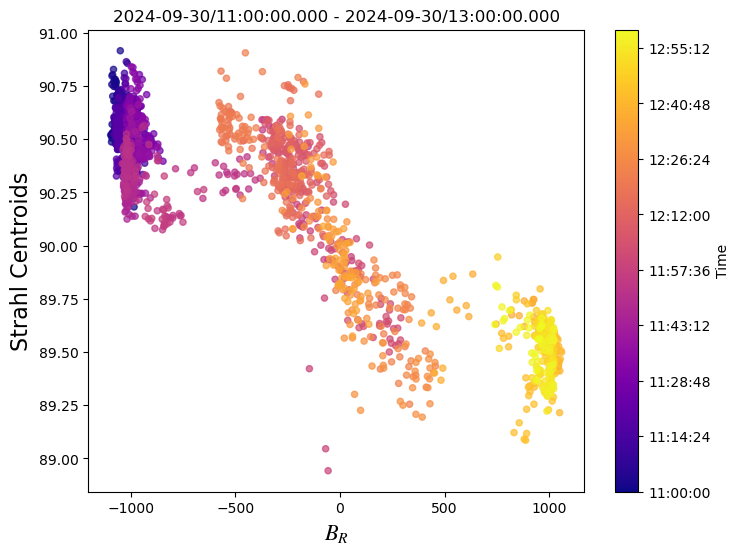

In [26]:
#NEW Showdahodo

def showdahodo(trange, var1, var2, color_var=None, norm_ = None, xlim_ = None, ylim_ = None, 
               fname = None, s_ = None, alpha_ = None, xlabel_ = None, ylabel_ = None, 
               clabel_ = None, xlog_ = None, ylog_ = None, cmap_ = None, sort = None, 
               invsort = None, lumsort = None, brazil = None, corr = None, wvpow = None, 
               rsun = None, noshow = None, face_c = None, face_a = None):
    """
    Create a hodogram plot of two variables, optionally colored by a third variable.
    Also calculates and displays the correlation coefficient and plots a trend line.
    """
    from matplotlib.colors import Normalize
    from scipy import stats
    import matplotlib.dates as mdates
    from datetime import timedelta
    import numpy as np
    from dateutil.parser import parse
    
    print("Starting showdahodo with plotbot class integration...")
    
    # ====================================================================
    # PART 1: DOWNLOAD AND PROCESS DATA (adapted from plotbot)
    # ====================================================================
    
    # Validate time range
    start_time = datetime.strptime(trange[0], '%Y-%m-%d/%H:%M:%S.%f').replace(tzinfo=timezone.utc)
    end_time = datetime.strptime(trange[1], '%Y-%m-%d/%H:%M:%S.%f').replace(tzinfo=timezone.utc)
    
    if start_time >= end_time:
        print(f"Oops! 🤗 Start time ({trange[0]}) must be before end time ({trange[1]})")
        return None
    
    # Identify required data types
    required_data_types = {var1.data_type, var2.data_type}
    if color_var is not None:
        required_data_types.add(color_var.data_type)
    
    # Download and process data for each data type
    for data_type in required_data_types:
        print(f"Processing {data_type}...")
        
        download_new_psp_data(trange, data_type)
        
        # Get class instance
        if data_type == var1.data_type:
            class_name = var1.class_name
        elif data_type == var2.data_type:
            class_name = var2.class_name
        elif color_var is not None and data_type == color_var.data_type:
            class_name = color_var.class_name
        
        class_instance = data_cubby.grab(class_name)
        
        # Check if we need to update data
        needs_import = global_tracker.is_import_needed(trange, data_type)
        needs_refresh = False
        
        if hasattr(class_instance, 'datetime_array') and class_instance.datetime_array is not None:
            cached_start = np.datetime64(class_instance.datetime_array[0], 's')
            cached_end = np.datetime64(class_instance.datetime_array[-1], 's')
            requested_start = np.datetime64(datetime.strptime(trange[0], '%Y-%m-%d/%H:%M:%S.%f'), 's')
            requested_end = np.datetime64(datetime.strptime(trange[1], '%Y-%m-%d/%H:%M:%S.%f'), 's')
            
            # Add buffer for timing differences
            buffered_start = cached_start - np.timedelta64(10, 's')
            buffered_end = cached_end + np.timedelta64(10, 's')
            
            if buffered_start > requested_start or buffered_end < requested_end:
                print(f"{data_type} - Requested time falls outside cached data range, updating...")
                needs_refresh = True

        if needs_import or needs_refresh:
            data_obj = import_data_function(trange, data_type)
            if needs_import:
                global_tracker.update_imported_range(trange, data_type)
            
            class_instance.update(data_obj)

    # Get processed variable instances
    var1_instance = data_cubby.grab(var1.class_name).get_subclass(var1.subclass_name)
    var2_instance = data_cubby.grab(var2.class_name).get_subclass(var2.subclass_name)
    color_var_instance = None
    if color_var is not None:
        color_var_instance = data_cubby.grab(color_var.class_name).get_subclass(color_var.subclass_name)
    
    # ====================================================================
    # PART 2: HELPER FUNCTIONS (from original showdahodo)
    # ====================================================================
    
    def apply_time_range(trange, time_array, values_array):
        """Extract data within specified time range."""
        # Parse time range
        start_dt = parse(trange[0])
        stop_dt = parse(trange[1])
        
        # Convert to numeric timestamps for comparison
        start_ts = mdates.date2num(start_dt)
        stop_ts = mdates.date2num(stop_dt)
        time_ts = mdates.date2num(time_array)
        
        # Find indices within time range
        indices = np.where((time_ts >= start_ts) & (time_ts <= stop_ts))[0]
        
        if len(indices) == 0:
            return np.array([]), np.array([])
            
        return time_array[indices], values_array[indices]
    
    def downsample_time_based(x_time, x_values, target_times):
        """Interpolate x_values to match target_times using simple linear interpolation."""
        # Convert datetime arrays to numeric timestamps for interpolation
        x_time_numeric = mdates.date2num(x_time)
        target_times_numeric = mdates.date2num(target_times)
        
        # Handle NaN values
        valid_mask = ~np.isnan(x_values)
        if not np.any(valid_mask):
            return np.full_like(target_times_numeric, np.nan)
            
        if not np.all(valid_mask):
            x_time_numeric = x_time_numeric[valid_mask]
            x_values = x_values[valid_mask]
        
        # Simple linear interpolation
        from scipy import interpolate
        f = interpolate.interp1d(
            x_time_numeric, x_values,
            kind='linear',
            bounds_error=False,
            fill_value='extrapolate'
        )
        
        new_values = f(target_times_numeric)
        return new_values
    
    # ====================================================================
    # PART 3: PREPARE DATA FOR PLOTTING
    # ====================================================================
    print("Preparing data for plotting...")
    
    # Extract data from class instances
    values1_full = var1_instance.data
    time1_full = var1_instance.datetime_array
    values2_full = var2_instance.data  
    time2_full = var2_instance.datetime_array

    # Save original lengths
    time1_original_len = len(time1_full)
    time2_original_len = len(time2_full)
    
    # Apply time range 
    time1_clipped, values1_clipped = apply_time_range(trange, time1_full, values1_full)
    time2_clipped, values2_clipped = apply_time_range(trange, time2_full, values2_full)
    
    # Check data availability
    if len(time1_clipped) == 0 or len(time2_clipped) == 0:
        print("No data available in the specified time range")
        return None
    
    time1_clipped_len = len(time1_clipped)
    time2_clipped_len = len(time2_clipped)
    
    # Prepare color data if provided
    if color_var is not None:
        color_values_full = color_var_instance.data
        color_time_full = color_var_instance.datetime_array
        color_time_original_len = len(color_time_full)
        
        # Apply time range to color data
        color_time_clipped, color_values_clipped = apply_time_range(trange, color_time_full, color_values_full)
        color_time_clipped_len = len(color_time_clipped)
        
        if len(color_time_clipped) == 0:
            print("No color data available in the specified time range")
            color_var = None  # Fall back to time-based coloring
            color_time_clipped = None
            color_values_clipped = None
    else:
        color_time_clipped = None
        color_values_clipped = None
        color_time_original_len = 0
        color_time_clipped_len = 0
    
    # Determine which time series has the lowest sampling rate for target_times
    lengths = {
        'time1': time1_clipped_len,
        'time2': time2_clipped_len
    }
    
    if color_var is not None:
        lengths['color_time'] = color_time_clipped_len
        
    min_length = min(lengths.values())
    
    if lengths['time1'] == min_length:
        target_times = time1_clipped
    elif lengths['time2'] == min_length:
        target_times = time2_clipped
    elif color_var is not None and lengths['color_time'] == min_length:
        target_times = color_time_clipped
    
    # Check if time arrays are equal or need resampling
    time_arrays_equal = (len(time1_clipped) == len(target_times) and 
                         np.array_equal(mdates.date2num(time1_clipped), mdates.date2num(target_times)))
    time_arrays_equal = time_arrays_equal and (len(time2_clipped) == len(target_times) and 
                        np.array_equal(mdates.date2num(time2_clipped), mdates.date2num(target_times)))
    
    if color_var is not None:
        time_arrays_equal = time_arrays_equal and (len(color_time_clipped) == len(target_times) and 
                            np.array_equal(mdates.date2num(color_time_clipped), mdates.date2num(target_times)))
    
    # Resample data if needed
    if time_arrays_equal:
        print("No resampling needed - time arrays are aligned")
        values1 = values1_clipped
        values2 = values2_clipped
        if color_var is not None:
            color_values = color_values_clipped
    else:
        print("Resampling data to align time series")
        if not np.array_equal(mdates.date2num(time1_clipped), mdates.date2num(target_times)):
            values1 = downsample_time_based(time1_clipped, values1_clipped, target_times)
        else:
            values1 = values1_clipped
            
        if not np.array_equal(mdates.date2num(time2_clipped), mdates.date2num(target_times)):
            values2 = downsample_time_based(time2_clipped, values2_clipped, target_times)
        else:
            values2 = values2_clipped
            
        if color_var is not None:
            if not np.array_equal(mdates.date2num(color_time_clipped), mdates.date2num(target_times)):
                color_values = downsample_time_based(color_time_clipped, color_values_clipped, target_times)
            else:
                color_values = color_values_clipped
    
    # Prepare colors
    if color_var is None:
        # Convert to days from first time point, which is what colorbar expects
        times_num = mdates.date2num(target_times)
        colors = times_num - times_num[0]
        color_label = 'Time'
    else:
        colors = color_values
        color_label = color_var_instance.legend_label if clabel_ is None else clabel_
    
    # ====================================================================
    # PART 4: CREATE THE HODOGRAM PLOT
    # ====================================================================
    print("Creating hodogram plot...")
    
    # Create the plot
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111)
    
    # Set default values if not specified
    s_ = 20 if s_ is None else s_
    alpha_ = 0.7 if alpha_ is None else alpha_
    norm_ = Normalize() if norm_ is None else norm_
    cmap_ = 'plasma' if cmap_ is None else cmap_
    
    # Set background color if specified
    if face_c is not None:
        ax.patch.set_facecolor(face_c)
    if face_a is not None:
        ax.patch.set_alpha(face_a)
    
    # Sort data by color if requested
    if sort is not None:
        print("Sorting by ascending color value")
        sort_c = np.argsort(colors)
        values1 = values1[sort_c]
        values2 = values2[sort_c]
        colors = colors[sort_c]
        
    if invsort is not None:
        print("Sorting by descending color value")
        sort_c = np.argsort(colors)[::-1]
        values1 = values1[sort_c]
        values2 = values2[sort_c]
        colors = colors[sort_c]
    
    # Create hodogram scatter plot
    scatter = plt.scatter(values1, values2, c=colors, cmap=cmap_, norm=norm_, s=s_, alpha=alpha_)
    cbar = plt.colorbar(scatter, label=color_label)
    cbar.solids.set(alpha=1)
    
    # Calculate correlation coefficient and add trend line
    corr_title = ''
    if corr is not None:
        # Get valid data points
        valid_mask = ~np.isnan(values1) & ~np.isnan(values2)
        
        if ((xlog_ is not None) and (ylog_ is not None)) or brazil is not None:
            # Log-scale correlation requires positive values
            log_mask = valid_mask & (values1 > 0) & (values2 > 0)
            if np.sum(log_mask) > 1:
                log_values1 = np.log10(values1[log_mask])
                log_values2 = np.log10(values2[log_mask])
                correlation = np.corrcoef(log_values1, log_values2)[0, 1]
                corr_title = f'Corr Coeff: {correlation:.2f}, '
        else:
            # Linear correlation
            if np.sum(valid_mask) > 1:
                correlation, p_value = stats.pearsonr(values1[valid_mask], values2[valid_mask])
                # Calculate trend line
                z = np.polyfit(values1[valid_mask], values2[valid_mask], 1)
                p = np.poly1d(z)
                plt.plot(values1, p(values1), ".k", alpha=0.5)  # Add trend line
                corr_title = f'Corr Coef: {correlation:.2f}, '
    
    # Format colorbar for time data
    if color_var is None:
        # Use a simple formatter for time on colorbar
        def time_formatter(x, pos):
            # x is days from first time point
            days_fraction = x
            if days_fraction >= 0 and days_fraction <= colors[-1]:
                base_date = mdates.num2date(mdates.date2num(target_times[0]))
                delta = timedelta(days=days_fraction)
                date = base_date + delta
                return date.strftime('%H:%M:%S')
            return ''
            
        cbar.ax.yaxis.set_major_formatter(plt.FuncFormatter(time_formatter))
    
    # Set axis labels
    if xlabel_ is not None:
        xlabel = xlabel_
    else:
        xlabel = var1_instance.legend_label
        
    if ylabel_ is not None:
        ylabel = ylabel_
    else:
        ylabel = var2_instance.legend_label

    plt.xlabel(xlabel, fontsize=16)
    plt.ylabel(ylabel, fontsize=16)
    
    # Set axis limits if specified
    if xlim_ is not None:
        plt.xlim(xlim_)
    if ylim_ is not None:
        plt.ylim(ylim_)
        
    # Handle brazil plot mode (instability thresholds)
    if brazil is not None:
        print("Adding instability thresholds (Brazil plot)")
        beta_par = np.arange(0, 1000, 1e-4)
        trat_parfire = 1-(.47/(beta_par - .59)**.53)
        trat_oblfire = 1-(1.4/(beta_par + .11))
        trat_protcyc = 1+(.43/(beta_par + .0004)**.42)
        trat_mirror = 1+(.77/(beta_par + .016)**.76)
        plt.plot(beta_par, trat_parfire, color='black', linestyle='dashed')
        plt.plot(beta_par, trat_oblfire, color='grey', linestyle='dashed')
        plt.plot(beta_par, trat_protcyc, color='black', linestyle='dotted')
        plt.plot(beta_par, trat_mirror, color='grey', linestyle='dotted')
        plt.loglog()
        
    # Set axis scales
    if xlog_ is not None:
        plt.xscale('log')
    if ylog_ is not None:
        plt.yscale('log')
    
    # Build title
    tname = f"{trange[0]}" + ' - ' + f"{trange[1]}"
    
    # Add radial sun distance to title if requested
    rsun_title = ''
    if rsun is not None:
        try:
            # Try to get actual distance data if available
            dist_time_clipped, dist_values_clipped = apply_time_range(trange, datetime_spi, sun_dist_rsun)    
            sun_dist_rsun_clipped_avg = np.round(np.average(dist_values_clipped), 1)
            rsun_title = f"Rs = {sun_dist_rsun_clipped_avg}, "
        except NameError:
            # Fallback if distance data not available
            rsun_title = f"Rs requested, "
    
    # Set plot title
    plt.title(rsun_title + corr_title + tname, fontsize=12)
    
    # Save figure if filename provided
    if fname is not None:
        plt.savefig(f"{fname}_brazil.png", bbox_inches='tight')
    
    # Show plot unless noshow specified
    if noshow is None:
        plt.show();
    
    return fig, ax

trange = ['2024-09-30/11:00:00.000', '2024-09-30/13:00:00.000']

showdahodo(trange, mag_rtn.br, epad.centroids);

### Exploring with Plotbot (Collapse this cell to hide the code)

In [27]:
# #E21 Glory Region! 
# print_manager.show_status = False  # Status prints, useful for status updates
# print_manager.show_debug = False   # Debug prints, helpful for debugging

# server_access.username = None # Set to None for username prompt, or enter 'your_username' to hardcode.

# trange = ['2024-09-30/11:00:00.000', '2024-09-30/13:00:00.000']
# # plotbot(trange, mag_rtn_4sa.all, 1, mag_rtn_4sa.bmag, 1, 
# #         epad_hr.strahl, 2, 
# #         proton_hr.energy_flux, 3, 
# #         proton_hr.t_perp, 4, 
# #         proton_hr.t_par, 4, proton_hr.anisotropy, '4r', 
# #         proton_hr.v_sw, 5, proton_hr.v_alfven, '5r')

# plotbot(trange, mag_rtn_4sa.all, 1, mag_rtn_4sa.bmag, 1, 
#         epad.strahl, 2, 
#         proton.energy_flux, 3, 
#         proton.t_perp, 4, 
#         proton.t_par, 4, proton.anisotropy, '4r', 
#         proton.v_sw, 5, proton.v_alfven, 5)

In [28]:
# #E21 Glory Region! 
# print_manager.show_status = False  # Status prints, useful for status updates
# print_manager.show_debug = False   # Debug prints, helpful for debugging

# server_access.username = None # Set to None for username prompt, or enter 'your_username' to hardcode.

# trange = ['2024-09-30/11:00:00.000', '2024-09-30/13:30:00.000']
# # plotbot(trange, mag_rtn_4sa.all, 1, mag_rtn_4sa.bmag, 1, 
# #         epad_hr.strahl, 2, 
# #         proton_hr.energy_flux, 3, 
# #         proton_hr.t_perp, 4, 
# #         proton_hr.t_par, 4, proton_hr.anisotropy, '4r', 
# #         proton_hr.v_sw, 5, proton_hr.v_alfven, '5r')

# plotbot(trange, mag_rtn_4sa.all, 1, mag_rtn_4sa.bmag, 1, 
#         epad.strahl, 2, 
#         proton.energy_flux, 3, 
#         proton.t_perp, 4, 
#         proton.t_par, 4, proton.anisotropy, '4r', 
#         proton.v_sw, 5, proton.v_alfven, '5r')

In [29]:
# #E21 Glory Region! 
# print_manager.show_status = False  # Status prints, useful for status updates
# print_manager.show_debug = False   # Debug prints, helpful for debugging

# server_access.username = None # Set to None for username prompt, or enter 'your_username' to hardcode.

# epad.strahl.colorbar_limits = [10.4, 11]
# epad.strahl.colorbar_scale = 'log'

# trange = ['2024-09-30/11:45:00.000', '2024-09-30/12:45:00.000']
# # plotbot(trange, mag_rtn_4sa.all, 1, mag_rtn_4sa.bmag, 1, 
# #         epad_hr.strahl, 2, 
# #         proton_hr.energy_flux, 3, 
# #         proton_hr.t_perp, 4, 
# #         proton_hr.t_par, 4, proton_hr.anisotropy, '4r', 
# #         proton_hr.v_sw, 5, proton_hr.v_alfven, '5r')

# plotbot(trange, mag_rtn_4sa.all, 1, mag_rtn_4sa.bmag, 1, 
#         epad.strahl, 2, 
#         proton.energy_flux, 3, 
#         proton.t_perp, 4, 
#         proton.t_par, 4, proton.anisotropy, '4r', 
#         proton.v_sw, 5, proton.v_alfven, 5)

In [30]:
# #E21 Glory Region! 
# print_manager.show_status = False  # Status prints, useful for status updates
# print_manager.show_debug = False   # Debug prints, helpful for debugging

# server_access.username = None # Set to None for username prompt, or enter 'your_username' to hardcode.

# epad.strahl.colorbar_limits = [10.4, 11]
# epad.strahl.colorbar_scale = 'log'

# trange = ['2024-09-30/11:50:00.000', '2024-09-30/12:00:00.000']
# # plotbot(trange, mag_rtn_4sa.all, 1, mag_rtn_4sa.bmag, 1, 
# #         epad_hr.strahl, 2, 
# #         proton_hr.energy_flux, 3, 
# #         proton_hr.t_perp, 4, 
# #         proton_hr.t_par, 4, proton_hr.anisotropy, '4r', 
# #         proton_hr.v_sw, 5, proton_hr.v_alfven, '5r')

# plotbot(trange, mag_rtn_4sa.all, 1, mag_rtn_4sa.bmag, 1, 
#         epad.strahl, 2, 
#         proton.energy_flux, 3, 
#         proton.t_perp, 4, 
#         proton.t_par, 4, proton.anisotropy, '4r', 
#         proton.v_sw, 5, proton.v_alfven, 5)

In [31]:
# #E21 Glory Region! 
# print_manager.show_status = False  # Status prints, useful for status updates
# print_manager.show_debug = False   # Debug prints, helpful for debugging

# server_access.username = None # Set to None for username prompt, or enter 'your_username' to hardcode.

# epad.strahl.colorbar_limits = [10.4, 11]
# epad.strahl.colorbar_scale = 'log'

# trange = ['2024-09-30/11:50:00.000', '2024-09-30/12:00:00.000']
# # plotbot(trange, mag_rtn_4sa.all, 1, mag_rtn_4sa.bmag, 1, 
# #         epad_hr.strahl, 2, 
# #         proton_hr.energy_flux, 3, 
# #         proton_hr.t_perp, 4, 
# #         proton_hr.t_par, 4, proton_hr.anisotropy, '4r', 
# #         proton_hr.v_sw, 5, proton_hr.v_alfven, '5r')

# plotbot(trange, mag_rtn_4sa.all, 1, mag_rtn_4sa.bmag, 1, 
#         epad.strahl, 2, 
#         proton.energy_flux, 3, 
#         proton.theta_flux, 4, 
#         proton.phi_flux, 5, 
#         proton.t_perp, 6, 
#         proton.t_par, 6, proton.anisotropy, '6r', 
#         proton.v_sw, 7, proton.v_alfven, 7)

In [32]:
# #E21 Glory Region! 
# print_manager.show_status = False  # Status prints, useful for status updates
# print_manager.show_debug = False   # Debug prints, helpful for debugging

# server_access.username = None # Set to None for username prompt, or enter 'your_username' to hardcode.

# epad.strahl.colorbar_limits = [10.4, 11]
# epad.strahl.colorbar_scale = 'log'

# trange = ['2024-09-30/11:50:00.000', '2024-09-30/12:00:00.000']
# # plotbot(trange, mag_rtn_4sa.all, 1, mag_rtn_4sa.bmag, 1, 
# #         epad_hr.strahl, 2, 
# #         proton_hr.energy_flux, 3, 
# #         proton_hr.t_perp, 4, 
# #         proton_hr.t_par, 4, proton_hr.anisotropy, '4r', 
# #         proton_hr.v_sw, 5, proton_hr.v_alfven, '5r')

# plotbot(trange, mag_rtn_4sa.br, 1, mag_rtn_4sa.bmag, 1, 
#         mag_rtn_4sa.bt, 2, mag_rtn_4sa.bn, 2, 
#         epad.strahl, 3, 
#         proton.energy_flux, 4, 
#         proton.theta_flux, 5, 
#         proton.phi_flux, 6, 
#         proton.t_perp, 7, 
#         proton.t_par, 7, proton.anisotropy, '7r', 
#         proton.v_sw, 8, proton.v_alfven, 8)

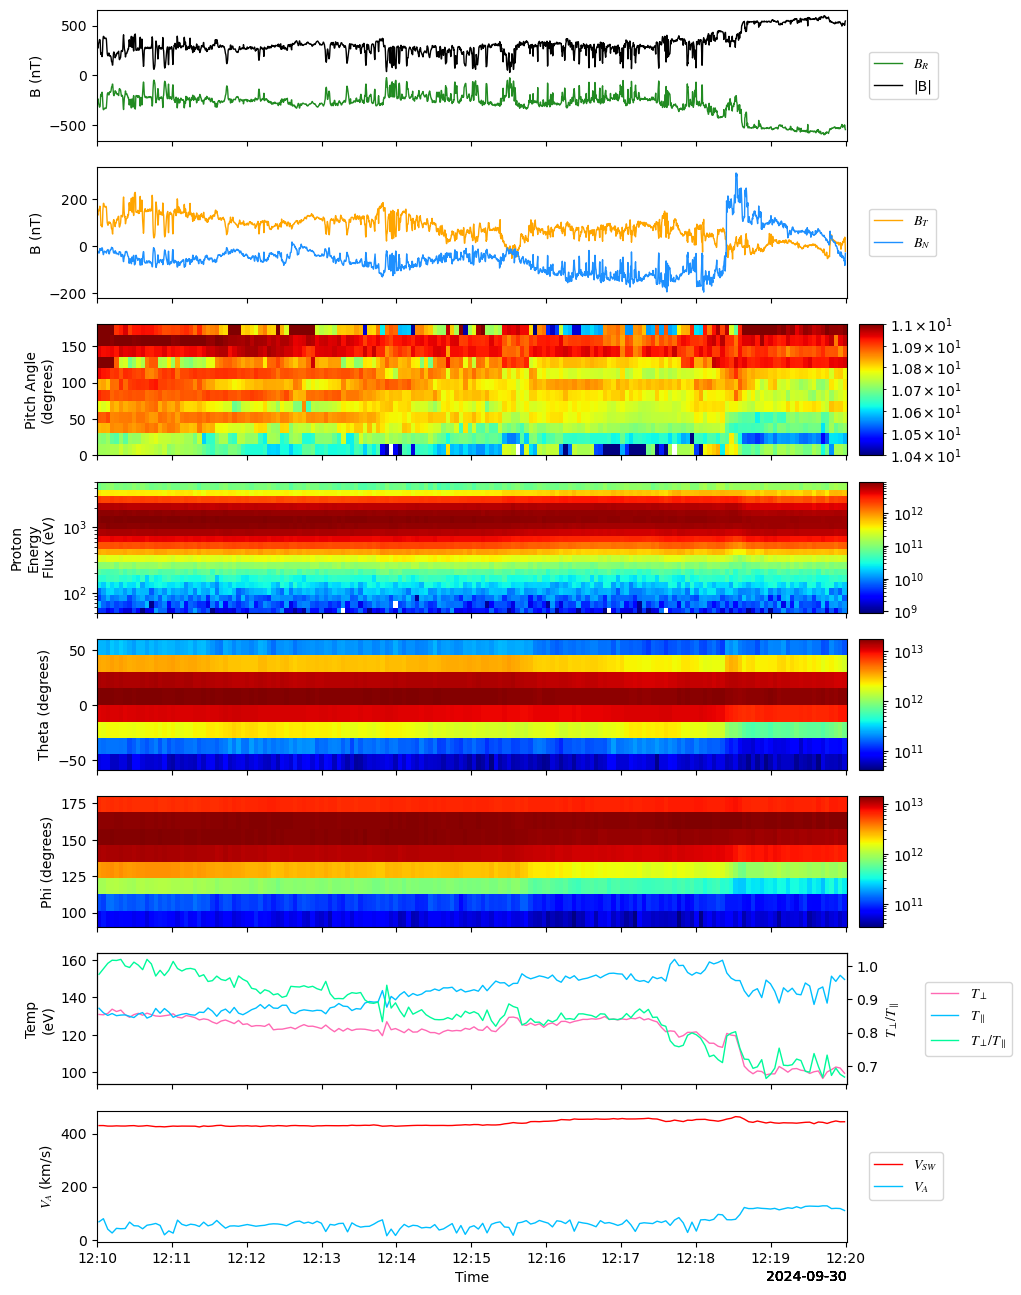

In [33]:
#E21 Glory Region! 
print_manager.show_status = False  # Status prints, useful for status updates
print_manager.show_debug = False   # Debug prints, helpful for debugging

server_access.username = None # Set to None for username prompt, or enter 'your_username' to hardcode.

epad.strahl.colorbar_limits = [10.4, 11]
epad.strahl.colorbar_scale = 'log'

trange = ['2024-09-30/12:10:00.000', '2024-09-30/12:20:00.000']
# plotbot(trange, mag_rtn_4sa.all, 1, mag_rtn_4sa.bmag, 1, 
#         epad_hr.strahl, 2, 
#         proton_hr.energy_flux, 3, 
#         proton_hr.t_perp, 4, 
#         proton_hr.t_par, 4, proton_hr.anisotropy, '4r', 
#         proton_hr.v_sw, 5, proton_hr.v_alfven, '5r')

plotbot(trange, mag_rtn_4sa.br, 1, mag_rtn_4sa.bmag, 1, 
        mag_rtn_4sa.bt, 2, mag_rtn_4sa.bn, 2, 
        epad.strahl, 3, 
        proton.energy_flux, 4, 
        proton.theta_flux, 5, 
        proton.phi_flux, 6, 
        proton.t_perp, 7, 
        proton.t_par, 7, proton.anisotropy, '7r', 
        proton.v_sw, 8, proton.v_alfven, 8)

Authentication required for https://sprg.ssl.berkeley.edu/data/psp/data/sci/fields/l2/mag_SC_4_Sa_per_Cyc/2024/09/
Authentication required for https://sprg.ssl.berkeley.edu/data/psp/data/sci/fields/l2/mag_SC_4_Sa_per_Cyc/2024/09/
🤷🏾‍♂️ The data you're looking for can't be retrieved from the server, friend!
An error occurred: 'NoneType' object has no attribute 'status_code'
Directory does not exist!
No data files found in the specified time range.


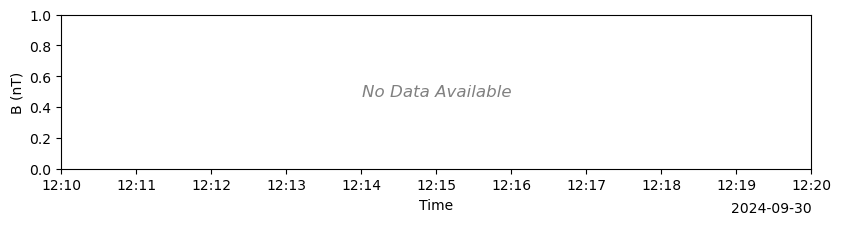

In [34]:
trange = ['2024-09-30/12:10:00.000', '2024-09-30/12:20:00.000']
# trange = ['2024-09-30/12:16:00.000', '2024-09-30/12:17:00.000']


mag_rtn.br.color = 'blue'
plotbot(trange, mag_sc_4sa.all, 1)

In [35]:
# #E21 Glory Region! 
# print_manager.show_status = False  # Status prints, useful for status updates
# print_manager.show_debug = False   # Debug prints, helpful for debugging

# server_access.username = None # Set to None for username prompt, or enter 'your_username' to hardcode.

# epad.strahl.colorbar_limits = [10.4, 11]
# epad.strahl.colorbar_scale = 'log'

# trange = ['2024-09-30/12:13:00.000', '2024-09-30/12:18:00.000']
# # plotbot(trange, mag_rtn_4sa.all, 1, mag_rtn_4sa.bmag, 1, 
# #         epad_hr.strahl, 2, 
# #         proton_hr.energy_flux, 3, 
# #         proton_hr.t_perp, 4, 
# #         proton_hr.t_par, 4, proton_hr.anisotropy, '4r', 
# #         proton_hr.v_sw, 5, proton_hr.v_alfven, '5r')

# plotbot(trange, mag_rtn_4sa.all, 1, mag_rtn_4sa.bmag, 1, 
#         epad.strahl, 2, 
#         proton.energy_flux, 3, 
#         proton.theta_flux, 4, 
#         proton.phi_flux, 5, 
#         proton.t_perp, 6, 
#         proton.t_par, 6, proton.anisotropy, '6r', 
#         proton.v_sw, 7, proton.v_alfven, 7)

In [36]:
# #E21 Glory Region! 
# print_manager.show_status = False  # Status prints, useful for status updates
# print_manager.show_debug = False   # Debug prints, helpful for debugging

# server_access.username = None # Set to None for username prompt, or enter 'your_username' to hardcode.

# epad.strahl.colorbar_limits = [10.4, 11]
# epad.strahl.colorbar_scale = 'log'

# trange = ['2024-09-30/12:15:00.000', '2024-09-30/12:16:00.000']
# # plotbot(trange, mag_rtn_4sa.all, 1, mag_rtn_4sa.bmag, 1, 
# #         epad_hr.strahl, 2, 
# #         proton_hr.energy_flux, 3, 
# #         proton_hr.t_perp, 4, 
# #         proton_hr.t_par, 4, proton_hr.anisotropy, '4r', 
# #         proton_hr.v_sw, 5, proton_hr.v_alfven, '5r')

# plotbot(trange, mag_rtn.br, 1, mag_rtn.bmag, 1, 
#         mag_rtn.bt, 2, mag_rtn.bn, 2,
#         epad.strahl, 3, 
#         proton.energy_flux, 4, 
#         proton.theta_flux, 5, 
#         proton.phi_flux, 6, 
#         proton.t_perp, 7, 
#         proton.t_par, 7, proton.anisotropy, '7r', 
#         proton.v_sw, 8, proton.v_alfven, 8)

In [37]:
# #E21 Glory Region! 
# print_manager.show_status = False  # Status prints, useful for status updates
# print_manager.show_debug = False   # Debug prints, helpful for debugging

# server_access.username = None # Set to None for username prompt, or enter 'your_username' to hardcode.

# epad.strahl.colorbar_limits = [10.4, 11]
# epad.strahl.colorbar_scale = 'log'
# proton.energy_flux.colorbar_scale = 'log'
# proton.theta_flux.colorbar_scale = 'log'
# proton.phi_flux.colorbar_scale = 'log'

# trange = ['2024-09-29/03:00:00.000', '2024-09-30/20:00:00.000']
# # plotbot(trange, mag_rtn_4sa.all, 1, mag_rtn_4sa.bmag, 1, 
# #         epad_hr.strahl, 2, 
# #         proton_hr.energy_flux, 3, 
# #         proton_hr.t_perp, 4, 
# #         proton_hr.t_par, 4, proton_hr.anisotropy, '4r', 
# #         proton_hr.v_sw, 5, proton_hr.v_alfven, '5r')

# plotbot(trange, mag_rtn_4sa.br, 1, mag_rtn_4sa.bmag, 1, 
#         mag_rtn_4sa.bt, 2, mag_rtn_4sa.bn, 2,
#         epad.strahl, 3, 
#         proton.energy_flux, 4, 
#         proton.theta_flux, 5, 
#         proton.phi_flux, 6, 
#         proton.t_perp, 7, 
#         proton.t_par, 7, proton.anisotropy, '7r', 
#         proton.v_sw, 8, proton.v_alfven, '8r')

In [38]:
# #E20 Exploring
# print_manager.show_status = False  # Status prints, useful for status updates
# print_manager.show_debug = False   # Debug prints, helpful for debugging

# server_access.username = None # Set to None for username prompt, or enter 'your_username' to hardcode.

# # epad.strahl.colorbar_limits = [10.4, 11]
# epad.strahl.colorbar_limits = 'default'
# epad.strahl.colorbar_scale = 'log'
# proton.energy_flux.colorbar_scale = 'log'
# proton.theta_flux.colorbar_scale = 'log'
# proton.phi_flux.colorbar_scale = 'log'

# trange = ['2024-06-29/11:00:00.000', '2024-06-29/14:00:00.000']
# # plotbot(trange, mag_rtn_4sa.all, 1, mag_rtn_4sa.bmag, 1, 
# #         epad_hr.strahl, 2, 
# #         proton_hr.energy_flux, 3, 
# #         proton_hr.t_perp, 4, 
# #         proton_hr.t_par, 4, proton_hr.anisotropy, '4r', 
# #         proton_hr.v_sw, 5, proton_hr.v_alfven, '5r')

# plotbot(trange, mag_rtn_4sa.br, 1, mag_rtn_4sa.bmag, 1, 
#         mag_rtn_4sa.bt, 2, mag_rtn_4sa.bn, 2,
#         epad.strahl, 3, 
#         proton.energy_flux, 4, 
#         proton.theta_flux, 5, 
#         proton.phi_flux, 6, 
#         proton.t_perp, 7, 
#         proton.t_par, 7, proton.anisotropy, '7r', 
#         proton.v_sw, 8, proton.v_alfven, '8r')

In [39]:
# #E20 Exploring
# print_manager.show_status = False  # Status prints, useful for status updates
# print_manager.show_debug = False   # Debug prints, helpful for debugging

# server_access.username = None # Set to None for username prompt, or enter 'your_username' to hardcode.

# # epad.strahl.colorbar_limits = [10.4, 11]
# epad.strahl.colorbar_limits = 'default'
# epad.strahl.colorbar_scale = 'log'
# proton.energy_flux.colorbar_scale = 'log'
# proton.theta_flux.colorbar_scale = 'log'
# proton.phi_flux.colorbar_scale = 'log'

# trange = ['2024-06-29/12:00:00.000', '2024-06-29/12:45:00.000']
# # plotbot(trange, mag_rtn_4sa.all, 1, mag_rtn_4sa.bmag, 1, 
# #         epad_hr.strahl, 2, 
# #         proton_hr.energy_flux, 3, 
# #         proton_hr.t_perp, 4, 
# #         proton_hr.t_par, 4, proton_hr.anisotropy, '4r', 
# #         proton_hr.v_sw, 5, proton_hr.v_alfven, '5r')

# plotbot(trange, mag_rtn_4sa.br, 1, mag_rtn_4sa.bmag, 1, 
#         mag_rtn_4sa.bt, 2, mag_rtn_4sa.bn, 2,
#         epad.strahl, 3, 
#         proton.energy_flux, 4, 
#         proton.theta_flux, 5, 
#         proton.phi_flux, 6, 
#         proton.t_perp, 7, 
#         proton.t_par, 7, proton.anisotropy, '7r', 
#         proton.v_sw, 8, proton.v_alfven, '8r')

In [40]:
# #E21 Glory Region WAVES
# print_manager.show_status = True  # Status prints, useful for status updates
# print_manager.show_debug = False   # Debug prints, helpful for debugging

# server_access.username = None  # Set to None for username prompt, or enter 'your_username' to hardcode.

# # trange = ['2024-09-30/12:13:30.000', '2024-09-30/12:18:00.000']
# trange = ['2024-09-30/12:09:45.000', '2024-09-30/12:10:00.000']
# # trange = ['2024-09-30/12:09:00.000', '2024-09-30/12:11:00.000']
# plotbot(trange, mag_rtn.bmag, 1, mag_rtn.br, 2, mag_rtn.bt, 3, mag_rtn.bn, 4)
#         # epad_hr.strahl, 2, 
#         # proton_hr.energy_flux, 3, 
#         # proton_hr.t_perp, 4, 
#         # proton_hr.t_par, 4, proton_hr.anisotropy, '4r', 
#         # proton_hr.v_sw, 5, proton_hr.v_alfven, '5r')


In [41]:
# #E21 Glory Region WAVES
# print_manager.show_status = True  # Status prints, useful for status updates
# print_manager.show_debug = False   # Debug prints, helpful for debugging

server_access.username = None # Set to None for username prompt, or enter 'your_username' to hardcode.

# # trange = ['2024-09-30/12:13:30.000', '2024-09-30/12:18:00.000']
# trange = ['2024-09-30/11:15:00.000', '2024-09-30/11:45:00.000']
# # trange = ['2024-09-30/12:09:00.000', '2024-09-30/12:11:00.000']
# plotbot(trange, mag_rtn.bmag, 1, mag_rtn.all, '1r',
#         proton_hr.temperature, 2, proton_hr.density, 3,
#         epad_hr.strahl, 4, 
#         proton_hr.energy_flux, 5, 
#         proton_hr.t_perp, 6, proton_hr.anisotropy, '6r', 
#         proton_hr.v_sw, 7, proton_hr.v_alfven, '7r')


In [42]:
# #A classic mutli-plot!
# print_manager.show_status = True  # Status prints, useful for status updates
# print_manager.show_debug = False   # Debug prints, helpful for debugging

# server_access.username = None  # Set to None for username prompt, or enter 'your_username' to hardcode.

# trange = ['2023-09-28/06:00:00.000', '2023-09-28/07:30:00.000']
# plotbot(trange, mag_rtn.all, 1, mag_rtn_4sa.bmag, 1, 
#         epad.strahl, 2, 
#         proton.energy_flux, 3, 
#         proton.t_perp, 4, 
#         proton.t_par, 4, proton.anisotropy, '4r', 
#         proton.v_sw, 5, proton.v_alfven, '5r')


### --------> ✨✨Multiplot!✨✨ <--------

In [43]:
class MultiplotOptions:
    """Configuration options for the multiplot function, including per-axis customization."""
    
    # Make axes a class-level attribute
    axes = {}

    class RightAxisOptions:
        """Stores right-axis specific options."""
        def __init__(self):
            self.y_limit = None
            self.color = None

    class AxisOptions:
        """Stores per-axis options like y_limit and color."""
        def __init__(self):
            self.y_limit = None
            self.color = None
            self.r = MultiplotOptions.RightAxisOptions()  # Add right axis options

    def __init__(self):
        # No need to initialize axes here since it's a class attribute
        self.reset()

    def reset(self):
        """Reset all options to their default values."""
        # Clear existing axes
        MultiplotOptions.axes.clear()
        
        # General plotting options
        self.window = '00:12:00.000'
        self.position = 'around'
        self.width = 22
        self.height_per_panel = 3
        self.hspace = 0.5
        self.title_fontsize = 12
        self.use_single_title = True
        self.single_title_text = None
        self.draw_vertical_line = False
        self.vertical_line_width = 1.0
        self.vertical_line_color = 'red'
        self.vertical_line_style = ':'
        self.use_relative_time = False
        self.relative_time_step_units = 'hours'
        self.relative_time_step = 2
        self.use_single_x_axis = True
        self.use_custom_x_axis_label = False
        self.custom_x_axis_label = None
        self.y_label_uses_encounter = True
        self.y_label_includes_time = True
        self.y_label_size = 11
        self.x_label_size = 11
        self.y_label_pad = 20
        self.x_tick_label_size = 10
        self.y_tick_label_size = 10
        self.second_variable_on_right_axis = False
        
        # New color mode options
        self.color_mode = 'default'  # Options: 'default', 'rainbow', 'single'
        self.single_color = None     # Used when color_mode = 'single'
        
        # Clear any dynamically created axis attributes
        for attr in list(self.__dict__.keys()):
            if attr.startswith('ax'):
                delattr(self, attr)
                
    def __getattr__(self, name):
        """Dynamically create ax1, ax2, etc. as attributes when accessed."""
        if name.startswith('ax'):
            try:
                axis_number = int(name[2:])
                print_manager.debug(f"Accessing axis {name}")
                if axis_number not in MultiplotOptions.axes:
                    print_manager.debug(f"Creating new axis options for {name}")
                    MultiplotOptions.axes[axis_number] = self.AxisOptions()
                    setattr(self, name, MultiplotOptions.axes[axis_number])
                else:
                    print_manager.debug(f"Using existing axis options for {name}")
                return MultiplotOptions.axes[axis_number]
            except ValueError:
                pass
        raise AttributeError(f"'{type(self).__name__}' object has no attribute '{name}'")

    def print_state(self):
        """Print current state of options"""
        print("\nMultiplotOptions current state:")
        for key, value in self.__dict__.items():
            if key != 'axes':
                print(f"{key}: {value}")
        print("\nAxis-specific options:")
        for axis_num, axis_opts in MultiplotOptions.axes.items():
            print(f"ax{axis_num}:")
            print(f"  y_limit: {axis_opts.y_limit}")
            print(f"  color: {axis_opts.color}")
            print(f"  right y_limit: {axis_opts.r.y_limit}")
            print(f"  right color: {axis_opts.r.color}")

# Create global instance
plt.options = MultiplotOptions()

In [44]:
def multiplot(plot_list, **kwargs):
    """
    Create multiple time-series plots centered around specific times.
    Uses global plt.options for defaults, with kwargs allowing parameter override.
    
    Args:
        plot_list: List of tuples (time, variable)
        **kwargs: Optional overrides for any MultiplotOptions attributes
    """
    # ====================================================================
    # Initialize options and settings
    # ====================================================================
    # Get options instance
    options = plt.options
    
    # Override any options with provided kwargs
    for key, value in kwargs.items():
        if hasattr(options, key):
            setattr(options, key, value)
    
    print_manager.debug("\n=== Starting Multiplot Function ===")
    print_manager.debug(f"Window: {options.window}, Position: {options.position}")
    
    # Convert window to timedelta
    window_td = pd.Timedelta(options.window)
    print_manager.debug(f"Window timedelta: {window_td}")
    
    # Calculate number of panels needed
    n_panels = len(plot_list)
    print_manager.debug(f"Number of panels: {n_panels}")
    
    # Create figure with subplots
    print_manager.debug("\nCreating figure...")
    fig, axs = plt.subplots(n_panels, 1, 
                           figsize=(options.width, options.height_per_panel*n_panels), 
                           sharex=False)
    
    if n_panels == 1:
        axs = [axs]
    
    # Adjust subplot spacing
    plt.subplots_adjust(right=0.85, hspace=options.hspace)
    
    # Get color scheme if using rainbow or single color mode
    color_scheme = get_plot_colors(n_panels, options.color_mode, options.single_color)

    # # If using rainbow or single color mode and using single title
    # if color_scheme and options.use_single_title:
    #     fig.suptitle(options.single_title_text,
    #                 # y=options.title_position_y,
    #                 size=options.title_fontsize,
    #                 weight='bold',
    #                 color=color_scheme['title_color'])

    # Position descriptions
    pos_desc = {
        'before': 'Region before',
        'around': 'Region around',
        'after': 'Region after'
    }
    
    # ====================================================================
    # Configure Time Windows and Process Data for Each Panel
    # ====================================================================
    for i, (center_time, var) in enumerate(plot_list):  # Iterate over plot_list with index i, unpacking each tuple into center_time and var
        print_manager.status('Adding data to plot... \n')
        print_manager.debug(f"\n=== Processing Panel {i+1}/{n_panels} ===")
        print_manager.debug(f"Center time: {center_time}")
        center_dt = pd.Timestamp(center_time)  # Convert center_time to datetime object
        
        # Get encounter number automatically
        enc_num = get_encounter_number(center_time)

        # Format time range
        if options.position == 'around':
            start_time = center_dt - window_td/2
            end_time = center_dt + window_td/2
        elif options.position == 'before':
            start_time = center_dt - window_td
            end_time = center_dt
        else:  # after
            start_time = center_dt
            end_time = center_dt + window_td

        trange = [
            start_time.strftime('%Y-%m-%d/%H:%M:%S.%f'),
            end_time.strftime('%Y-%m-%d/%H:%M:%S.%f')
        ]

        # ====================================================================
        # Multi-Variable Plot Type Handling (time_series only)
        # ====================================================================
        if isinstance(var, list):  # Check if 'var' is a list
            # Process each variable separately
            processed_vars = []
            for single_var in var:
                # Create plot request for this variable
                plot_request = {
                    'data_type': single_var.data_type,
                    'class_name': single_var.class_name,
                    'subclass_name': single_var.subclass_name,
                    'axis_spec': 1
                }
                
                print_manager.debug(f"\nProcessing {plot_request['data_type']} - {plot_request['subclass_name']}")
                
                # Download and process data for each variable
                download_new_psp_data(trange, plot_request['data_type'])
                
                # Get class instance for this variable
                class_instance = data_cubby.grab(plot_request['class_name'])
                
                # Check if we need to import or refresh data
                needs_import = global_tracker.is_import_needed(trange, plot_request['data_type'])
                needs_refresh = False

                if hasattr(class_instance, 'datetime_array') and class_instance.datetime_array is not None:
                    cached_start = np.datetime64(class_instance.datetime_array[0], 's')
                    cached_end = np.datetime64(class_instance.datetime_array[-1], 's')
                    requested_start = np.datetime64(start_time, 's')
                    requested_end = np.datetime64(end_time, 's')

                    buffered_start = cached_start - np.timedelta64(10, 's')
                    buffered_end = cached_end + np.timedelta64(10, 's')

                    if buffered_start > requested_start or buffered_end < requested_end:
                        needs_refresh = True

                if needs_import or needs_refresh:
                    data_obj = import_data_function(trange, plot_request['data_type'])
                    if needs_import:
                        global_tracker.update_imported_range(trange, plot_request['data_type'])
                    if data_obj is not None:
                        class_instance.update(data_obj)

                # Get updated variable
                processed_var = class_instance.get_subclass(plot_request['subclass_name'])
                processed_vars.append(processed_var)
            
            var = processed_vars
        else:
            # ====================================================================
            # Single Variable Plot Type Handling (time_series only)
            # ====================================================================
            plot_request = {
                'data_type': var.data_type,
                'class_name': var.class_name,
                'subclass_name': var.subclass_name,
                'axis_spec': 1
            }
            
            print_manager.debug(f"\nProcessing {plot_request['data_type']} - {plot_request['subclass_name']}")
            
            # Original single variable processing
            download_new_psp_data(trange, plot_request['data_type'])
            class_instance = data_cubby.grab(plot_request['class_name'])
            
            needs_import = global_tracker.is_import_needed(trange, plot_request['data_type'])
            needs_refresh = False

            if hasattr(class_instance, 'datetime_array') and class_instance.datetime_array is not None:
                cached_start = np.datetime64(class_instance.datetime_array[0], 's')
                cached_end = np.datetime64(class_instance.datetime_array[-1], 's')
                requested_start = np.datetime64(start_time, 's')
                requested_end = np.datetime64(end_time, 's')

                buffered_start = cached_start - np.timedelta64(10, 's')
                buffered_end = cached_end + np.timedelta64(10, 's')

                if buffered_start > requested_start or buffered_end < requested_end:
                    needs_refresh = True

            if needs_import or needs_refresh:
                data_obj = import_data_function(trange, plot_request['data_type'])
                if needs_import:
                    global_tracker.update_imported_range(trange, plot_request['data_type'])
                if data_obj is not None:
                    class_instance.update(data_obj)

            var = class_instance.get_subclass(plot_request['subclass_name'])

        # ====================================================================
        # Plot Variables (Multi-Variable) with Plot Type Handling
        # ====================================================================
        # Get panel color if using color scheme
        panel_color = color_scheme['panel_colors'][i] if color_scheme else None
        
        if isinstance(var, list):
            # Get axis-specific options for this panel
            axis_options = getattr(options, f'ax{i+1}')
            
            for idx, single_var in enumerate(var):
                indices = time_clip(single_var.datetime_array, trange[0], trange[1])
                if len(indices) > 0:
                    if idx == 1 and options.second_variable_on_right_axis:
                        # Second variable - use right axis
                        ax2 = axs[i].twinx()
                        
                        # Color priority for right axis:
                        # 1. Panel color (if in rainbow/single mode)
                        # 2. Right axis color if specified
                        # 3. Variable's own color
                        if options.color_mode in ['rainbow', 'single'] and panel_color:
                            plot_color = panel_color
                        elif hasattr(axis_options, 'r') and axis_options.r.color is not None:
                            plot_color = axis_options.r.color
                        else:
                            plot_color = single_var.color

                        ax2.plot(single_var.datetime_array[indices], 
                                single_var.data[indices],
                                linewidth=single_var.line_width,
                                linestyle=single_var.line_style,
                                label=single_var.legend_label,
                                color=plot_color)
                        
                        # Apply right axis y-limits if specified
                        if hasattr(axis_options, 'r') and axis_options.r.y_limit is not None:
                            ax2.set_ylim(axis_options.r.y_limit)
                        
                        if panel_color:
                            apply_panel_color(ax2, panel_color, options)
                    
                    else:
                        # First variable - use left axis
                        # Color priority for left axis:
                        # 1. Panel color (if in rainbow/single mode)
                        # 2. Variable's own color
                        # 3. Axis color if specified
                        if options.color_mode in ['rainbow', 'single'] and panel_color:
                            plot_color = panel_color
                        elif hasattr(single_var, 'color') and single_var.color is not None:
                            plot_color = single_var.color
                        elif axis_options.color is not None:
                            plot_color = axis_options.color
                        else:
                            plot_color = None

                        axs[i].plot(single_var.datetime_array[indices], 
                                   single_var.data[indices],
                                   linewidth=single_var.line_width,
                                   linestyle=single_var.line_style,
                                   label=single_var.legend_label,
                                   color=plot_color)
                        
                        if panel_color:
                            apply_panel_color(axs[i], panel_color, options)
            
            if len(var) > 1:
                # Adjust legend to show both variables
                lines_left, labels_left = axs[i].get_legend_handles_labels()
                if options.second_variable_on_right_axis:
                    lines_right, labels_right = ax2.get_legend_handles_labels()
                    # Place legend outside plot area on the right
                    axs[i].legend(lines_left + lines_right, 
                                  labels_left + labels_right,
                                  bbox_to_anchor=(1.025, 1),
                                  loc='upper left')
                else:
                    axs[i].legend(bbox_to_anchor=(1.025, 1),
                                  loc='upper left')
        else:
            
            # ====================================================================
            # Plot Single Variables (time_series or spectral)
            # ====================================================================
            
            # Get axis-specific options for this panel
            axis_options = getattr(options, f'ax{i+1}')
            indices = time_clip(var.datetime_array, trange[0], trange[1])
            if len(indices) > 0:
                if hasattr(var, 'plot_type'):
                    if var.plot_type == 'time_series':
                        # Time series plotting with all existing options
                        axs[i].plot(var.datetime_array[indices], 
                                         var.data[indices],
                                         linewidth=var.line_width,
                                         linestyle=var.line_style,
                                         color=panel_color if panel_color else axis_options.color)
                        if panel_color:
                            apply_panel_color(axs[i], panel_color, options)

                    elif var.plot_type == 'spectral':
                        datetime_clipped = var.datetime_array[indices]
                        data_clipped = np.array(var.data)[indices]
                        additional_data_clipped = np.array(var.additional_data)[indices]
                        
                        # Determine color normalization
                        colorbar_limits = axis_options.colorbar_limits if hasattr(axis_options, 'colorbar_limits') and axis_options.colorbar_limits else var.colorbar_limits
                        if var.colorbar_scale == 'log':
                            norm = colors.LogNorm(vmin=colorbar_limits[0], vmax=colorbar_limits[1]) if colorbar_limits else colors.LogNorm()
                        elif var.colorbar_scale == 'linear':
                            norm = colors.Normalize(vmin=colorbar_limits[0], vmax=colorbar_limits[1]) if colorbar_limits else None

                        # Spectral plot
                        im = axs[i].pcolormesh(datetime_clipped, additional_data_clipped, data_clipped,
                                               norm=norm, cmap=var.colormap, shading='auto')
                        
                        # Colorbar Positioning
                        pos = axs[i].get_position()
                        cax = fig.add_axes([pos.x1 + 0.01, pos.y0, 0.02, pos.height])
                        cbar = fig.colorbar(im, cax=cax)

                        if hasattr(var, 'colorbar_label'):
                            cbar.set_label(var.colorbar_label)
                else:
                    # Default to time series if no plot_type specified
                    axs[i].plot(var.datetime_array[indices], 
                                     var.data[indices],
                                     linewidth=var.line_width,
                                     linestyle=var.line_style,
                                     color=panel_color if panel_color else axis_options.color)
                    if panel_color:
                        apply_panel_color(axs[i], panel_color, options)

        # ====================================================================
        # Common Axis Handling
        # ====================================================================
        # Set y-limits with priority order: axis options > variable limits
        if axis_options.y_limit:
            axs[i].set_ylim(axis_options.y_limit)
        elif isinstance(var, list):
            # For multiple variables, find common y-limits if needed
            all_data = []
            for single_var in var:
                if hasattr(single_var, 'y_limit') and single_var.y_limit:
                    all_data.extend(single_var.y_limit)
            if all_data:
                axs[i].set_ylim(min(all_data), max(all_data))
        elif hasattr(var, 'y_limit') and var.y_limit:
            axs[i].set_ylim(var.y_limit)
        else:
            print_manager.debug("Debug: 'additional_data' or 'datetime_array' attributes not found.")

        axs[i].set_xlim(start_time, end_time)

        # Set axis properties
        if isinstance(var, list):
            # For multiple variables, combine their y-labels or use the first one
            if all(hasattr(v, 'y_label') for v in var):
                # Option 1: Use first variable's label
                y_label = var[0].y_label
                # Option 2: Combine labels (uncomment if you prefer this)
                # y_label = ' / '.join(v.y_label for v in var)
            else:
                y_label = ''
        else:
            y_label = var.y_label

        # Handle y-label formatting
        if options.y_label_uses_encounter:
            if options.y_label_includes_time:
                y_label = f"{enc_num} Around\n{pd.Timestamp(center_time).strftime('%Y-%m-%d')}\n{pd.Timestamp(center_time).strftime('%H:%M')}"
                axs[i].set_ylabel(y_label, fontsize=options.y_label_size, 
                                  labelpad=options.y_label_pad)
            else:
                y_label = f"$\\mathbf{{{enc_num}}}$"
                axs[i].set_ylabel(y_label, fontsize=options.y_label_size,
                                  rotation=0, ha='right', va='center',
                                  labelpad=options.y_label_pad)
        else:
            axs[i].set_ylabel(y_label, fontsize=options.y_label_size,
                              labelpad=options.y_label_pad)

        # Handle y-scale
        if isinstance(var, list):
            # Use first variable's y_scale if available
            if hasattr(var[0], 'y_scale') and var[0].y_scale:
                axs[i].set_yscale(var[0].y_scale)
        elif hasattr(var, 'y_scale') and var.y_scale:
            axs[i].set_yscale(var.y_scale)

        # ====================================================================
        # Handle Time Axis
        # ====================================================================
        if options.use_relative_time:
            # Calculate relative time ticks
            step_td = pd.Timedelta(value=options.relative_time_step, unit=options.relative_time_step_units)
            current = start_time
            ticks = []
            tick_labels = []
            while current <= end_time:
                ticks.append(current)
                time_from_center = (current - center_dt)
                if options.relative_time_step_units == 'days':
                    value_from_center = time_from_center.total_seconds() / (3600 * 24)
                elif options.relative_time_step_units == 'hours':
                    value_from_center = time_from_center.total_seconds() / 3600  # <-- Fixed!
                elif options.relative_time_step_units == 'minutes':
                    value_from_center = time_from_center.total_seconds() / 60
                elif options.relative_time_step_units == 'seconds':
                    value_from_center = time_from_center.total_seconds()
                else:
                    print(f"Unrecognized time step unit: {options.relative_time_step_units}. Please use 'days', 'hours', 'minutes', or 'seconds'.")
                    return

                # Format label to remove .0 for whole numbers
                if value_from_center == 0:
                    label = "0"
                else:
                    label = f"{value_from_center:.1f}".rstrip('0').rstrip('.')
                tick_labels.append(label)
                current += step_td

            # Set the ticks for each plot
            axs[i].set_xticks(ticks)
            
            # Handle x-axis labels based on use_single_x_axis
            if options.use_single_x_axis:
                if i < n_panels - 1:  # Hide labels for all but bottom plot
                    axs[i].set_xticklabels([])
                    axs[i].set_xlabel('')
                else:  # Show labels only for bottom plot
                    axs[i].set_xticklabels(tick_labels)
                    if options.use_custom_x_axis_label:
                         axs[i].set_xlabel(options.custom_x_axis_label, fontweight='bold', fontsize=options.x_label_size)
                    else:
                        axs[i].set_xlabel(f"Relative Time ({options.relative_time_step_units} from Perihelion)", 
                                        fontweight='bold', fontsize=options.x_label_size)
                   
            else:
                # Show labels for all plots but only label the bottom plot
                axs[i].set_xticklabels(tick_labels)
                if i < n_panels - 1:  # Hide x-axis label for all but bottom plot
                    axs[i].set_xlabel('')
                else:  # Show x-axis label only for bottom plot
                    if options.use_custom_x_axis_label:
                        axs[i].set_xlabel(options.custom_x_axis_label, fontweight='bold', fontsize=options.x_label_size)
                    else:
                        axs[i].set_xlabel(f"Relative Time ({options.relative_time_step_units} from Perihelion)", 
                                        fontweight='bold', fontsize=options.x_label_size)

        # Draw vertical line if requested
        if options.draw_vertical_line:
            color_to_use = panel_color if panel_color else options.vertical_line_color
            axs[i].axvline(x=center_dt, 
                           color=color_to_use,
                           linestyle=options.vertical_line_style,
                           linewidth=options.vertical_line_width)

        # Handle title
        if options.use_single_title:
            if i == 0:  # Only add title to first plot
                title = (options.single_title_text if options.single_title_text 
                         else f"{enc_num} - {pos_desc[options.position]} - {pd.Timestamp(center_time).strftime('%Y-%m-%d %H:%M')}")
                # Add panel color to single title when using rainbow/single mode
                if options.color_mode in ['rainbow', 'single'] and panel_color:
                    axs[i].set_title(title, fontsize=options.title_fontsize, fontweight='bold', color=panel_color)
                else:
                    axs[i].set_title(title, fontsize=options.title_fontsize, fontweight='bold')
        else:
            # Original per-panel title behavior
            title = f"{enc_num} - {pos_desc[options.position]} - {pd.Timestamp(center_time).strftime('%Y-%m-%d %H:%M')}"
            if options.color_mode in ['rainbow', 'single'] and panel_color:
                axs[i].set_title(title, fontsize=options.title_fontsize, color=panel_color)
            else:
                axs[i].set_title(title, fontsize=options.title_fontsize)
    
    # Handle non-relative time labels
    if not options.use_relative_time:
        for i, ax in enumerate(axs):
            if options.use_single_x_axis:
                if i < n_panels - 1:  # Hide labels for all but bottom plot
                    ax.set_xticklabels([])
                    ax.set_xlabel('')
                else:  # Show labels only for bottom plot
                    if options.use_custom_x_axis_label:
                        ax.set_xlabel(options.custom_x_axis_label, fontweight='bold', fontsize=options.x_label_size)
                    else:
                        ax.set_xlabel("Time", fontweight='bold', fontsize=options.x_label_size)
            else:
                # Show tick labels on all plots, but only set x-axis label on bottom plot
                if i == len(axs) - 1:  # Only set xlabel on bottom plot
                    if options.use_custom_x_axis_label:
                        ax.set_xlabel(options.custom_x_axis_label, fontweight='bold', fontsize=options.x_label_size)
                    else:
                        ax.set_xlabel("Time", fontweight='bold', fontsize=options.x_label_size)

            # Set tick label sizes separately for each axis
            ax.tick_params(axis='x', labelsize=options.x_tick_label_size)
            ax.tick_params(axis='y', labelsize=options.y_tick_label_size)
    # At the end of the plotting loop, handle bottom axis color
    if color_scheme:
        for i, ax in enumerate(axs):
            if options.use_single_x_axis:
                # When using single x-axis, only color the bottom panel's x-axis
                if i == len(axs) - 1:
                    apply_bottom_axis_color(ax, color_scheme['bottom_color'])
            else:
                # When using multiple x-axes, color each panel's x-axis to match its panel color
                apply_bottom_axis_color(ax, color_scheme['panel_colors'][i])

    print_manager.status("Generating multiplot...\n")
    plt.show()
    print_manager.debug("=== Multiplot Complete ===\n")
    
    # Save the figure with a specified DPI
    fig.savefig('multiplot_output.png', dpi=300, bbox_inches='tight', pad_inches=0)  # Change 'multiplot_output.png' to your desired file name and format
    return fig, axs

In [45]:
# Set global font settings (will figure out where this should go / how it should be implemented)
plt.rcParams.update({
    'font.family': 'Arial',
    'font.sans-serif': ['Arial'],
    'axes.labelweight': 'normal',
    'font.weight': 'normal',
    'mathtext.fontset': 'custom',
    'mathtext.rm': 'Arial',
    'mathtext.it': 'Arial:italic',
    'mathtext.bf': 'Arial:bold'
})

In [46]:
from matplotlib import colors

def get_plot_colors(n_panels, color_mode='default', single_color=None):
    """
    Get colors for multiplot panels based on color mode.
    
    Args:
        n_panels (int): Number of panels to generate colors for
        color_mode (str): One of 'default', 'rainbow', or 'single'
        single_color (str): Color to use when color_mode is 'single'
    
    Returns:
        dict: Contains:
            'panel_colors': List of colors for each panel
            'title_color': Color for the main title
            'bottom_color': Color for bottom axis elements
    """
    if color_mode == 'default':
        return None
    
    if color_mode == 'single':
        if not single_color:
            single_color = 'red'  # Default if none specified
        return {
            'panel_colors': [single_color] * n_panels,
            'title_color': single_color,
            'bottom_color': single_color
        }
    
    if color_mode == 'rainbow':
        # Define standard rainbow colors
        rainbow_colors = [
            'red',          # Red
            'darkorange',   # Orange
            'gold',         # Yellow
            'green',        # Green
            'blue',         # Blue
            'indigo',       # Indigo
            'darkviolet'    # Violet
        ]
        
        # Special handling for n_panels <= 7
        if n_panels == 1:
            colors_to_use = ['red']
        elif n_panels == 2:
            colors_to_use = ['red', 'green']
        elif n_panels == 3:
            colors_to_use = ['red', 'yellow', 'blue']
        elif n_panels == 4:
            colors_to_use = ['red', 'yellow', 'blue', 'violet']
        elif n_panels == 5:
            colors_to_use = ['red', 'orange', 'yellow', 'green', 'blue']
        elif n_panels == 6:
            colors_to_use = ['red', 'orange', 'yellow', 'green', 'blue', 'violet']
        elif n_panels == 7:
            colors_to_use = rainbow_colors
        else:
            # For more than 7 panels, interpolate between rainbow colors
            colors_to_use = []
            for i in range(n_panels):
                position = (i / (n_panels - 1)) * (len(rainbow_colors) - 1)
                color_index = int(position)
                color_remainder = position - color_index
                
                # Handle the case where we're at the last color
                if color_index >= len(rainbow_colors) - 1:
                    colors_to_use.append(rainbow_colors[-1])
                    continue
                
                # Get the two colors to interpolate between
                color1 = colors.to_rgb(rainbow_colors[color_index])
                color2 = colors.to_rgb(rainbow_colors[color_index + 1])
                
                # Interpolate between the two colors
                r = color1[0] + (color2[0] - color1[0]) * color_remainder
                g = color1[1] + (color2[1] - color1[1]) * color_remainder
                b = color1[2] + (color2[2] - color1[2]) * color_remainder
                
                colors_to_use.append((r, g, b))
        
        return {
            'panel_colors': colors_to_use,
            'title_color': 'red',  # Title always red in rainbow mode
            'bottom_color': 'darkviolet'  # Bottom axis always violet in rainbow mode
        }

def apply_panel_color(ax, color, options=None):
    """
    Apply a color to all elements of a panel
    
    Args:
        ax: The matplotlib axis
        color: The color to apply
        options: The MultiplotOptions instance (for accessing settings)
    """
    # Color the y-axis label and make bold
    if ax.yaxis.label:
        ax.yaxis.label.set_color(color)
        ax.yaxis.label.set_weight('bold')
    
    # Color the title if it exists and not using single title
    if options and not options.use_single_title:
        if ax.get_title():
            ax.title.set_color(color)
    
    # Color all y-axis elements
    ax.tick_params(axis='y', colors=color, which='both')
    
    # Color all spines
    for spine in ax.spines.values():
        spine.set_color(color)
    
    # Update vertical line if it exists
    if options and options.draw_vertical_line:
        for line in ax.get_lines():
            if line.get_linestyle() == '--':  # Assuming this identifies the vertical line
                line.set_color(color)
                line.set_linewidth(options.vertical_line_width)

def apply_bottom_axis_color(ax, color):
    """
    Apply color to bottom axis elements only
    
    Args:
        ax: The matplotlib axis
        color: The color to apply
    """
    # Color x-axis label
    if ax.xaxis.label:
        ax.xaxis.label.set_color(color)
        ax.xaxis.label.set_weight('bold')
    
    # Color x-axis ticks
    ax.tick_params(axis='x', colors=color, which='both')
    
    # Color bottom spine only
    ax.spines['bottom'].set_color(color)

In [47]:
rainbow_encounters = [
    # {'rangeStart': '2018/11/03 03:27:00.000', 'rangeStop': '2018/11/09 03:27:00.000', 'perihelion': '2018/11/06 03:27:00.000'}, #Enc 1
    # {'rangeStart': '2019/04/01 22:39:00.000', 'rangeStop': '2019/04/07 22:39:00.000', 'perihelion': '2019/04/04 22:39:00.000'}, #Enc 2
    # {'rangeStart': '2019/08/29 17:50:00.000', 'rangeStop': '2019/09/04 17:50:00.000', 'perihelion': '2019/09/01 17:50:00.000'}, #Enc 3
    # {'rangeStart': '2020/01/26 09:37:00.000', 'rangeStop': '2020/02/01 09:37:00.000', 'perihelion': '2020/01/29 09:37:00.000'}, #Enc 4
    # {'rangeStart': '2020/06/04 08:23:00.000', 'rangeStop': '2020/06/10 08:23:00.000', 'perihelion': '2020/06/07 08:23:00.000'}, #Enc 5
    # {'rangeStart': '2020/09/24 09:16:00.000', 'rangeStop': '2020/09/30 09:16:00.000', 'perihelion': '2020/09/27 09:16:00.000'}, #Enc 6
    # {'rangeStart': '2021/01/14 17:40:00.000', 'rangeStop': '2021/01/20 17:40:00.000', 'perihelion': '2021/01/17 17:40:00.000'}, #Enc 7
    # {'rangeStart': '2021/04/26 08:48:00.000', 'rangeStop': '2021/05/02 08:48:00.000', 'perihelion': '2021/04/29 08:48:00.000'}, #Enc 8
    # {'rangeStart': '2021/08/06 19:11:00.000', 'rangeStop': '2021/08/12 19:11:00.000', 'perihelion': '2021/08/09 19:11:00.000'}, #Enc 9
    # {'rangeStart': '2021/11/18 08:23:00.000', 'rangeStop': '2021/11/24 08:23:00.000', 'perihelion': '2021/11/21 08:23:00.000'}, #Enc 10
    {'rangeStart': '2022/02/22 15:38:00.000', 'rangeStop': '2022/02/28 15:38:00.000', 'perihelion': '2022/02/25 15:38:00.000'}, #Enc 11
    # {'rangeStart': '2022/05/29 22:51:00.000', 'rangeStop': '2022/06/04 22:51:00.000', 'perihelion': '2022/06/01 22:51:00.000'}, #Enc 12
    # {'rangeStart': '2022/09/03 06:04:00.000', 'rangeStop': '2022/09/09 06:04:00.000', 'perihelion': '2022/09/06 06:04:00.000'}, #Enc 13
    # {'rangeStart': '2022/12/08 13:16:00.000', 'rangeStop': '2022/12/14 13:16:00.000', 'perihelion': '2022/12/11 13:16:00.000'}, #Enc 14
    # {'rangeStart': '2023/03/14 20:30:00.000', 'rangeStop': '2023/03/20 20:30:00.000', 'perihelion': '2023/03/17 20:30:00.000'}, #Enc 15
    # {'rangeStart': '2023/06/19 03:46:00.000', 'rangeStop': '2023/06/25 03:46:00.000', 'perihelion': '2023/06/22 03:46:00.000'}, #Enc 16
    {'rangeStart': '2023/09/24 23:28:00.000', 'rangeStop': '2023/09/30 23:28:00.000', 'perihelion': '2023/09/27 23:28:00.000'}, #Enc 17
    # {'rangeStart': '2023/12/26 00:56:00.000', 'rangeStop': '2024/01/01 00:56:00.000', 'perihelion': '2023/12/29 00:56:00.000'}, #Enc 18
    {'rangeStart': '2024/03/27 02:21:00.000', 'rangeStop': '2024/04/02 02:21:00.000', 'perihelion': '2024/03/30 02:21:00.000'}, #Enc 19 
    {'rangeStart': '2024/06/27 03:47:00.000', 'rangeStop': '2024/07/03 03:47:00.000', 'perihelion': '2024/06/30 03:47:00.000'}, #Enc 20 Not yet publicly available
    {'rangeStart': '2024/09/27 05:15:00.000', 'rangeStop': '2024/10/03 05:15:00.000', 'perihelion': '2024/09/30 05:15:00.000'}, #Enc 21 Not yet publicly available
    {'rangeStart': '2024/12/21 11:53:00.000', 'rangeStop': '2024/12/27 11:53:00.000', 'perihelion': '2024/12/24 11:53:00.000'}, #Enc 22 Not yet publicly available
]

Adding data to plot... 

📡 mag_RTN_4sa - Local .cdf files already exist:
📂 psp_data/fields/l2/mag_rtn_4_per_cycle/2022/psp_fld_l2_mag_RTN_4_Sa_per_Cyc_20220223_v02.cdf, psp_data/fields/l2/mag_rtn_4_per_cycle/2022/psp_fld_l2_mag_RTN_4_Sa_per_Cyc_20220224_v02.cdf, psp_data/fields/l2/mag_rtn_4_per_cycle/2022/psp_fld_l2_mag_RTN_4_Sa_per_Cyc_20220225_v02.cdf, psp_data/fields/l2/mag_rtn_4_per_cycle/2022/psp_fld_l2_mag_RTN_4_Sa_per_Cyc_20220226_v02.cdf, psp_data/fields/l2/mag_rtn_4_per_cycle/2022/psp_fld_l2_mag_RTN_4_Sa_per_Cyc_20220227_v02.cdf
✅ - Data import complete for range ['2022-02-23/15:38:00.000000', '2022-02-27/15:38:00.000000'].
Adding data to plot... 



KeyboardInterrupt: 

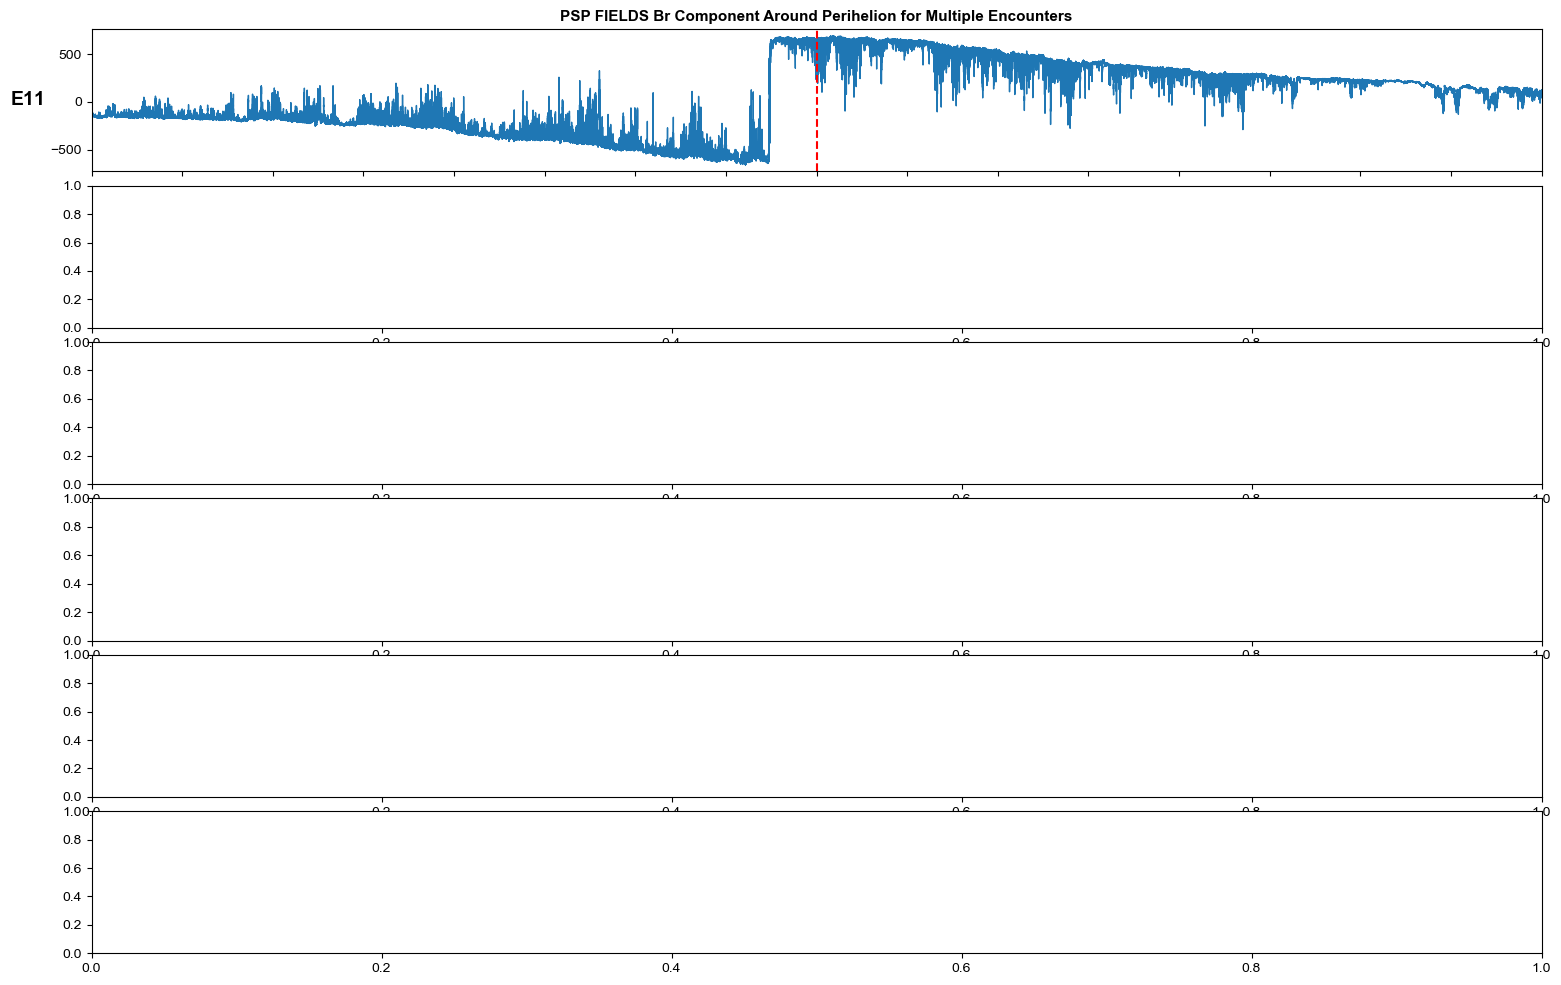

In [48]:
#######-----📈📈📈📈📈 MULTIPLOTTING MAGIC 📉📉📉📉📉📉-----#######

#====================================================================
# CONFIGURE PRINT MANAGER AND SERVER ACCESS
#====================================================================
print_manager.show_status = True  # Status prints, useful for status updates
print_manager.show_debug = False  # Debug prints, helpful for debugging

server_access.username = None # Set to None for username prompt, or enter 'your_username' to hardcode.

#====================================================================
# RESET PLOTTING OPTIONS
#====================================================================
plt.options.reset() # Resetting options to ensure a clean slate

#====================================================================
# CONFIGURE GENERAL PLOT OPTIONS
#====================================================================
# Plot Sizing
plt.options.width = 20
plt.options.height_per_panel = 2
plt.options.hspace = 0.1

# Font Sizes and Padding
plt.options.title_fontsize = 11
plt.options.y_label_size = 14
plt.options.x_label_size = 12
plt.options.x_tick_label_size = 10
plt.options.y_tick_label_size = 10
plt.options.y_label_pad = 5

plt.options.use_single_title = True
plt.options.single_title_text = "PSP FIELDS Br Component Around Perihelion for Multiple Encounters"
plt.options.y_label_uses_encounter = True
plt.options.y_label_includes_time = False

plt.options.draw_vertical_line = True
plt.options.vertical_line_width = 1.5
plt.options.vertical_line_color = 'red'
plt.options.vertical_line_style = '--'

plt.options.use_relative_time = True
plt.options.relative_time_step_units = 'hours'
plt.options.relative_time_step = 6
plt.options.use_single_x_axis = True
plt.options.use_custom_x_axis_label = False
plt.options.custom_x_axis_label = None

#====================================================================
# CONFIGURE AXIS-SPECIFIC OPTIONS ✨NEW!✨
#====================================================================
# plt.options.ax1.y_limit = (-3000, 3000)  # Example y-limit for ax1
# plt.options.ax3.color = 'purple'

#====================================================================
# Rainbow Plot 🌈 -- Uncomment the second set for a single color plot!
#====================================================================
plt.options.color_mode = 'default'  # Options: 'default', 'rainbow', 'single'
plt.options.single_color = None     # Used when color_mode = 'single'

# plt.options.color_mode = 'single'  # Options: 'default', 'rainbow', 'single'
# plt.options.single_color = 'red'     # Used when color_mode = 'single'

#====================================================================
# DATA SELECTION FOR PLOTTING
#====================================================================

plt.options.window = '96:00:00.000'
plt.options.position = 'around'  # Position options for multiplot: 'before', 'after', 'around'

plot_variable = mag_rtn_4sa.br

# Create the plot data list using list comprehension
plot_data = [(encounter['perihelion'], plot_variable) for encounter in rainbow_encounters]

#====================================================================
# CALL MULTIPLOT WITH UPDATED OPTIONS
#====================================================================
multiplot(plot_data);

Adding data to plot... 

📡 mag_RTN_4sa - Local .cdf files already exist:
📂 psp_data/fields/l2/mag_rtn_4_per_cycle/2018/psp_fld_l2_mag_rtn_4_sa_per_cyc_20181104_v02.cdf, psp_data/fields/l2/mag_rtn_4_per_cycle/2018/psp_fld_l2_mag_rtn_4_sa_per_cyc_20181105_v02.cdf, psp_data/fields/l2/mag_rtn_4_per_cycle/2018/psp_fld_l2_mag_rtn_4_sa_per_cyc_20181106_v02.cdf, psp_data/fields/l2/mag_rtn_4_per_cycle/2018/psp_fld_l2_mag_rtn_4_sa_per_cyc_20181107_v02.cdf, psp_data/fields/l2/mag_rtn_4_per_cycle/2018/psp_fld_l2_mag_rtn_4_sa_per_cyc_20181108_v02.cdf
✅ - Data import complete for range ['2018-11-04/03:27:00.000000', '2018-11-08/03:27:00.000000'].
Adding data to plot... 

📡 mag_RTN_4sa - Local .cdf files already exist:
📂 psp_data/fields/l2/mag_rtn_4_per_cycle/2019/psp_fld_l2_mag_rtn_4_sa_per_cyc_20190402_v02.cdf, psp_data/fields/l2/mag_rtn_4_per_cycle/2019/psp_fld_l2_mag_rtn_4_sa_per_cyc_20190403_v02.cdf, psp_data/fields/l2/mag_rtn_4_per_cycle/2019/psp_fld_l2_mag_rtn_4_sa_per_cyc_20190404_v02.cdf, ps

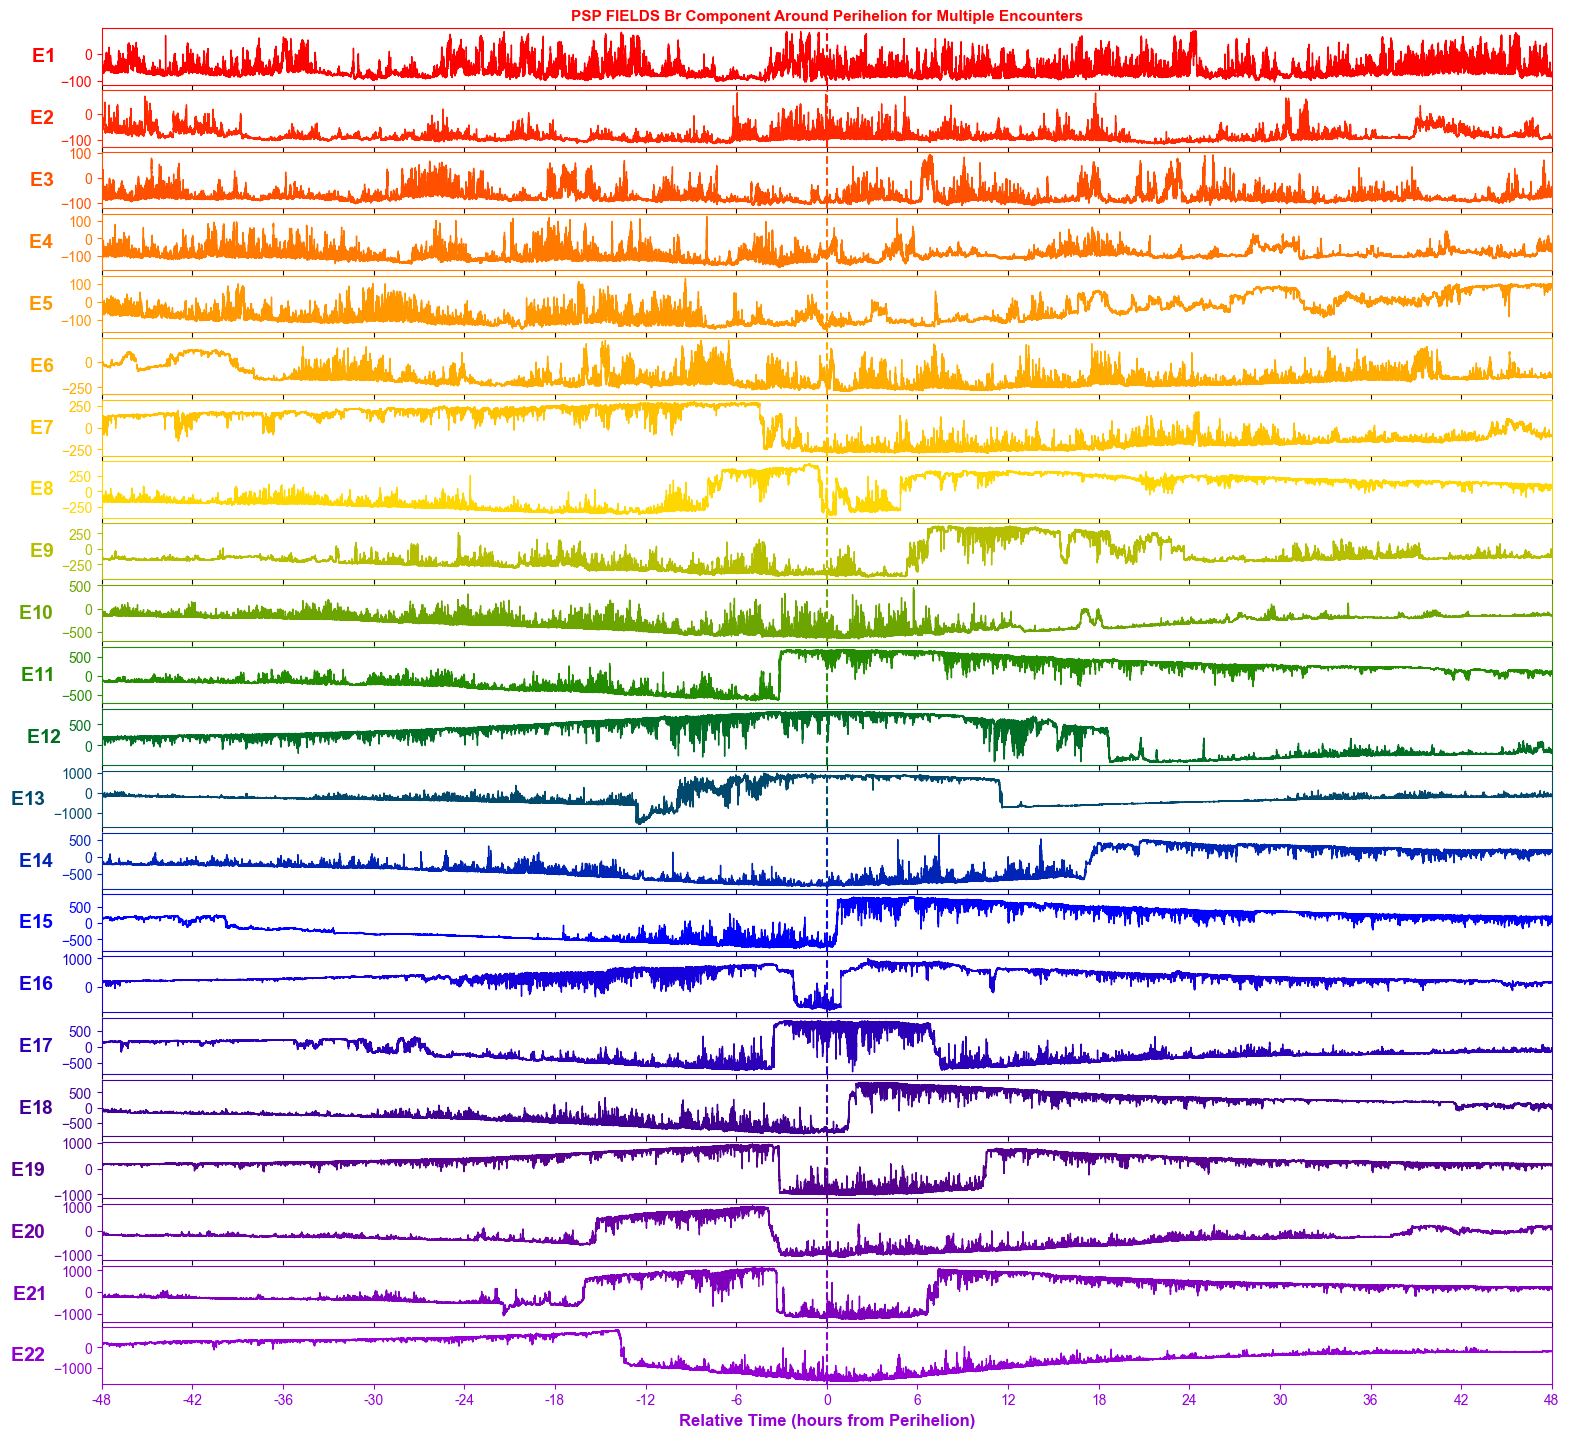

In [45]:
#######-----📈📈📈📈📈 MULTIPLOTTING MAGIC 📉📉📉📉📉📉-----#######

#====================================================================
# CONFIGURE PRINT MANAGER AND SERVER ACCESS
#====================================================================
print_manager.show_status = True  # Status prints, useful for status updates
print_manager.show_debug = False  # Debug prints, helpful for debugging

server_access.username = None # Set to None for username prompt, or enter 'your_username' to hardcode.

#====================================================================
# RESET PLOTTING OPTIONS
#====================================================================
plt.options.reset() # Resetting options to ensure a clean slate

#====================================================================
# CONFIGURE GENERAL PLOT OPTIONS
#====================================================================
# Plot Sizing
plt.options.width = 20
plt.options.height_per_panel = 0.8
plt.options.hspace = 0.1

# Font Sizes and Padding
plt.options.title_fontsize = 11
plt.options.y_label_size = 14
plt.options.x_label_size = 12
plt.options.x_tick_label_size = 10
plt.options.y_tick_label_size = 10
plt.options.y_label_pad = 5

plt.options.use_single_title = True
plt.options.single_title_text = "PSP FIELDS Br Component Around Perihelion for Multiple Encounters"
plt.options.y_label_uses_encounter = True
plt.options.y_label_includes_time = False

plt.options.draw_vertical_line = True
plt.options.vertical_line_width = 1.5
plt.options.vertical_line_color = 'red'
plt.options.vertical_line_style = '--'

plt.options.use_relative_time = True
plt.options.relative_time_step_units = 'hours'
plt.options.relative_time_step = 6
plt.options.use_single_x_axis = True
plt.options.use_custom_x_axis_label = False
plt.options.custom_x_axis_label = None

#====================================================================
# CONFIGURE AXIS-SPECIFIC OPTIONS ✨NEW!✨
#====================================================================
# plt.options.ax1.y_limit = (-3000, 3000)  # Example y-limit for ax1
# plt.options.ax3.color = 'purple'

#====================================================================
# Rainbow Plot 🌈 -- Uncomment the second set for a single color plot!
#====================================================================
plt.options.color_mode = 'rainbow'  # Options: 'default', 'rainbow', 'single'
plt.options.single_color = None     # Used when color_mode = 'single'

# plt.options.color_mode = 'single'  # Options: 'default', 'rainbow', 'single'
# plt.options.single_color = 'red'     # Used when color_mode = 'single'

#====================================================================
# DATA SELECTION FOR PLOTTING
#====================================================================

plt.options.window = '96:00:00.000'
plt.options.position = 'around'  # Position options for multiplot: 'before', 'after', 'around'

plot_variable = mag_rtn_4sa.br

# Create the plot data list using list comprehension
plot_data = [(encounter['perihelion'], plot_variable) for encounter in rainbow_encounters]

#====================================================================
# CALL MULTIPLOT WITH UPDATED OPTIONS
#====================================================================
multiplot(plot_data);

Adding data to plot... 

📡 spi_sf00_l3_mom - Local .cdf files already exist:
📂 psp_data/sweap/spi/l3/spi_sf00_l3_mom/2018/psp_swp_spi_sf00_L3_mom_20181104_v04.cdf, psp_data/sweap/spi/l3/spi_sf00_l3_mom/2018/psp_swp_spi_sf00_L3_mom_20181105_v04.cdf, psp_data/sweap/spi/l3/spi_sf00_l3_mom/2018/psp_swp_spi_sf00_L3_mom_20181106_v04.cdf, psp_data/sweap/spi/l3/spi_sf00_l3_mom/2018/psp_swp_spi_sf00_L3_mom_20181107_v04.cdf, psp_data/sweap/spi/l3/spi_sf00_l3_mom/2018/psp_swp_spi_sf00_L3_mom_20181108_v04.cdf
✅ - Data import complete for range ['2018-11-04/03:27:00.000000', '2018-11-08/03:27:00.000000'].
Adding data to plot... 

📡 spi_sf00_l3_mom - Local .cdf files already exist:
📂 psp_data/sweap/spi/l3/spi_sf00_l3_mom/2019/psp_swp_spi_sf00_L3_mom_20190402_v04.cdf, psp_data/sweap/spi/l3/spi_sf00_l3_mom/2019/psp_swp_spi_sf00_L3_mom_20190403_v04.cdf, psp_data/sweap/spi/l3/spi_sf00_l3_mom/2019/psp_swp_spi_sf00_L3_mom_20190404_v04.cdf, psp_data/sweap/spi/l3/spi_sf00_l3_mom/2019/psp_swp_spi_sf00_L3_mom

KeyboardInterrupt: 

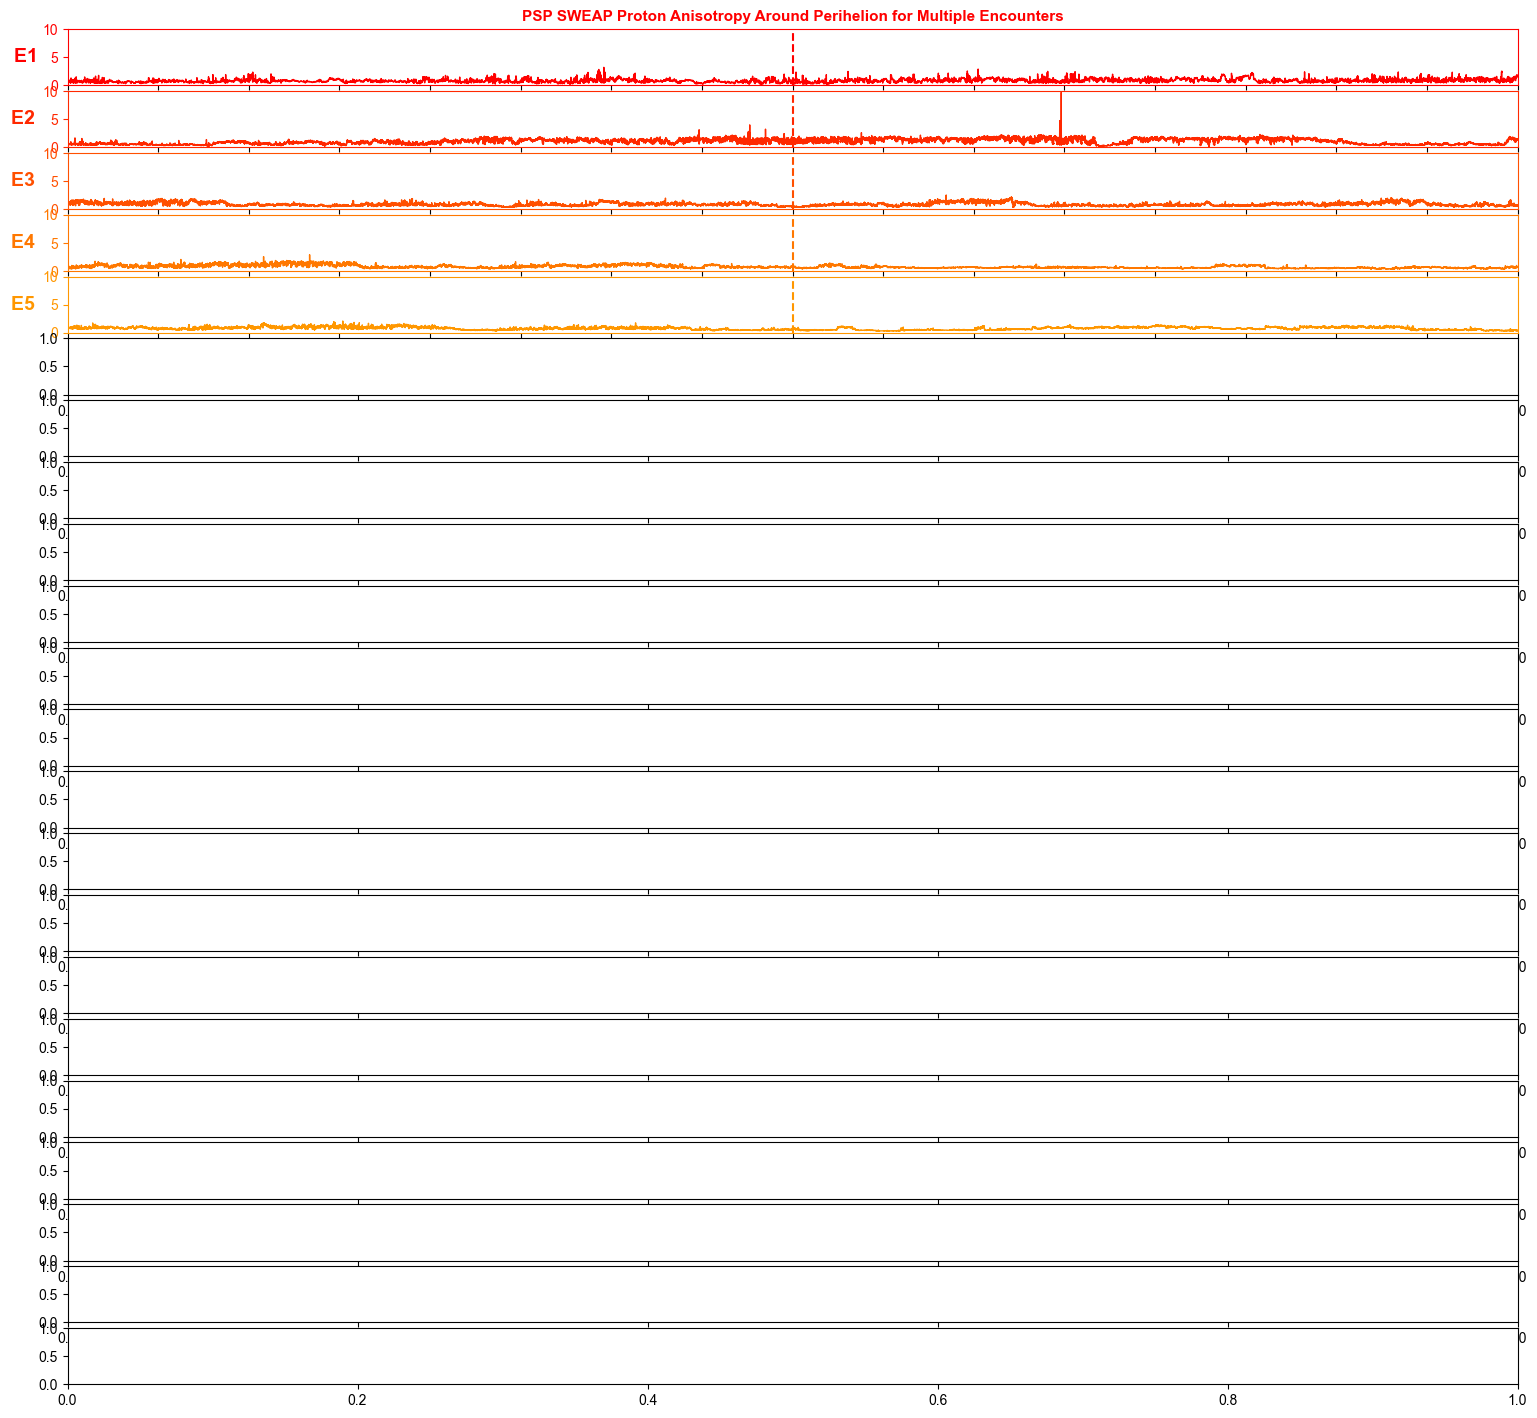

In [46]:
#######-----📈📈📈📈📈 MULTIPLOTTING MAGIC 📉📉📉📉📉📉-----#######

#====================================================================
# CONFIGURE PRINT MANAGER AND SERVER ACCESS
#====================================================================
print_manager.show_status = True  # Status prints, useful for status updates
print_manager.show_debug = False  # Debug prints, helpful for debugging

server_access.username = None # Set to None for username prompt, or enter 'your_username' to hardcode.

#====================================================================
# RESET PLOTTING OPTIONS
#====================================================================
plt.options.reset() # Resetting options to ensure a clean slate

#====================================================================
# CONFIGURE GENERAL PLOT OPTIONS
#====================================================================
# Plot Sizing
plt.options.width = 20
plt.options.height_per_panel = 0.8
plt.options.hspace = 0.1

# Font Sizes and Padding
plt.options.title_fontsize = 11
plt.options.y_label_size = 14
plt.options.x_label_size = 12
plt.options.x_tick_label_size = 10
plt.options.y_tick_label_size = 10
plt.options.y_label_pad = 5

plt.options.use_single_title = True
plt.options.single_title_text = "PSP SWEAP Proton Anisotropy Around Perihelion for Multiple Encounters"
plt.options.y_label_uses_encounter = True
plt.options.y_label_includes_time = False

plt.options.draw_vertical_line = True
plt.options.vertical_line_width = 1.5
plt.options.vertical_line_color = 'red'
plt.options.vertical_line_style = '--'

plt.options.use_relative_time = True
plt.options.relative_time_step_units = 'hours'
plt.options.relative_time_step = 6
plt.options.use_single_x_axis = True
plt.options.use_custom_x_axis_label = False
plt.options.custom_x_axis_label = None

#====================================================================
# CONFIGURE AXIS-SPECIFIC OPTIONS ✨NEW!✨
#====================================================================
# plt.options.ax4.y_limit = (0, 5)  # Example y-limit for ax1
# Access each axis to ensure it is initialized, then set the y_limit
for i in range(1, 23):
    axis_attr = f'ax{i}'
    axis_options = getattr(plt.options, axis_attr)  # This will initialize the axis if it doesn't exist
    axis_options.y_limit = (0, 10)  # Set y-limit for axes 1 through 22

# plt.options.ax3.color = 'purple'

#====================================================================
# Rainbow Plot 🌈 -- Uncomment the second set for a single color plot!
#====================================================================
plt.options.color_mode = 'rainbow'  # Options: 'default', 'rainbow', 'single'
plt.options.single_color = None     # Used when color_mode = 'single'

# plt.options.color_mode = 'single'  # Options: 'default', 'rainbow', 'single'
# plt.options.single_color = 'red'     # Used when color_mode = 'single'

#====================================================================
# DATA SELECTION FOR PLOTTING
#====================================================================

plt.options.window = '96:00:00.000'
plt.options.position = 'around'  # Position options for multiplot: 'before', 'after', 'around'

plot_variable = proton.anisotropy

# Create the plot data list using list comprehension
plot_data = [(encounter['perihelion'], plot_variable) for encounter in rainbow_encounters]

#====================================================================
# CALL MULTIPLOT WITH UPDATED OPTIONS
#====================================================================
multiplot(plot_data);

In [47]:
encounters = [
    # {'rangeStart': '2018/11/03 03:27:00.000', 'rangeStop': '2018/11/09 03:27:00.000', 'perihelion': '2018/11/06 03:27:00.000'}, #Enc 1
    # {'rangeStart': '2019/04/01 22:39:00.000', 'rangeStop': '2019/04/07 22:39:00.000', 'perihelion': '2019/04/04 22:39:00.000'}, #Enc 2
    # {'rangeStart': '2019/08/29 17:50:00.000', 'rangeStop': '2019/09/04 17:50:00.000', 'perihelion': '2019/09/01 17:50:00.000'}, #Enc 3
    # {'rangeStart': '2020/01/26 09:37:00.000', 'rangeStop': '2020/02/01 09:37:00.000', 'perihelion': '2020/01/29 09:37:00.000'}, #Enc 4
    # {'rangeStart': '2020/06/04 08:23:00.000', 'rangeStop': '2020/06/10 08:23:00.000', 'perihelion': '2020/06/07 08:23:00.000'}, #Enc 5
    # {'rangeStart': '2020/09/24 09:16:00.000', 'rangeStop': '2020/09/30 09:16:00.000', 'perihelion': '2020/09/27 09:16:00.000'}, #Enc 6
    # {'rangeStart': '2021/01/14 17:40:00.000', 'rangeStop': '2021/01/20 17:40:00.000', 'perihelion': '2021/01/17 17:40:00.000'}, #Enc 7
    # {'rangeStart': '2021/04/26 08:48:00.000', 'rangeStop': '2021/05/02 08:48:00.000', 'perihelion': '2021/04/29 08:48:00.000'}, #Enc 8
    # {'rangeStart': '2021/08/06 19:11:00.000', 'rangeStop': '2021/08/12 19:11:00.000', 'perihelion': '2021/08/09 19:11:00.000'}, #Enc 9
    # {'rangeStart': '2021/11/18 08:23:00.000', 'rangeStop': '2021/11/24 08:23:00.000', 'perihelion': '2021/11/21 08:23:00.000'}, #Enc 10
    # {'rangeStart': '2022/02/22 15:38:00.000', 'rangeStop': '2022/02/28 15:38:00.000', 'perihelion': '2022/02/25 15:38:00.000'}, #Enc 11
    # {'rangeStart': '2022/05/29 22:51:00.000', 'rangeStop': '2022/06/04 22:51:00.000', 'perihelion': '2022/06/01 22:51:00.000'}, #Enc 12
    # {'rangeStart': '2022/09/03 06:04:00.000', 'rangeStop': '2022/09/09 06:04:00.000', 'perihelion': '2022/09/06 06:04:00.000'}, #Enc 13
    # {'rangeStart': '2022/12/08 13:16:00.000', 'rangeStop': '2022/12/14 13:16:00.000', 'perihelion': '2022/12/11 13:16:00.000'}, #Enc 14
    # {'rangeStart': '2023/03/14 20:30:00.000', 'rangeStop': '2023/03/20 20:30:00.000', 'perihelion': '2023/03/17 20:30:00.000'}, #Enc 15
    # {'rangeStart': '2023/06/19 03:46:00.000', 'rangeStop': '2023/06/25 03:46:00.000', 'perihelion': '2023/06/22 03:46:00.000'}, #Enc 16
    # {'rangeStart': '2023/09/24 23:28:00.000', 'rangeStop': '2023/09/30 23:28:00.000', 'perihelion': '2023/09/27 23:28:00.000'}, #Enc 17
    # {'rangeStart': '2023/12/26 00:56:00.000', 'rangeStop': '2024/01/01 00:56:00.000', 'perihelion': '2023/12/29 00:56:00.000'}, #Enc 18
    {'rangeStart': '2024/03/27 02:21:00.000', 'rangeStop': '2024/04/02 02:21:00.000', 'perihelion': '2024/03/30 02:21:00.000'}, #Enc 19 
    {'rangeStart': '2024/06/27 03:47:00.000', 'rangeStop': '2024/07/03 03:47:00.000', 'perihelion': '2024/06/30 03:47:00.000'}, #Enc 20 Not yet publicly available
    {'rangeStart': '2024/09/27 05:15:00.000', 'rangeStop': '2024/10/03 05:15:00.000', 'perihelion': '2024/09/30 05:15:00.000'}, #Enc 21 Not yet publicly available
    {'rangeStart': '2024/12/21 11:53:00.000', 'rangeStop': '2024/12/27 11:53:00.000', 'perihelion': '2024/12/24 11:53:00.000'}, #Enc 22 Not yet publicly available
]

Adding data to plot... 

📡 spi_sf00_l3_mom - Local .cdf files already exist:
📂 psp_data/sweap/spi/l3/spi_sf00_l3_mom/2024/psp_swp_spi_sf00_L3_mom_20240329_v04.cdf, psp_data/sweap/spi/l3/spi_sf00_l3_mom/2024/psp_swp_spi_sf00_L3_mom_20240330_v04.cdf
✅ - Data import complete for range ['2024-03-29/14:21:00.000000', '2024-03-30/14:21:00.000000'].
📡 spi_sf00_l3_mom - Local .cdf files already exist:
📂 psp_data/sweap/spi/l3/spi_sf00_l3_mom/2024/psp_swp_spi_sf00_L3_mom_20240329_v04.cdf, psp_data/sweap/spi/l3/spi_sf00_l3_mom/2024/psp_swp_spi_sf00_L3_mom_20240330_v04.cdf
Adding data to plot... 

📡 spi_sf00_l3_mom - Local .cdf files already exist:
📂 psp_data/sweap/spi/l3/spi_sf00_l3_mom/2024/psp_swp_spi_sf00_L3_mom_20240629_v00.cdf, psp_data/sweap/spi/l3/spi_sf00_l3_mom/2024/psp_swp_spi_sf00_L3_mom_20240629_v04.cdf, psp_data/sweap/spi/l3/spi_sf00_l3_mom/2024/psp_swp_spi_sf00_L3_mom_20240630_v04.cdf
✅ - Data import complete for range ['2024-06-29/15:47:00.000000', '2024-06-30/15:47:00.000000'].
📡 

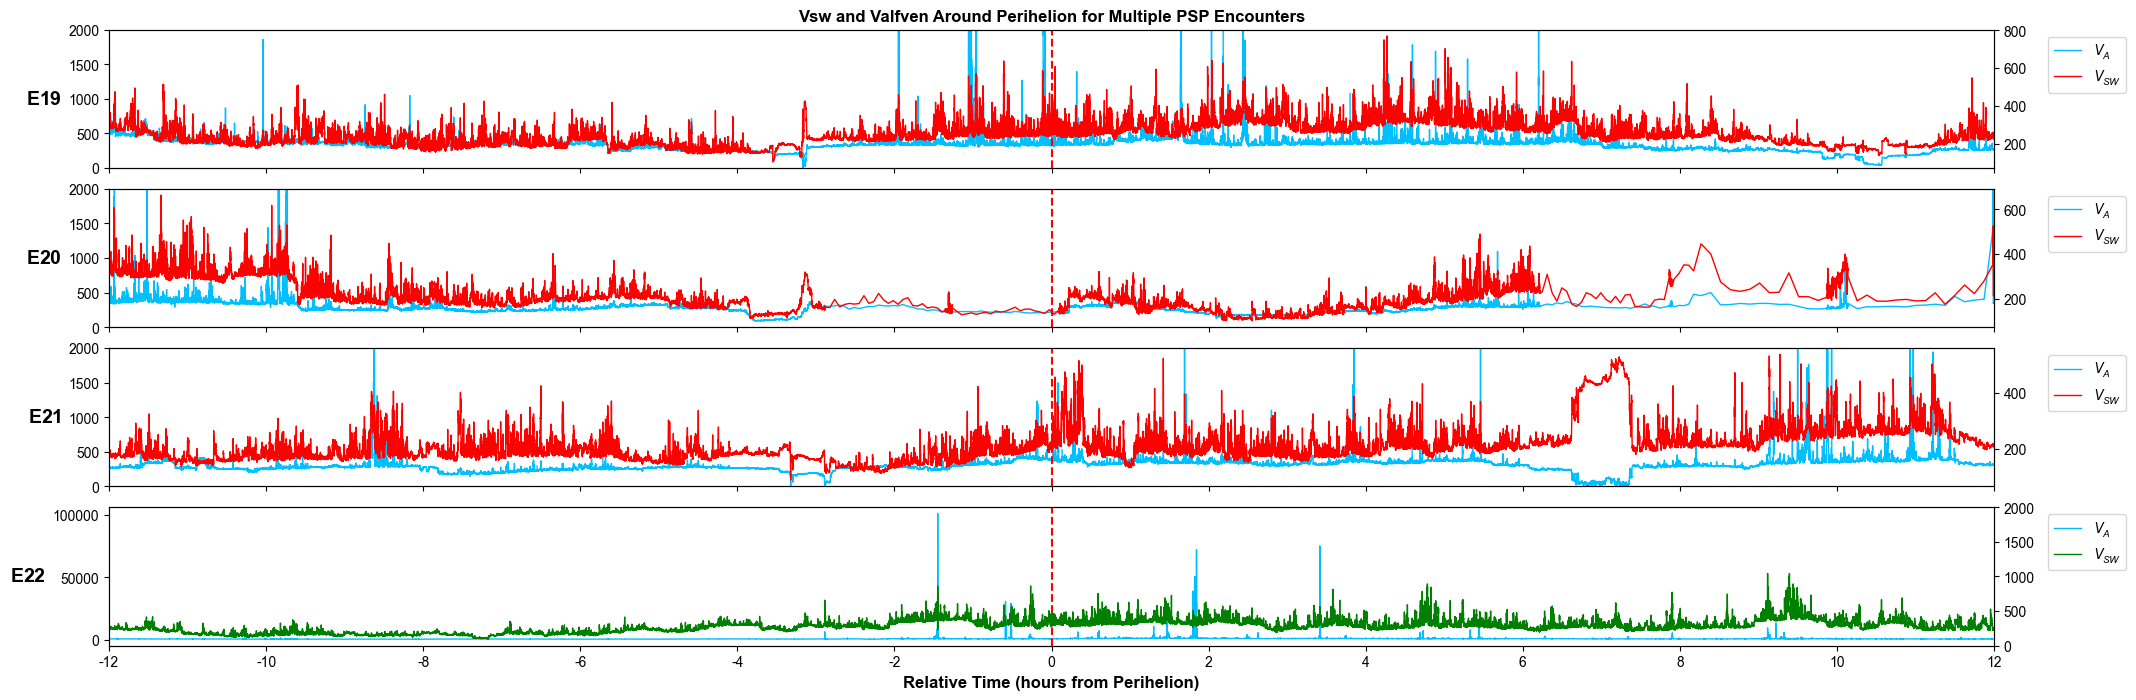

In [54]:
#######-----📈📈📈📈📈 MULTIPLOTTING MAGIC 📉📉📉📉📉📉-----#######

#====================================================================
# CONFIGURE PRINT MANAGER AND SERVER ACCESS
#====================================================================
print_manager.show_status = True  # Status prints, useful for status updates
# print_manager.show_status = False  # Status prints, useful for status updates
print_manager.show_debug = False   # Debug prints, helpful for debugging
print_manager.show_datacubby = False

server_access.username = None # Set to None for username prompt, or enter 'your_username' to hardcode.

#====================================================================
# RESET PLOTTING OPTIONS
#====================================================================
plt.options.reset() #in case we're setting options in other cells... 👀

#====================================================================
# CONFIGURE GENERAL PLOT OPTIONS
#====================================================================

# Plot Sizing
plt.options.width = 26
plt.options.height_per_panel = 2.0
plt.options.hspace = 0.15

# Font Sizes and Padding
plt.options.title_fontsize = 12
plt.options.y_label_size = 14
plt.options.x_label_size = 12
plt.options.x_tick_label_size = 10  # Size of x-axis tick labels
plt.options.y_tick_label_size = 10
plt.options.y_label_pad = 5  # Space between y-label and axis

plt.options.use_single_title = True
plt.options.single_title_text = "Vsw and Valfven Around Perihelion for Multiple PSP Encounters"


plt.options.y_label_uses_encounter = True
plt.options.y_label_includes_time = False

plt.options.draw_vertical_line = True
plt.options.vertical_line_width = 1.5
plt.options.vertical_line_color = 'red'
plt.options.vertical_line_style = '--'

plt.options.second_variable_on_right_axis = True #✨NEW OPTION TO PLOT SECOND VARIABLE ON RIGHT AXIS!✨

plt.options.use_relative_time = True
plt.options.relative_time_step_units = 'hours'  # use 'days', 'hours', 'minutes', or 'seconds'.
plt.options.relative_time_step = 2
plt.options.use_single_x_axis = True
plt.options.use_custom_x_axis_label = True
plt.options.custom_x_axis_label = "Relative Time (hours from Perihelion)"

#====================================================================
# CONFIGURE AXIS-SPECIFIC OPTIONS ✨NEW!✨
#====================================================================

plt.options.ax1.y_limit = (0, 2000)  # Example y-limit for ax1
plt.options.ax2.y_limit = (0, 2000)  # Example y-limit for ax2
plt.options.ax3.y_limit = (0, 2000)  # Example y-limit for ax3

plt.options.ax4.r.y_limit = (0, 2000)  # Example y-limit for ax4 👉(RIGHT SIDE!)
plt.options.ax4.r.color = 'green'  # Example color for ax4 👉(RIGHT SIDE!)

#====================================================================
# Rainbow Plot
#====================================================================
plt.options.color_mode = 'default'  # Options: 'default', 'rainbow', 'single'
plt.options.single_color = None     # Used when color_mode = 'single'

#====================================================================
# DATA SELECTION FOR PLOTTING
#====================================================================

plt.options.window = '24:00:00.000'
plt.options.position = 'around'  # Position options for multiplot: 'before', 'after', 'around'

plot_variable = [proton.v_alfven, proton.v_sw]  #✨NEW ABILITY TO PLOT MULTIPLE VARIABLES!✨

perihelion_times = [(encounter['perihelion'], plot_variable) for encounter in encounters]

multiplot(perihelion_times);


In [49]:
print(proton.v_alfven.color)
print(proton.v_sw.color)

deepskyblue
red


Adding data to plot... 

📡 mag_RTN_4sa - Local .cdf files already exist:
📂 psp_data/fields/l2/mag_rtn_4_per_cycle/2021/psp_fld_l2_mag_rtn_4_sa_per_cyc_20210428_v02.cdf, psp_data/fields/l2/mag_rtn_4_per_cycle/2021/psp_fld_l2_mag_rtn_4_sa_per_cyc_20210429_v02.cdf
✅ - Data import complete for range ['2021-04-28/22:00:00.000000', '2021-04-29/04:00:00.000000'].
Adding data to plot... 

📡 mag_RTN_4sa - A local .cdf file already exists:
📂 psp_data/fields/l2/mag_rtn_4_per_cycle/2021/psp_fld_l2_mag_rtn_4_sa_per_cyc_20210429_v02.cdf
✅ - Data import complete for range ['2021-04-29/05:20:00.000000', '2021-04-29/11:20:00.000000'].
Adding data to plot... 

📡 mag_RTN_4sa - A local .cdf file already exists:
📂 psp_data/fields/l2/mag_rtn_4_per_cycle/2021/psp_fld_l2_mag_rtn_4_sa_per_cyc_20210429_v02.cdf
✅ - Data import complete for range ['2021-04-29/06:30:00.000000', '2021-04-29/12:30:00.000000'].
Adding data to plot... 

📡 mag_RTN_4sa - A local .cdf file already exists:
📂 psp_data/fields/l2/mag_rtn_4_p

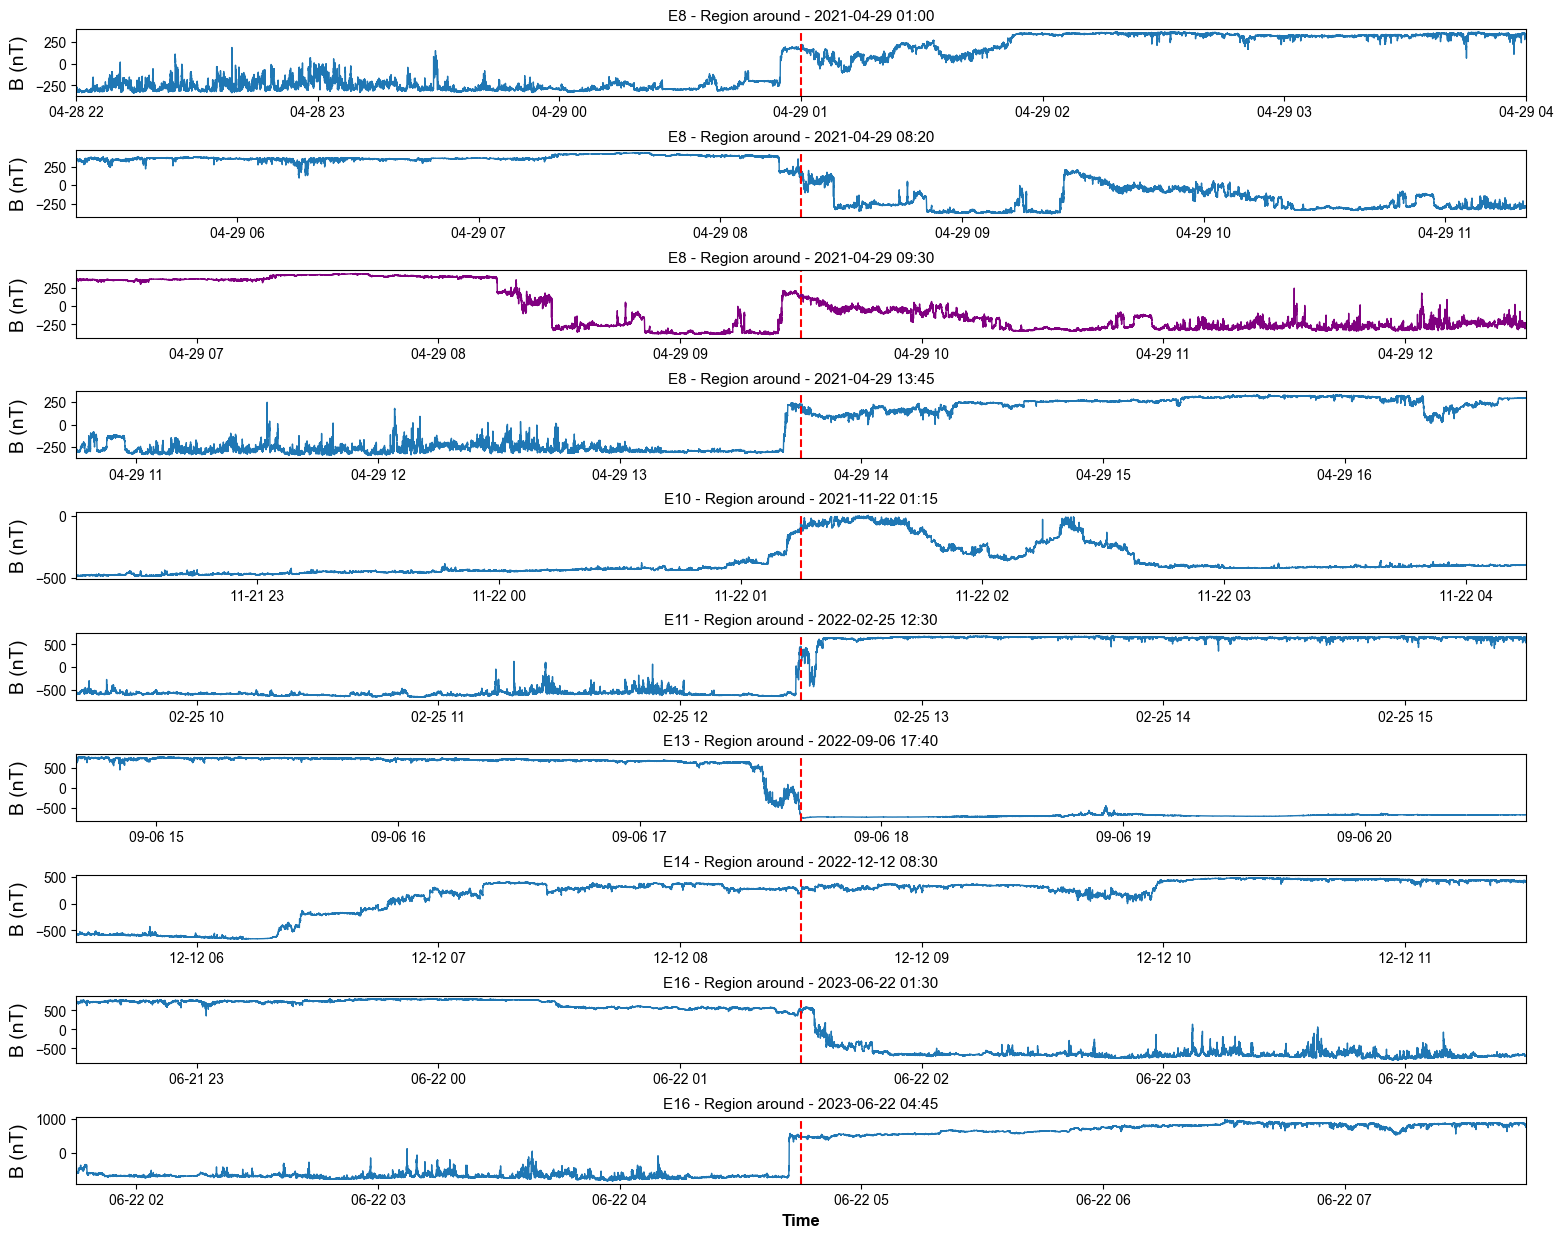

In [50]:
#######-----📈📈📈📈📈 MULTIPLOTTING MAGIC 📉📉📉📉📉📉-----#######

#====================================================================
# CONFIGURE PRINT MANAGER AND SERVER ACCESS
#====================================================================
print_manager.show_status = True  # Status prints, useful for status updates
print_manager.show_debug = False  # Debug prints, helpful for debugging

# server_access.username = None # Set to None for username prompt, or enter 'your_username' to hardcode.

#====================================================================
# RESET PLOTTING OPTIONS
#====================================================================
plt.options.reset() # Resetting options to ensure a clean slate

#====================================================================
# CONFIGURE GENERAL PLOT OPTIONS
#====================================================================
# Plot Sizing
plt.options.width = 20
plt.options.height_per_panel = 1.5
plt.options.hspace = 0.8

# Font Sizes and Padding
plt.options.title_fontsize = 11
plt.options.y_label_size = 14
plt.options.x_label_size = 12
plt.options.x_tick_label_size = 10
plt.options.y_tick_label_size = 10
plt.options.y_label_pad = 5

plt.options.use_single_title = False
plt.options.single_title_text = "Br Around PSP HCS Crossings"
plt.options.y_label_uses_encounter = False
plt.options.y_label_includes_time = False

plt.options.draw_vertical_line = True
plt.options.vertical_line_width = 1.5
plt.options.vertical_line_color = 'red'
plt.options.vertical_line_style = '--'

plt.options.use_relative_time = False
plt.options.relative_time_step_units = 'hours'
plt.options.relative_time_step = 6
plt.options.use_single_x_axis = False
plt.options.use_custom_x_axis_label = False
plt.options.custom_x_axis_label = None

#====================================================================
# CONFIGURE AXIS-SPECIFIC OPTIONS ✨NEW!✨
#====================================================================
# plt.options.ax1.y_limit = (-3000, 3000)  # Example y-limit for ax1
plt.options.ax3.color = 'purple'

#====================================================================
# DATA SELECTION FOR PLOTTING
#====================================================================
hcs_crossing_times = [ #in the previous example we defined the times outside the cell, either way works!
    '2021-04-29/01:00:00.000',
    '2021-04-29/08:20:00.000',
    '2021-04-29/09:30:00.000',
    '2021-04-29/13:45:00.000',
    '2021-11-22/01:15:00.000',
    '2022-02-25/12:30:00.000',
    '2022-09-06/17:40:00.000',
    '2022-12-12/08:30:00.000',
    '2023-06-22/01:30:00.000',
    '2023-06-22/04:45:00.000'
]

plt.options.window = '06:00:00.000'
plt.options.position = 'around'  # Position options for multiplot: 'before', 'after', 'around'

plot_variable = mag_rtn_4sa.br

# Create the plot data list using list comprehension
plot_data = [(time, plot_variable) for time in hcs_crossing_times]

#====================================================================
# CALL MULTIPLOT WITH UPDATED OPTIONS
#====================================================================
multiplot(plot_data);

Adding data to plot... 

📡 spe_sf0_pad - Local .cdf files already exist:
📂 psp_data/sweap/spe/l3/spe_sf0_pad/2021/psp_swp_spe_sf0_L3_pad_20210428_v04.cdf, psp_data/sweap/spe/l3/spe_sf0_pad/2021/psp_swp_spe_sf0_L3_pad_20210429_v04.cdf
✅ - Data import complete for range ['2021-04-28/22:00:00.000000', '2021-04-29/04:00:00.000000'].
Adding data to plot... 

📡 spe_sf0_pad - A local .cdf file already exists:
📂 psp_data/sweap/spe/l3/spe_sf0_pad/2021/psp_swp_spe_sf0_L3_pad_20210429_v04.cdf
✅ - Data import complete for range ['2021-04-29/05:20:00.000000', '2021-04-29/11:20:00.000000'].
Adding data to plot... 

📡 spe_sf0_pad - A local .cdf file already exists:
📂 psp_data/sweap/spe/l3/spe_sf0_pad/2021/psp_swp_spe_sf0_L3_pad_20210429_v04.cdf
✅ - Data import complete for range ['2021-04-29/06:30:00.000000', '2021-04-29/12:30:00.000000'].
Adding data to plot... 

📡 spe_sf0_pad - A local .cdf file already exists:
📂 psp_data/sweap/spe/l3/spe_sf0_pad/2021/psp_swp_spe_sf0_L3_pad_20210429_v04.cdf
✅ - Dat

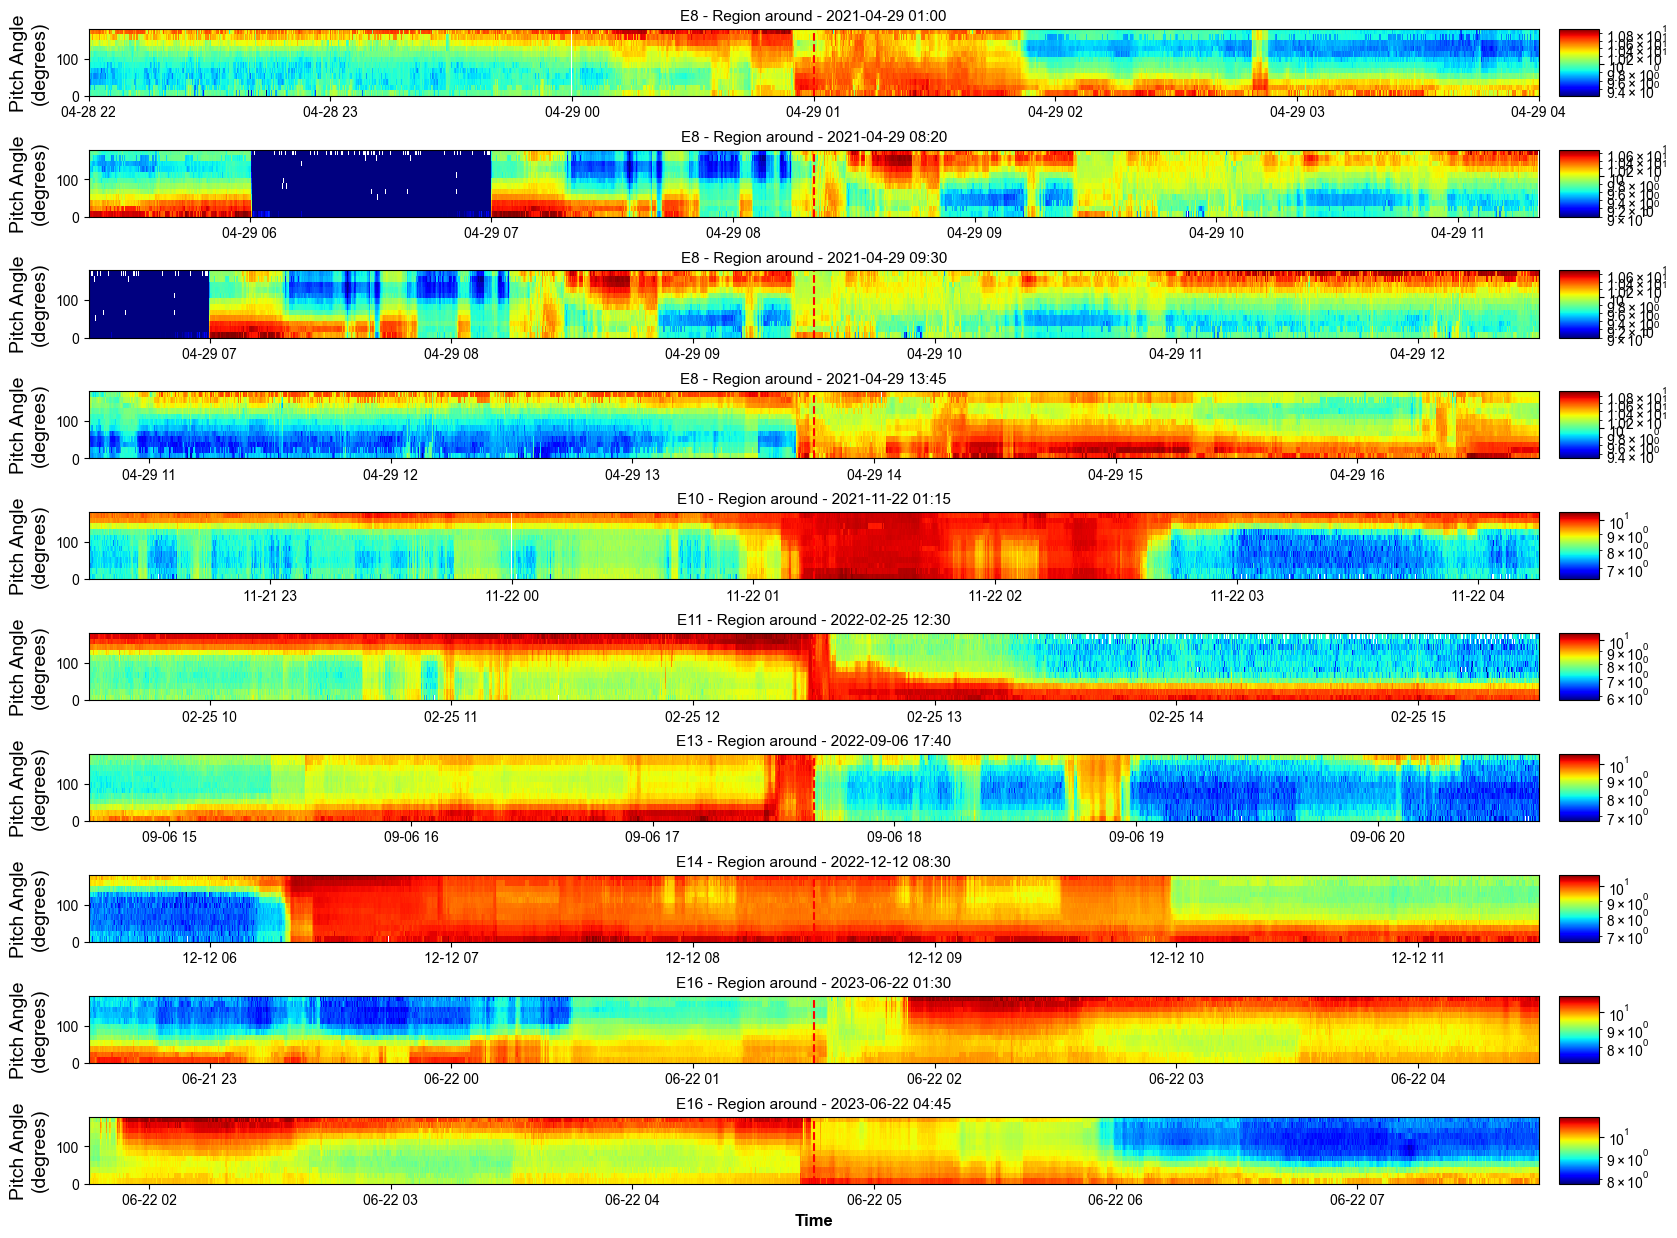

In [51]:
#######-----📈📈📈📈📈 MULTIPLOTTING MAGIC - STRAHL EXAMPLE 📉📉📉📉📉📉-----#######

#====================================================================
# CONFIGURE PRINT MANAGER AND SERVER ACCESS
#====================================================================
print_manager.show_status = True  # Status prints, useful for status updates
print_manager.show_debug = False  # Debug prints, helpful for debugging

# server_access.username = None # Set to None for username prompt, or enter 'your_username' to hardcode.

#====================================================================
# RESET PLOTTING OPTIONS
#====================================================================
plt.options.reset() # Resetting options to ensure a clean slate

#====================================================================
# CONFIGURE GENERAL PLOT OPTIONS
#====================================================================

# Plot Sizing
plt.options.width = 20
plt.options.height_per_panel = 1.5
plt.options.hspace = 0.8

# Font Sizes and Padding
plt.options.title_fontsize = 11
plt.options.y_label_size = 14
plt.options.x_label_size = 12
plt.options.x_tick_label_size = 10
plt.options.y_tick_label_size = 10
plt.options.y_label_pad = 5

plt.options.use_single_title = False
plt.options.single_title_text = "Br Around PSP HCS Crossings"
plt.options.y_label_uses_encounter = False
plt.options.y_label_includes_time = False

plt.options.draw_vertical_line = True
plt.options.vertical_line_width = 1.5
plt.options.vertical_line_color = 'red'
plt.options.vertical_line_style = '--'

plt.options.use_relative_time = False
plt.options.relative_time_step_units = 'hours'
plt.options.relative_time_step = 6
plt.options.use_single_x_axis = False
plt.options.use_custom_x_axis_label = False
plt.options.custom_x_axis_label = None

#====================================================================
# CONFIGURE AXIS-SPECIFIC OPTIONS ✨NEW!✨
#====================================================================
plt.options.ax2.colorbar_limits = (9, 10.7) #We're setting a custom limit to correct for the area where the instrument dropped out!
plt.options.ax3.colorbar_limits = (9, 10.7)


#====================================================================
# Ploptions work too!
#====================================================================
epad.strahl.colorbar_limits = 'default' #Setting to default in case this was changed elsewhere... it gets overriden by the axis specific option for ax2 and ax3!

#====================================================================
# DATA SELECTION FOR PLOTTING
#====================================================================
hcs_crossing_times = [ #in the previous example we defined the times outside the cell, either way works!
    '2021-04-29/01:00:00.000',
    '2021-04-29/08:20:00.000',
    '2021-04-29/09:30:00.000',
    '2021-04-29/13:45:00.000',
    '2021-11-22/01:15:00.000',
    '2022-02-25/12:30:00.000',
    '2022-09-06/17:40:00.000',
    '2022-12-12/08:30:00.000',
    '2023-06-22/01:30:00.000',
    '2023-06-22/04:45:00.000'
]

plt.options.window = '06:00:00.000'
plt.options.position = 'around'  # Position options for multiplot: 'before', 'after', 'around'

plot_variable = epad.strahl

# Create the plot data list using list comprehension
plot_data = [(time, plot_variable) for time in hcs_crossing_times]

#====================================================================
# CALL MULTIPLOT WITH UPDATED OPTIONS
#====================================================================
multiplot(plot_data);

In [52]:
STOP 😎 #Who's callin this guy invalid!?
#This just makes the Run All command stop...

SyntaxError: invalid character '😎' (U+1F60E) (1536362184.py, line 1)

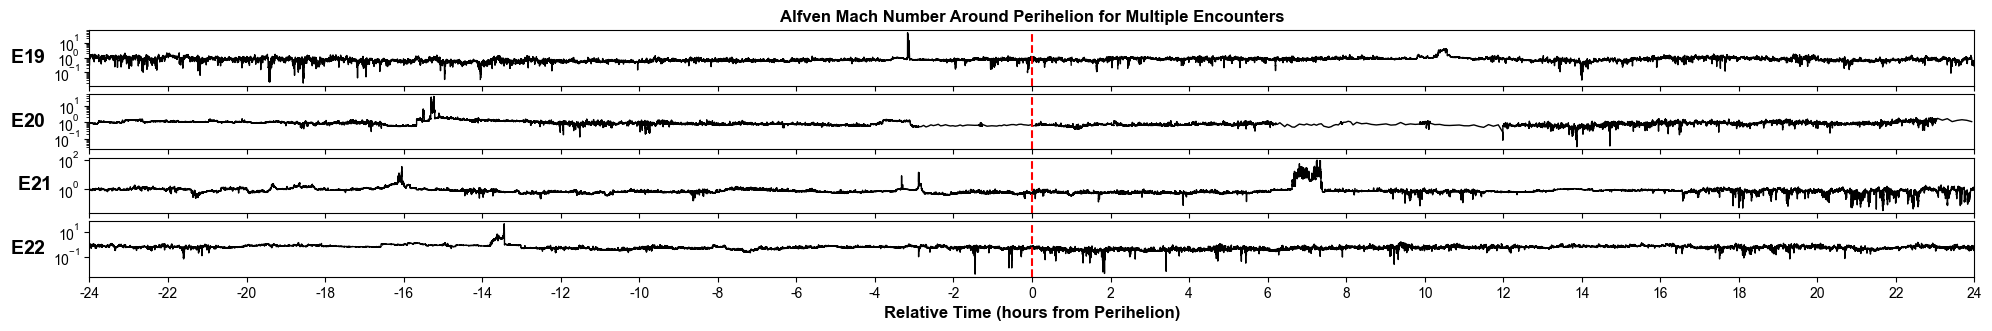

In [125]:
print_manager.show_status = False  # Status prints, useful for status updates
print_manager.show_debug = False   # Debug prints, helpful for debugging

server_access.username = None # Set to None for username prompt, or enter 'your_username' to hardcode.

plot_variable = proton.m_alfven   
# plot_variable = mag_rtn_4sa.br
# plot_variable = mag_rtn_4sa.bt
# plot_variable = epad.strahl

perihelion_times = [(encounter['perihelion'], plot_variable) for encounter in encounters]

multiplot(perihelion_times, 
         window='48:00:00.000', 
         position='around',  # Position options for multiplot: 'before', 'after', 'around'
         
         #Plot Sizing
         width=26,
         height_per_panel=0.8, 
         hspace=0.15, 
         
         #Font Sizes and Padding
         title_fontsize=12,
         y_label_size = 14,
         x_label_size = 12,
        
         x_tick_label_size=10,  # Size of x-axis tick labels
         y_tick_label_size=10, 
         y_label_pad=5,        # Space between y-label and axis 
        
         use_single_title=True,
         single_title_text="Alfven Mach Number Around Perihelion for Multiple Encounters",
        #  single_title_text="PSP FIELDS Br (nT) Around Perihelion for Multiple Encounters",
        #  single_title_text="Strahl Pitch Angle (Degrees) Around Parker Solar Probe Perihelion Crossings",
         
         y_label_uses_encounter = True,
         y_label_includes_time = False,
         
         draw_vertical_line=True,
         vertical_line_width=1.5,
         vertical_line_color='red',
         vertical_line_style='--',
         
         use_relative_time=True,
         relative_time_step_units='hours', #use 'days', 'hours', 'minutes', or 'seconds'.
         relative_time_step=2,
         use_single_x_axis=True,
         use_custom_x_axis_label=True,
         custom_x_axis_label="Relative Time (hours from Perihelion)"
);


In [ ]:
print_manager.show_status = False  # Status prints, useful for status updates
print_manager.show_debug = False   # Debug prints, helpful for debugging

# server_access.username = None # Set to None for username prompt, or enter 'your_username' to hardcode.

# plot_variable = proton.m_alfven   
# plot_variable = mag_rtn_4sa.br
# plot_variable = mag_rtn_4sa.bt
plot_variable = epad.strahl

perihelion_times = [(encounter['perihelion'], plot_variable) for encounter in encounters]

multiplot(perihelion_times, 
         window='96:00:00.000', 
         position='around',  # Position options for multiplot: 'before', 'after', 'around'
         
         #Plot Sizing
         width=26,
         height_per_panel=0.8, 
         hspace=0.15, 
         
         #Font Sizes and Padding
         title_fontsize=12,
         y_label_size = 14,
         x_label_size = 12,
        
         x_tick_label_size=10,  # Size of x-axis tick labels
         y_tick_label_size=10, 
         y_label_pad=5,        # Space between y-label and axis 
        
         use_single_title=True,
        #  single_title_text="Alfven Mach Number Around Perihelion for Multiple Encounters",
        #  single_title_text="PSP FIELDS Br (nT) Around Perihelion for Multiple Encounters",
         single_title_text="Strahl Pitch Angle (Degrees) Around Parker Solar Probe Perihelion Crossings",
         
         y_label_uses_encounter = True,
         y_label_includes_time = False,
         
         draw_vertical_line=True,
         vertical_line_width=1.5,
         vertical_line_color='red',
         vertical_line_style='--',
         
         use_relative_time=True,
         relative_time_step_units='hours', #use 'days', 'hours', 'minutes', or 'seconds'.
         relative_time_step=2,
         use_single_x_axis=True,
         use_custom_x_axis_label=True,
         custom_x_axis_label="Relative Time (hours from Perihelion)"
);


In [ ]:
# And we can still create our plots this way! 🙌

print_manager.show_status = True  # Status prints, useful for status updates
print_manager.show_debug = True   # Debug prints, helpful for debugging

# server_access.username = None # Set to None for username prompt, or enter 'your_username' to hardcode.

# Position options for multiplot:
# 'before' - Aligns window before the given time
# 'after' - Aligns window after the given time  
# 'around' - Aligns window around the given time (default)

multiplot([
    ('2021-04-29/01:00:00.000', mag_rtn_4sa.br),
    ('2021-04-29/08:20:00.000', mag_rtn_4sa.br),
    ('2021-04-29/09:30:00.000', mag_rtn_4sa.br),
    ('2021-04-29/13:45:00.000', mag_rtn_4sa.br),
    ('2021-11-22/01:15:00.000', mag_rtn_4sa.br),
    ('2022-02-25/12:30:00.000', mag_rtn_4sa.br),
    ('2022-09-06/17:40:00.000', mag_rtn_4sa.br),
    ('2022-12-12/08:30:00.000', mag_rtn_4sa.br),
    ('2023-06-22/01:30:00.000', mag_rtn_4sa.br),
    ('2023-06-22/04:45:00.000', mag_rtn_4sa.br)
], 
window='06:00:00.000',
position='around',

# Plot Sizing
width=20,
height_per_panel=1.5,
hspace=0.8,

# Font Sizes and Padding
title_fontsize=11,
y_label_size=14,
x_label_size=12,
x_tick_label_size=10,
y_tick_label_size=10,
y_label_pad=5,

use_single_title=False,
single_title_text="Br Around PSP HCS Crossings",
y_label_uses_encounter=True,
y_label_includes_time=False,

draw_vertical_line=True,
vertical_line_width=1.5,
vertical_line_color='red',
vertical_line_style='--',

use_relative_time=False,
relative_time_step_units='hours',
relative_time_step=6,
use_single_x_axis=False,
use_custom_x_axis_label=False,
custom_x_axis_label=None
);

In [ ]:
STOP 😎 #Who's callin this guy invalid!?
#This just makes the Run All command stop...

In [ ]:
#Working with Plotbot.data!! (the format is actually "mag_rtn_4sa.bmag.data " but you know what I mean...)

# Statistical Analysis of Magnetic Field Data
print("=== Magnetic Field Data Analysis ===\n")

# Convert plot_manager objects to numpy arrays for analysis
bmag_data = mag_rtn_4sa.bmag.data  
br_data = mag_rtn_4sa.br.data
bt_data = mag_rtn_4sa.bt.data
bn_data = mag_rtn_4sa.bn.data

# Basic checks
print("1. Data Structure Checks:")
print(f"Data type: {type(mag_rtn_4sa.bmag)}")
print(f"Shape: {np.shape(bmag_data)}")
print(f"Number of points: {len(bmag_data)}")
print(f"Memory usage: {bmag_data.nbytes / 1e6:.2f} MB\n")

# Basic statistics
print("2. Basic Statistics:")
print(f"Mean |B|: {np.nanmean(bmag_data):.2f} nT")
print(f"Median |B|: {np.nanmedian(bmag_data):.2f} nT")
print(f"Standard deviation: {np.nanstd(bmag_data):.2f} nT")
print(f"Min |B|: {np.nanmin(bmag_data):.2f} nT")
print(f"Max |B|: {np.nanmax(bmag_data):.2f} nT\n")

# Component analysis
print("3. Component Analysis:")
print("Mean values:")
print(f"⟨Br⟩: {np.nanmean(br_data):.2f} nT")
print(f"⟨Bt⟩: {np.nanmean(bt_data):.2f} nT")
print(f"⟨Bn⟩: {np.nanmean(bn_data):.2f} nT\n")

# Calculate field angles
theta = np.arctan2(np.sqrt(bt_data**2 + bn_data**2), br_data)
phi = np.arctan2(bn_data, bt_data)

print("4. Field Orientation:")
print(f"Mean θ (from radial): {np.degrees(np.nanmean(theta)):.2f}°")
print(f"Mean φ (azimuthal): {np.degrees(np.nanmean(phi)):.2f}°\n")

# Power and energy density
mu0 = 4 * np.pi * 1e-7  # permeability of free space
B_squared = bmag_data**2
energy_density = B_squared / (2 * mu0) * 1e-9  # Convert to J/m^3

print("5. Energy Analysis:")
print(f"Mean B²: {np.nanmean(B_squared):.2f} nT²")
print(f"Mean magnetic energy density: {np.nanmean(energy_density):.2e} J/m³\n")

# Time series analysis
if hasattr(mag_rtn_4sa, 'datetime_array'):
    print("6. Time Series Properties:")
    # Convert datetime array to numeric values for time difference calculation
    time_array = np.array(mag_rtn_4sa.datetime_array, dtype='datetime64[ns]')
    time_diffs = np.diff(time_array)
    mean_cadence_ns = np.mean(time_diffs)
    mean_cadence_s = mean_cadence_ns / np.timedelta64(1, 's')  # Convert to seconds
    print(f"Mean sampling cadence: {mean_cadence_s:.6f} seconds")
    
    # Calculate power spectrum using sampling frequency in Hz
    from scipy import signal
    fs = 1.0 / mean_cadence_s
    # Remove NaN values for spectrum calculation
    valid_data = bmag_data[~np.isnan(bmag_data)]
    if len(valid_data) > 0:
        f, Pxx = signal.welch(valid_data - np.mean(valid_data), fs=fs)
        peak_freq = f[np.argmax(Pxx)]
        print(f"Dominant frequency in power spectrum: {peak_freq:.2e} Hz\n")

# Data quality checks
print("7. Data Quality Metrics:")
print(f"Number of NaN values: {np.sum(np.isnan(bmag_data))}")
print(f"Number of zeros: {np.sum(bmag_data == 0)}")
print(f"Number of values > 3σ: {np.sum(np.abs(bmag_data - np.nanmean(bmag_data)) > 3*np.nanstd(bmag_data))}\n")

# Visualization
plt.figure(figsize=(12, 8))

# Plot 1: Histogram of |B|
plt.subplot(221)
plt.hist(bmag_data[~np.isnan(bmag_data)], bins=50, density=True)
plt.title('|B| Distribution')
plt.xlabel('|B| (nT)')
plt.ylabel('Density')

# Plot 2: Component correlations
plt.subplot(222)
mask = ~np.isnan(br_data) & ~np.isnan(bt_data)
plt.scatter(br_data[mask], bt_data[mask], alpha=0.1)
plt.xlabel('Br (nT)')
plt.ylabel('Bt (nT)')
plt.title('Br vs Bt')

# Plot 3: Field angle distribution
plt.subplot(223)
mask = ~np.isnan(theta) & ~np.isnan(phi)
plt.hist2d(np.degrees(theta[mask]), np.degrees(phi[mask]), bins=50)
plt.xlabel('θ (degrees)')
plt.ylabel('φ (degrees)')
plt.title('Field Angle Distribution')
plt.colorbar()

# Plot 4: Power spectrum
plt.subplot(224)
if hasattr(mag_rtn_4sa, 'datetime_array'):
    valid_data = bmag_data[~np.isnan(bmag_data)]
    if len(valid_data) > 0:
        plt.loglog(f, Pxx)
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Power Spectral Density')
        plt.title('Power Spectrum')

plt.tight_layout()
plt.show()

### Audification

In [50]:
from tkinter import Tk, filedialog
import os
import ipywidgets as widgets
from IPython.display import display
from datetime import datetime
from scipy.io import wavfile

def open_directory(directory):
    """Open directory in system file explorer."""
    if os.name == 'nt':  # For Windows
        os.startfile(directory)
    elif os.name == 'posix':  # For macOS and Linux
        os.system(f'open "{directory}"')

def show_directory_button(directory):
    """Display a button that opens the specified directory."""
    button = widgets.Button(description="Show Directory")
    def on_button_click(b):
        open_directory(directory)
    button.on_click(on_button_click)
    display(button)

def show_file_buttons(file_paths):
    """Display buttons to open specified files."""
    for label, file_path in file_paths.items():
        button = widgets.Button(description=f"Open {label}")
        def on_button_click(b, path=file_path):
            if os.name == 'nt':  # For Windows
                os.startfile(path)
            elif os.name == 'posix':  # For macOS and Linux
                os.system(f'open "{path}"')
        button.on_click(on_button_click)
        display(button)

def set_save_directory(last_dir_file):
    """Set and remember the save directory."""
    if os.path.exists(last_dir_file):
        with open(last_dir_file, 'r') as f:
            start_dir = f.read().strip()
    else:
        start_dir = None

    root = Tk()
    root.withdraw()
    root.attributes('-topmost', True)
    
    try:
        if start_dir and os.path.exists(start_dir):
            save_dir = filedialog.askdirectory(initialdir=start_dir)
        else:
            save_dir = filedialog.askdirectory()
        
        if save_dir:
            with open(last_dir_file, 'w') as f:
                f.write(save_dir)
        else:
            print("No directory selected.")
            return None
            
        return save_dir
        
    finally:
        root.quit()  # Stop the mainloop
        root.destroy()  # Ensure the Tk window is destroyed even if there's an error



class Audifier:
    def __init__(self):
        # Initialize last_dir_file first
        self.last_dir_file = 'last_dir.txt'
        
        # Now we can get the save directory since last_dir_file exists
        self.save_dir = self.get_save_directory()
        
        # Initialize other variables
        self.sample_rate = 44100
        self.markers_per_hour = 2
        self.markers_only = False
        self.quantize_markers = False  # Can be False or number of minutes (10, 60, etc)
    
    def get_save_directory(self):
        """Get the saved directory path."""
        if os.path.exists(self.last_dir_file):
            with open(self.last_dir_file, 'r') as f:
                return f.read().strip()
        return None
    
    def clip_data_to_range(self, components, trange):
        """Get indices for the specified time range."""
        import numpy as np
        # from dateutil.parser import parse

        print(f"\nDEBUG CLIPPING:")
        print(f"Clipping data to range: {trange[0]} to {trange[1]}")

        # Parse times without timezone info
        start_dt = np.datetime64(parse(trange[0]))
        stop_dt = np.datetime64(parse(trange[1])) + np.timedelta64(1, 'us')

        # Get indices for the time range
        indices = np.where((components[0].datetime_array >= start_dt) & 
                          (components[0].datetime_array < stop_dt))[0]

        print(f"Original data points: {len(components[0])}")
        print(f"Points in range: {len(indices)}\n")

        return indices
    
    def set_save_dir(self, directory):
        """Set save directory directly with a path."""
        self.save_dir = directory
        print(f"Save Directory Set: {directory}")
    
    def select_save_dir(self, force_new=False):
        """Open GUI to select save directory if needed or forced.
        
        Args:
            force_new (bool): If True, always prompt for new directory
        """
        if force_new or self.save_dir is None:
            self.save_dir = set_save_directory(self.last_dir_file)
            
        # Create button to open save directory
        try:
            import platform
            import subprocess

            def open_save_dir(b):
                system = platform.system()
                try:
                    if system == 'Darwin':  # macOS
                        subprocess.run(['open', self.save_dir])
                    elif system == 'Windows':
                        subprocess.run(['explorer', self.save_dir.replace('/', '\\')])
                    elif system == 'Linux':
                        try:
                            subprocess.run(['xdg-open', self.save_dir])
                        except FileNotFoundError:
                            print(f"Could not find a file manager. Directory path: {self.save_dir}")
                    else:
                        print(f"Directory path: {self.save_dir}")
                        print("Note: Automatic directory opening not supported on this OS")
                except Exception as e:
                    print(f"Error opening directory: {e}")
                    print(f"Directory path: {self.save_dir}")
                    print(f"Operating System: {system}")

            open_dir_button = widgets.Button(
                description='Open Save Directory',
                button_style='info',
                tooltip='Click to open the save directory in your file explorer'
            )
            
            open_dir_button.on_click(open_save_dir)
            display(open_dir_button)
            
        except ImportError:
            print(f"\nFiles will be saved in: {self.save_dir}")
        
    def set_markers_per_hour(self, markers):
        """Set number of markers per hour."""
        self.markers_per_hour = markers
        print(f"Markers per hour set to: {markers}")

    def generate_markers(self, times, trange, output_dir):
        """Generate markers for the audified data."""
        print(f"Generating markers for time range: {trange[0]} to {trange[1]}")
        print(f"Number of time points: {len(times)}")
        
        # Parse start and end times
        start_datetime = datetime.strptime(trange[0], '%Y-%m-%d/%H:%M:%S.%f')
        stop_datetime = datetime.strptime(trange[1], '%Y-%m-%d/%H:%M:%S.%f')
        
        # Generate marker times
        marker_times = []
        
        if self.quantize_markers:
            # Calculate hours between markers
            hours_interval = 1.0 / self.markers_per_hour
            
            # Find the first marker time before our data
            first_marker = start_datetime.replace(hour=0, minute=0, second=0, microsecond=0)
            
            # Generate markers at the specified interval
            current = first_marker
            while current <= stop_datetime:  # Just check against stop_datetime
                if current >= start_datetime:
                    marker_times.append(current)
                current += timedelta(hours=hours_interval)
        else:
            # Original behavior
            duration = (stop_datetime - start_datetime).total_seconds() / 3600.0
            interval = duration / self.markers_per_hour
            
            current = start_datetime
            while current <= stop_datetime:
                marker_times.append(current)
                current += timedelta(hours=interval)
        
        # Convert marker times to pandas DatetimeIndex
        marker_times = pd.DatetimeIndex(marker_times)
        
        # Convert times to datetime
        times_datetime = pd.to_datetime(times)
        
        print(f"Data time range: {times_datetime.min()} to {times_datetime.max()}")
        
        # Find closest indices for each marker time
        closest_indices = np.searchsorted(times_datetime, marker_times)
        
        # Filter out markers that fall outside the data range
        valid_markers = closest_indices < len(times)
        marker_times = marker_times[valid_markers]
        closest_indices = closest_indices[valid_markers]
        print(f"Total markers generated: {len(marker_times)}")
        
        # Check if any markers are valid
        if not valid_markers.any():
            print("No valid markers found within the data range.")
            return None
            
        # Get start date with hyphens preserved
        start_date = trange[0].split('/')[0]  # This keeps the hyphens in 2023-09-26
        encounter = get_encounter_number(start_date)
        
        # Format times for filename
        start_time = self.format_time_for_filename(trange[0].split('/')[1])
        stop_time = self.format_time_for_filename(trange[1].split('/')[1])
        
        # Format the frequency for filename
        if self.markers_per_hour < 1:
            hours_between = int(1.0 / self.markers_per_hour)
            freq_str = f"every_{hours_between}_hours"
        else:
            freq_str = f"{self.markers_per_hour}_per_hour"
            
        filename = os.path.join(output_dir,
            f"{encounter}_PSP_FIELDS_MARKER_SET_{start_date}_"
            f"{start_time}_to_{stop_time}_{freq_str}.txt")
        
        with open(filename, 'w') as f:
            for marker_time, sample_number in zip(marker_times, closest_indices):
                if marker_time.microsecond:
                    time_str = marker_time.strftime('%H:%M:%S.%f')[:12]
                else:
                    time_str = marker_time.strftime('%H:%M:%S')
                date_str = marker_time.strftime('('+'%Y-%m-%d'+')')
                f.write(f"{time_str} {date_str}\t{sample_number}\n")
        
        print(f"Marker file created: {filename}")
        return filename
    
    def format_time_for_filename(self, time_str):
        """Convert time string from 'HH:MM.fff' to 'HHMM'"""
        return time_str.replace(':', '').split('.')[0]
    
    def audify(self, trange, *components):
        """Generate audio files and markers."""
        if self.save_dir is None:
            print("Please set a save directory first")
            return
                
        print("Starting " + ("marker generation..." if self.markers_only else "audification process..."))
        
        # Get time range indices
        indices = self.clip_data_to_range(components, trange)
        
        # Setup directories
        start_date = trange[0].split('/')[0]
        encounter = get_encounter_number(start_date)
        encounter_dir = os.path.join(self.save_dir, encounter)
        os.makedirs(encounter_dir, exist_ok=True)
        
        # Setup output directory
        start_date = start_date.replace('-', '_')
        start_time = self.format_time_for_filename(trange[0].split('/')[1])
        stop_time = self.format_time_for_filename(trange[1].split('/')[1])
        subfolder_name = f"{encounter}_{start_date}_{start_time}_to_{stop_time}"
        output_dir = os.path.join(encounter_dir, subfolder_name)
        os.makedirs(output_dir, exist_ok=True)
        
        print(f"Output directory: {output_dir}")
        
        file_names = {}
        
        # Generate markers using clipped datetime array
        marker_file = self.generate_markers(
            components[0].datetime_array[indices],
            trange,
            output_dir
        )
        file_names['markers'] = marker_file
        
        # Generate audio files if not markers_only
        if not self.markers_only:
            for component in components:
                data = np.array(component[indices])
                audio_data = self.normalize_to_int16(data)
                
                filename = os.path.join(output_dir,
                    f"{encounter}_PSP_"
                    f"{component.data_type.upper()}_"
                    f"{component.class_name.upper()}_"
                    f"{start_date}_"
                    f"{start_time}_to_{stop_time}_"
                    f"{component.subclass_name.capitalize()}.wav")
                
                wavfile.write(filename, self.sample_rate, audio_data)
                print(f"Saved audio file: {filename}")
                file_names[component.subclass_name] = filename
        
        # Show access buttons
        show_directory_button(self.save_dir)
        show_file_buttons(file_names)
        
        return file_names

    @staticmethod
    def normalize_to_int16(data):
        """Normalize data to int16 range for audio creation."""
        data = np.array(data, dtype=np.float32)
        
        # Handle NaN values through interpolation
        nan_mask = np.isnan(data)
        if np.any(nan_mask):
            indices = np.arange(len(data))
            valid_indices = ~nan_mask
            data[nan_mask] = np.interp(indices[nan_mask], indices[valid_indices], data[valid_indices])
        
        max_val = np.max(data)
        min_val = np.min(data)
        
        if max_val == min_val:
            return np.zeros(data.shape, dtype=np.int16)
        
        normalized_data = (2 * (data - min_val) / (max_val - min_val) - 1) * 32767
        return normalized_data.astype(np.int16)

# Initialize global audifier instance
audifier = Audifier()

In [ ]:
# To force selection of a new directory:
SET_NEW_SAVE_DIRECTORY = False  # Set to True to choose a new save directory
audifier.select_save_dir(force_new=SET_NEW_SAVE_DIRECTORY)

In [ ]:
# # Optionally change markers per hour from default 120
# audifier.markers_per_hour = 1  # 1 marker every 10 seconds = 360 markers per hour,
# audifier.markers_only = False  # Default setting
# audifier.quantize_markers = True  # hourly

# # trange = ['2024-09-27/05:15.000', '2024-10-03/05:15.000']  # Enc 21

# print(trange)

# # Create audio files and markers from any components
# # audifier.audify(trange, mag_rtn_4sa.br, mag_rtn_4sa.bt, mag_rtn_4sa.bn, mag_rtn_4sa.bmag)
# audifier.audify(trange, mag_rtn.br, mag_rtn.bt, mag_rtn.bn, mag_rtn.bmag)
